In [1]:
from chromatic_fitting import *
import celerite2
from celerite2.theano import terms, GaussianProcess

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Running chromatic_fitting v0.12.14!

This program is running on:
Python v3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:53:08) 
[Clang 15.0.7 ]
numpy v1.21.6
chromatic v0.4.7
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


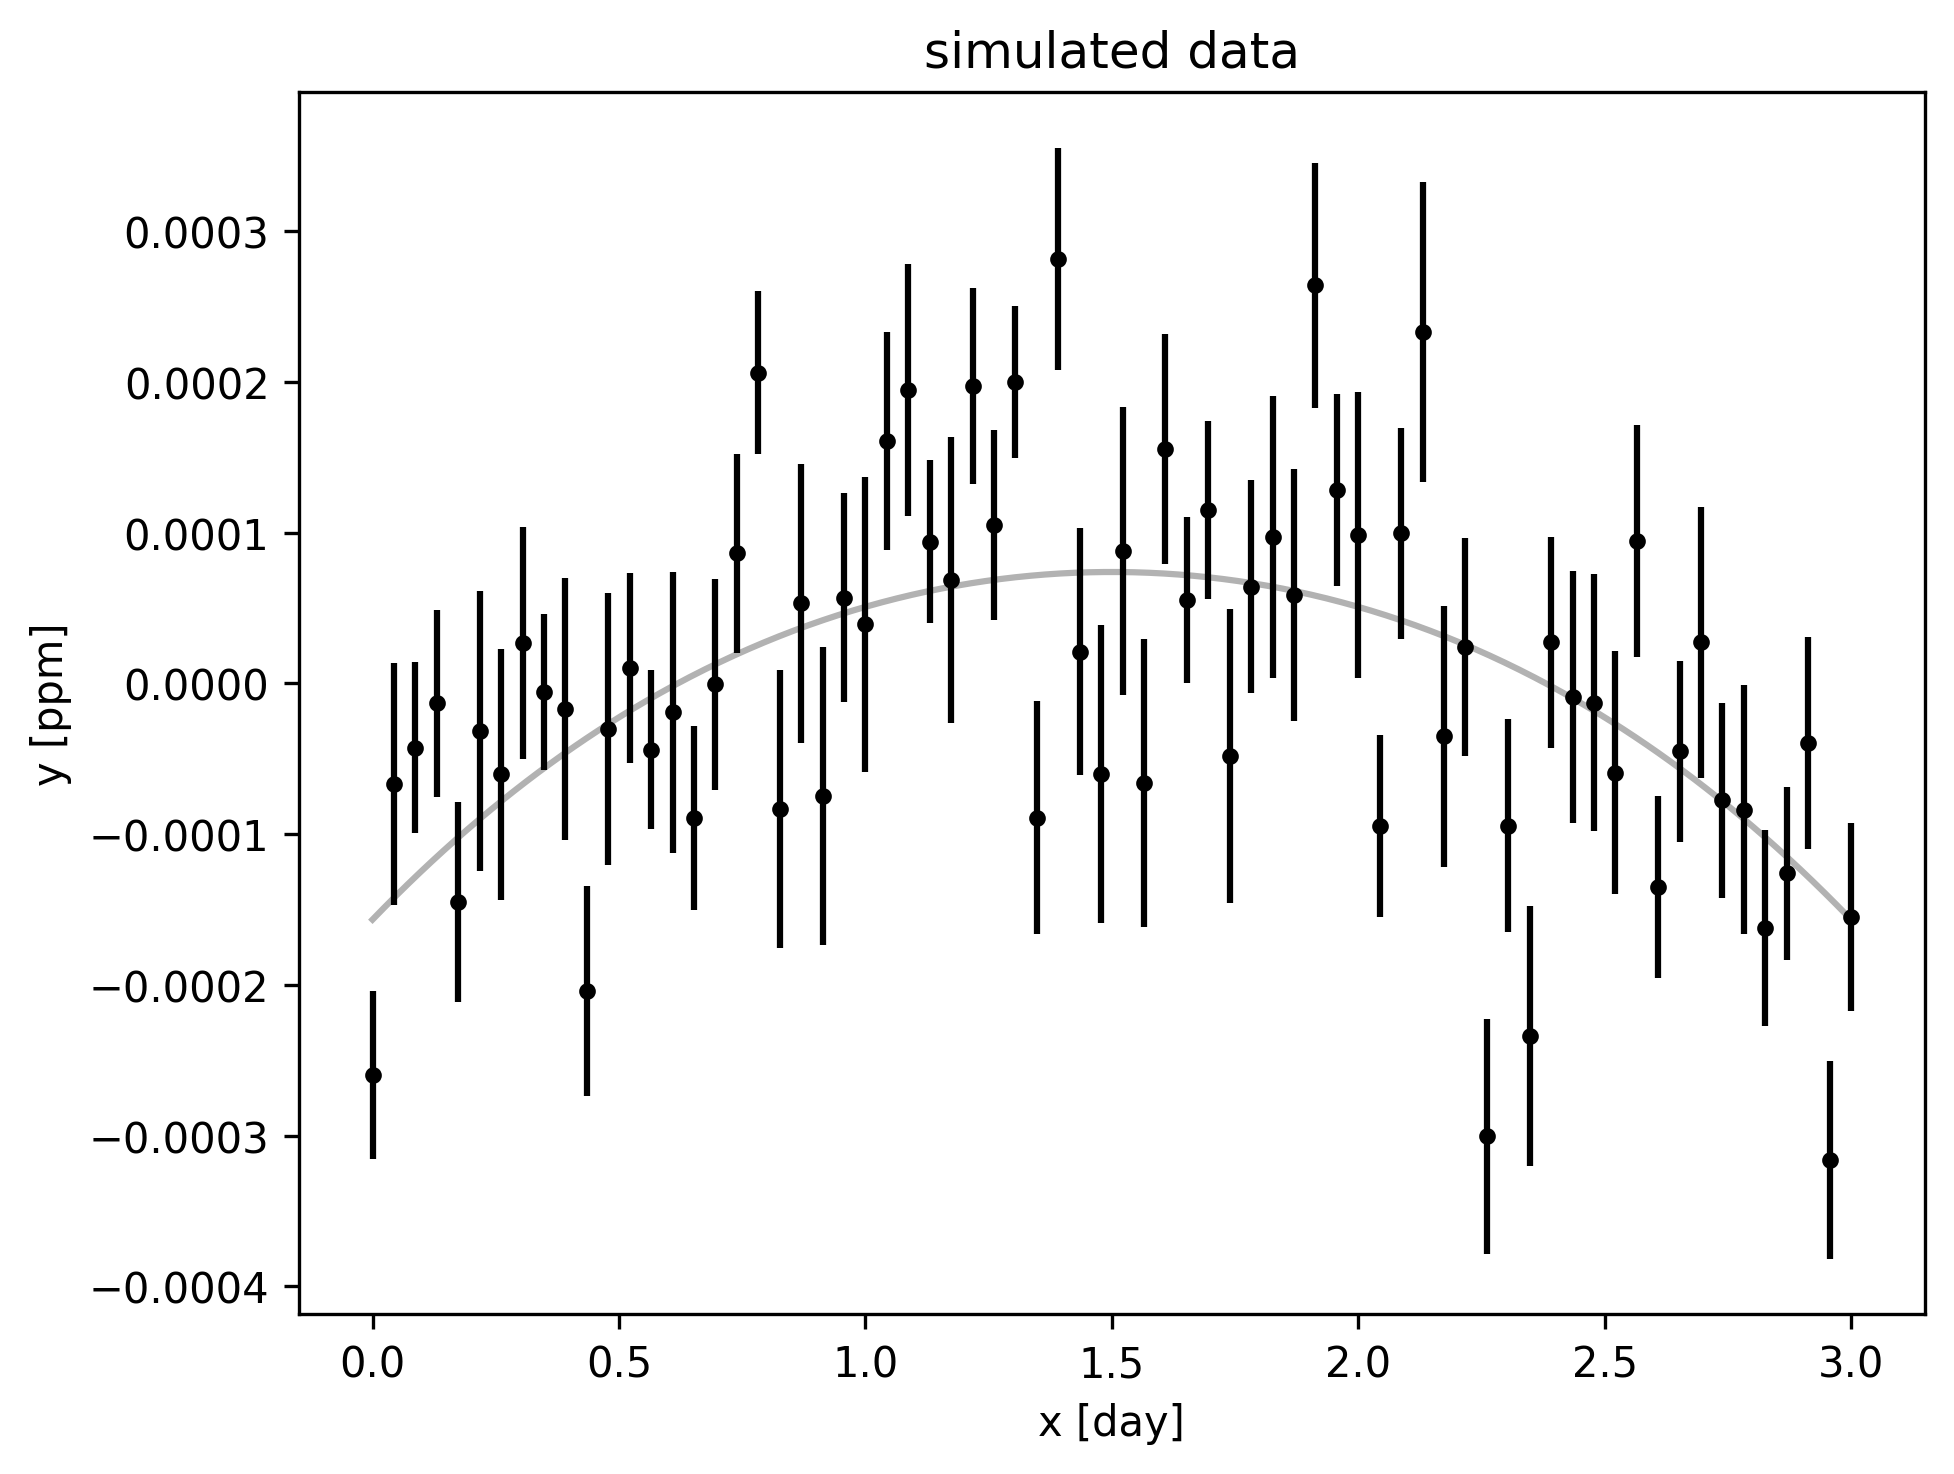

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(43)

# t = np.sort(
#     np.append(
#         np.random.uniform(0, 3.8, 57),
#         np.random.uniform(5.5, 10, 68),
#     )
# )  # The input coordinates must be sorted
t = np.linspace(0, 3, 70)
yerr = np.random.uniform(0.05, 0.1, len(t))
y = (
    # 0.2 * (t - 5)
    np.sin(0.7 * t + 0.1 * (t - 5) ** 2)
    + yerr * np.random.randn(len(t))
)
y = (y/np.mean(y))-1


true_t = np.linspace(0, 3, 500)
# true_y = 0.2 * (true_t - 5) + 
true_y = np.sin(0.7 * true_t + 0.1 * (true_t - 5) ** 2)
true_y = (true_y/np.mean(true_y))-1

plt.plot(true_t, true_y/1e3, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y/1e3, yerr=yerr/1e3, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
# plt.xlim(0, 10)
# plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

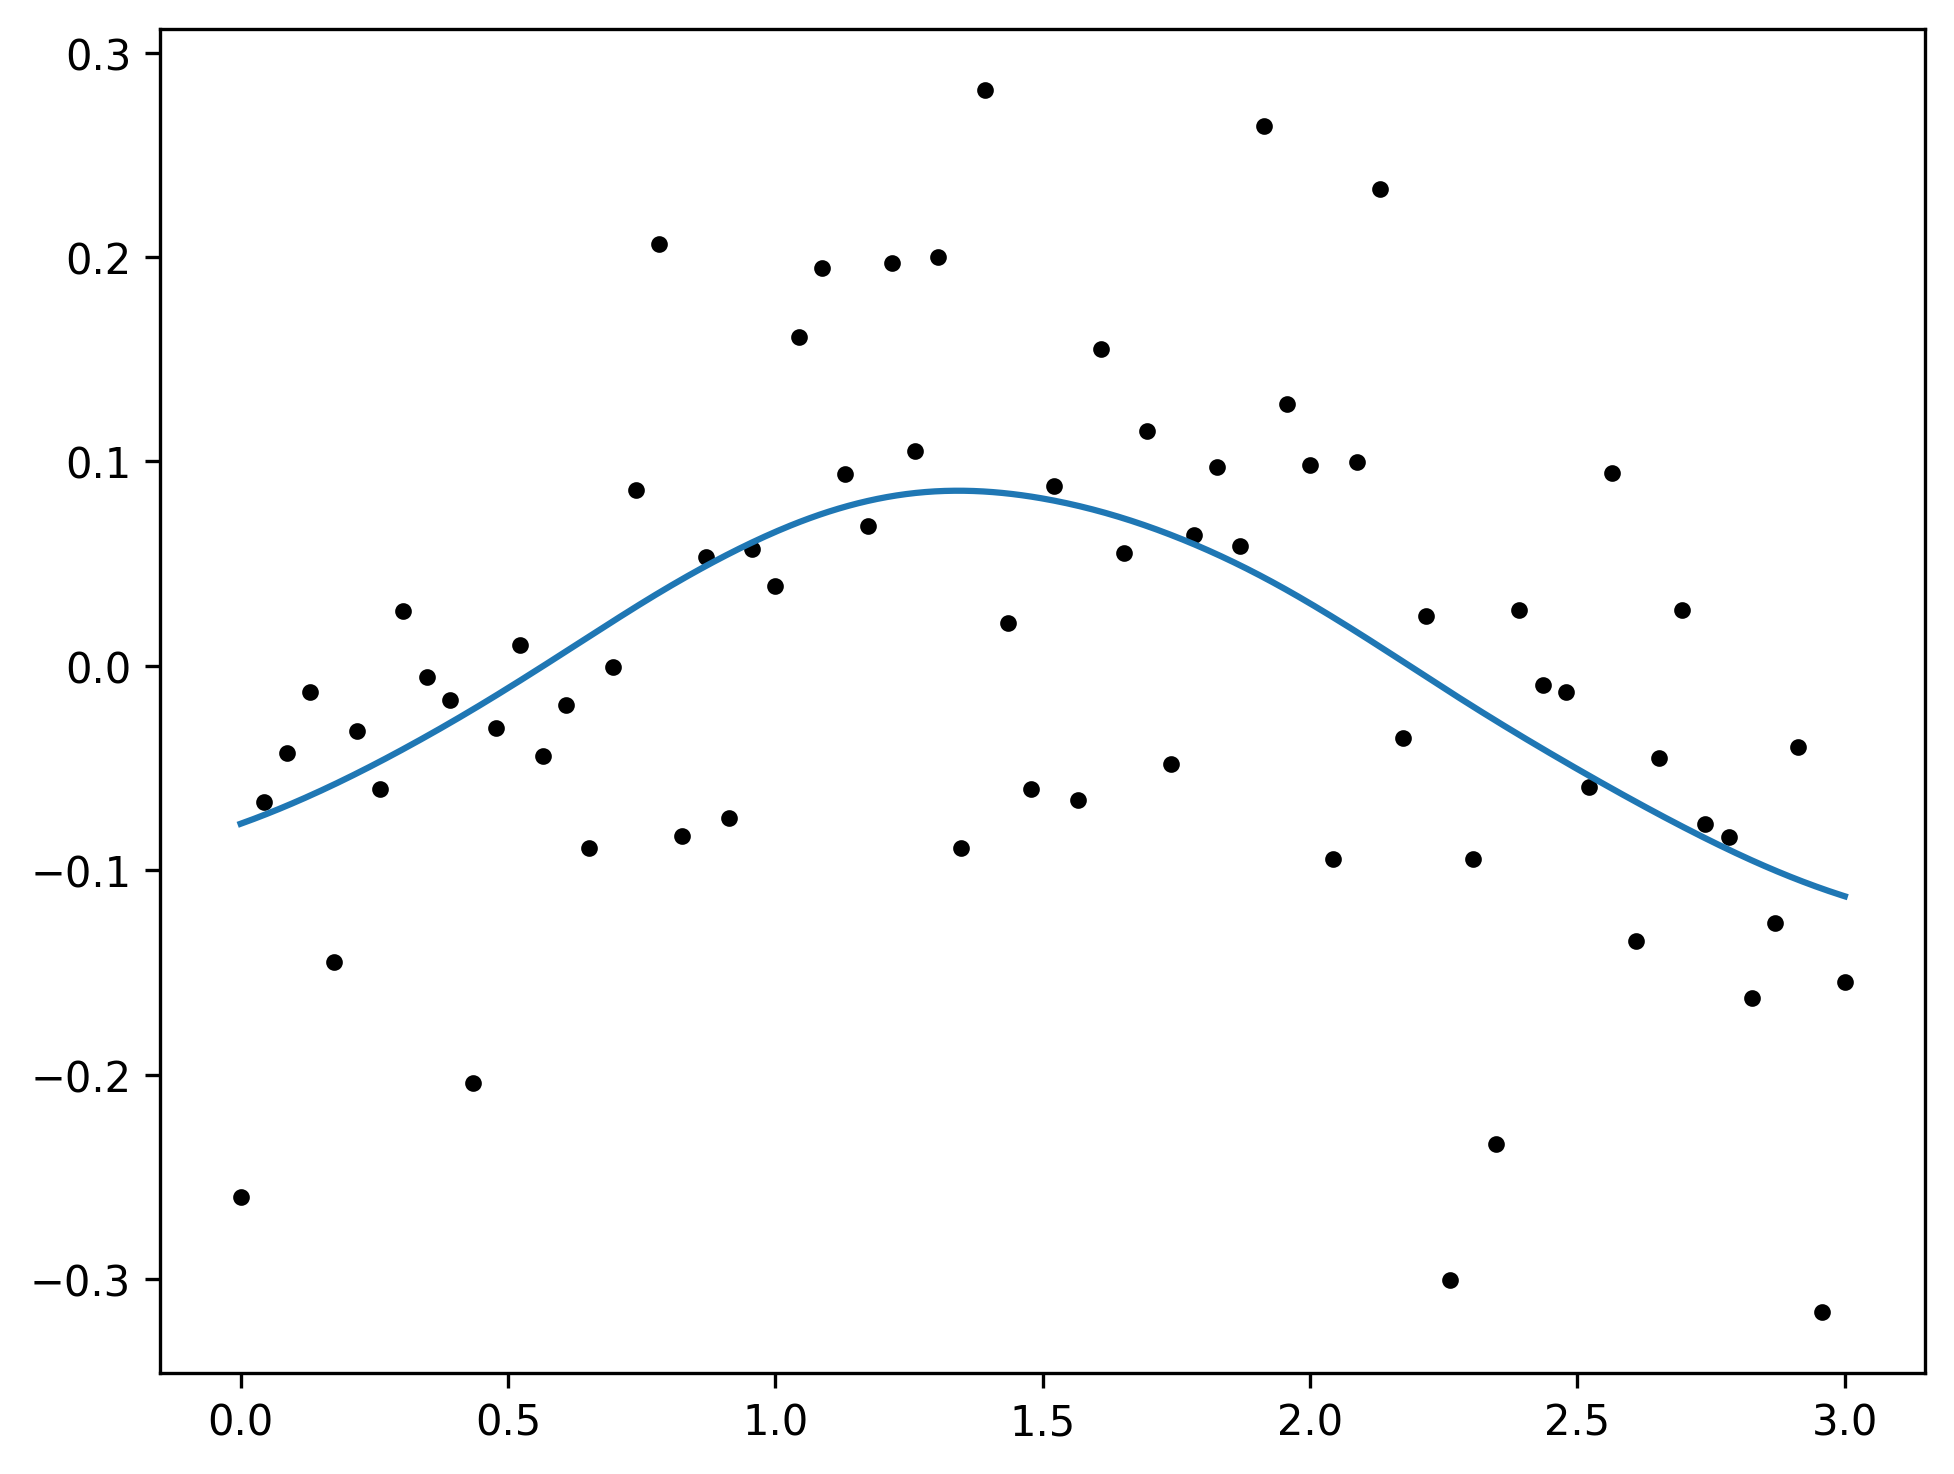

In [3]:
with pm.Model() as pmmodel:
    # Non-periodic component
    term2 = terms.SHOTerm(sigma=0.1, rho=10.0, tau=1.0)
    #terms.SHOTerm(sigma=0.1, rho=10, Q=0.25)
    kernel = term2
    
    # Setup the GP
    gp = GaussianProcess(kernel, mean=0.0)
    gp.compute(t, yerr=yerr)
    
    mu, variance = gp.predict(y, t=true_t, return_var=True)

    plt.plot(t,y, 'k.')
    plt.plot(true_t,eval_in_model(mu))


<Axes: xlabel='Time ($\\mathrm{d}$)', ylabel='log$_{10}$[Wavelength/($\\mathrm{\\mu m}$)]'>

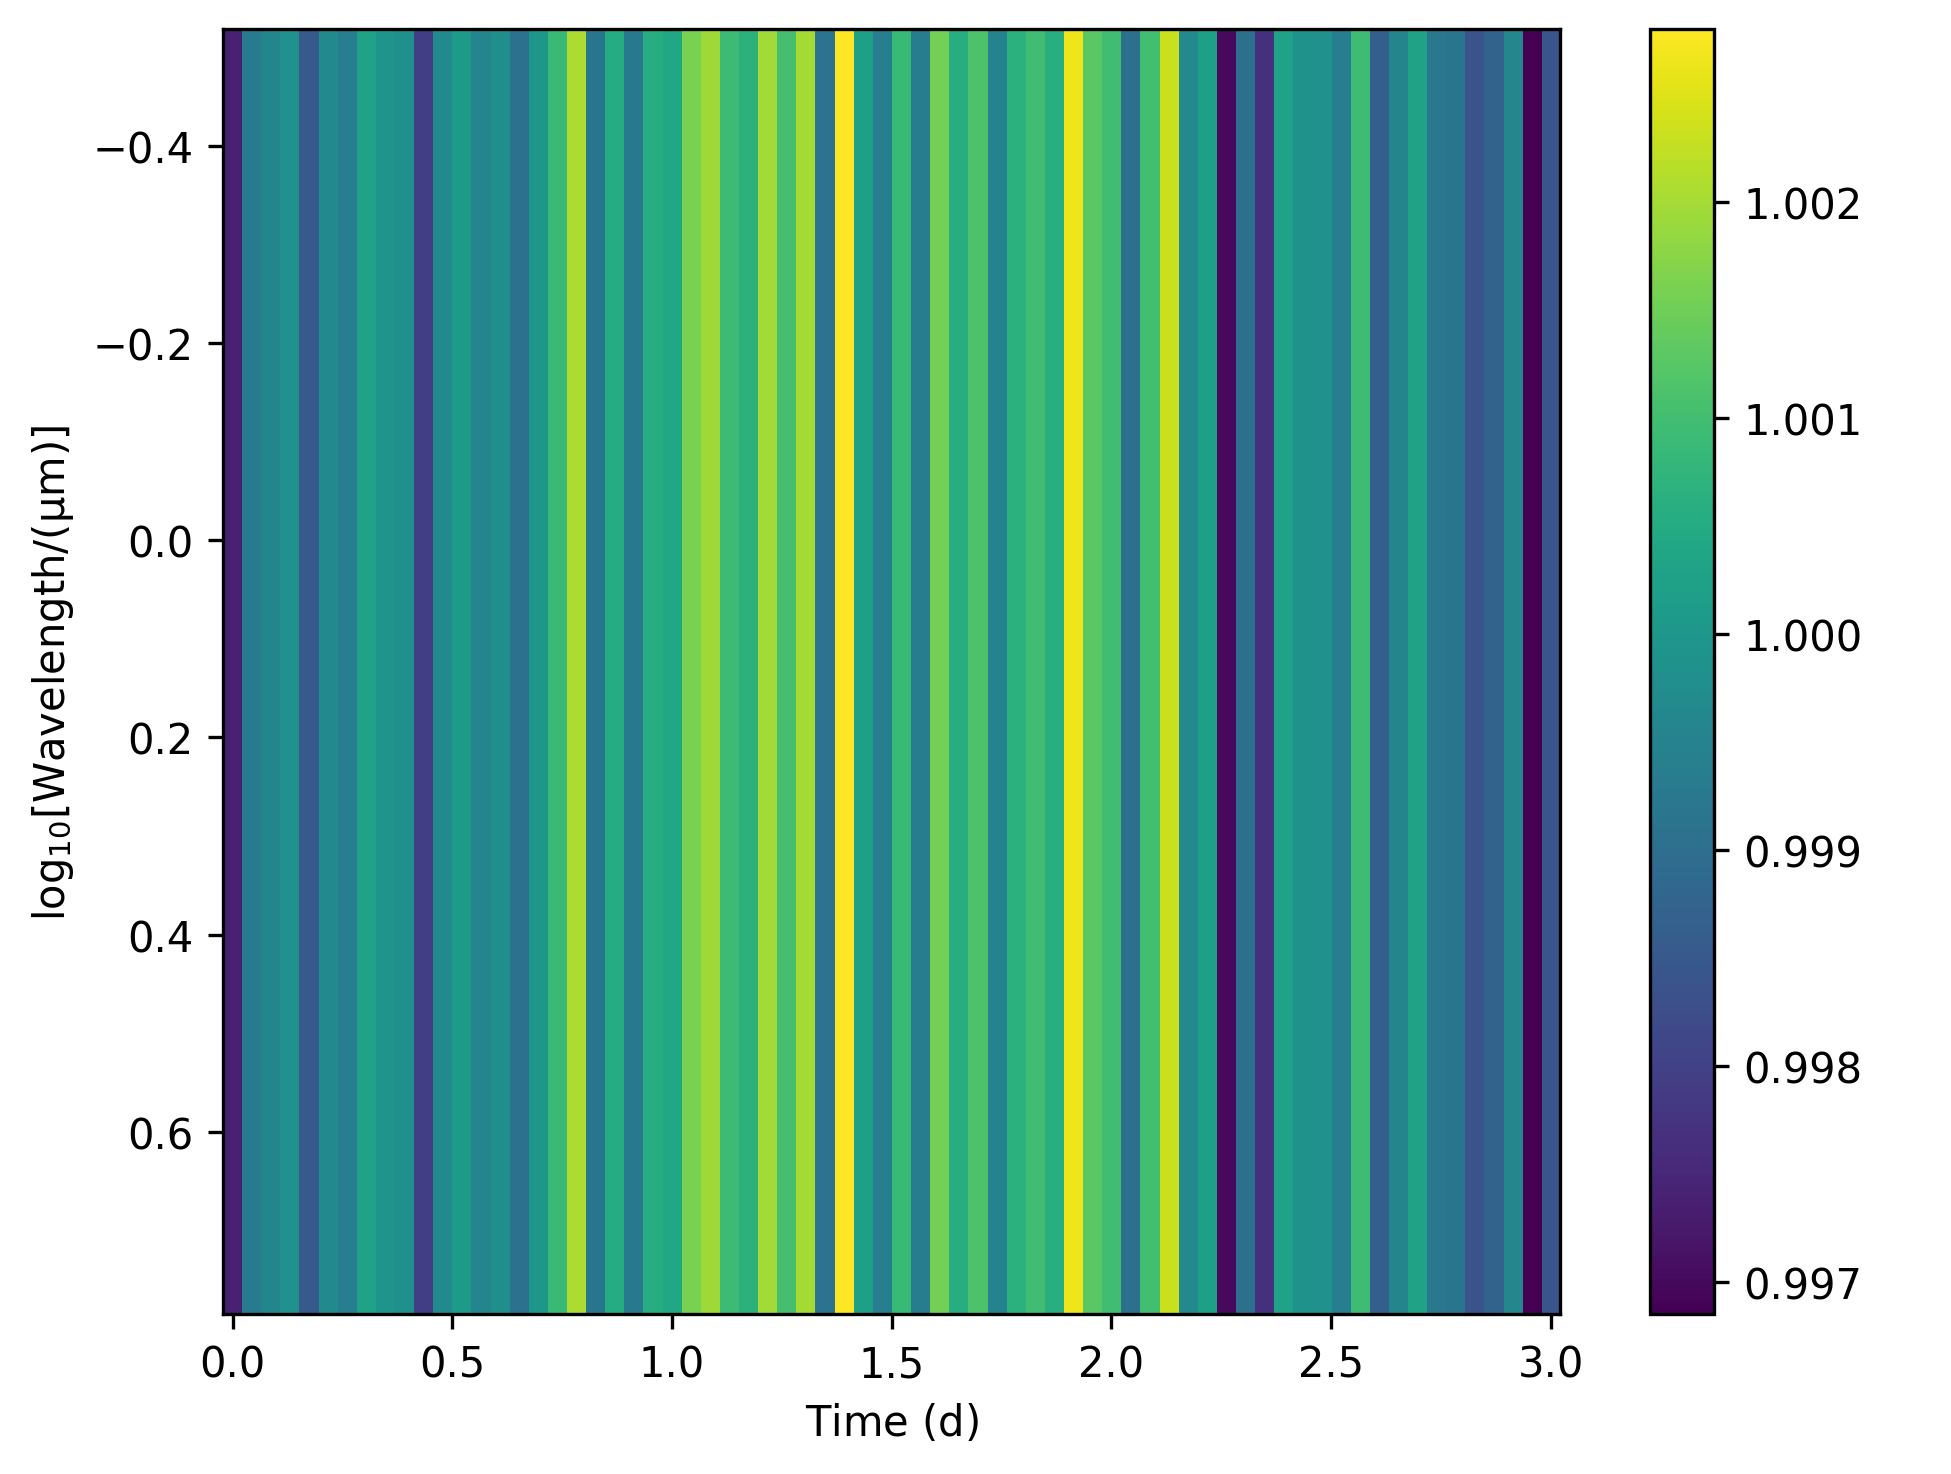

In [4]:
r = SimulatedRainbow(time=t*u.day, R=1).normalize()
r.flux *= 1+(y/1e2)
r.uncertainty[:,:] = yerr/1e2
r.imshow()

In [5]:
r

<Simulated🌈(3w, 70t)>

In [6]:
r = r.inject_transit(planet_radius=0.1,t0=1.7,per=3, a=9)

In [7]:
r.flux = r.flux - 1

(-0.1, 0.02)

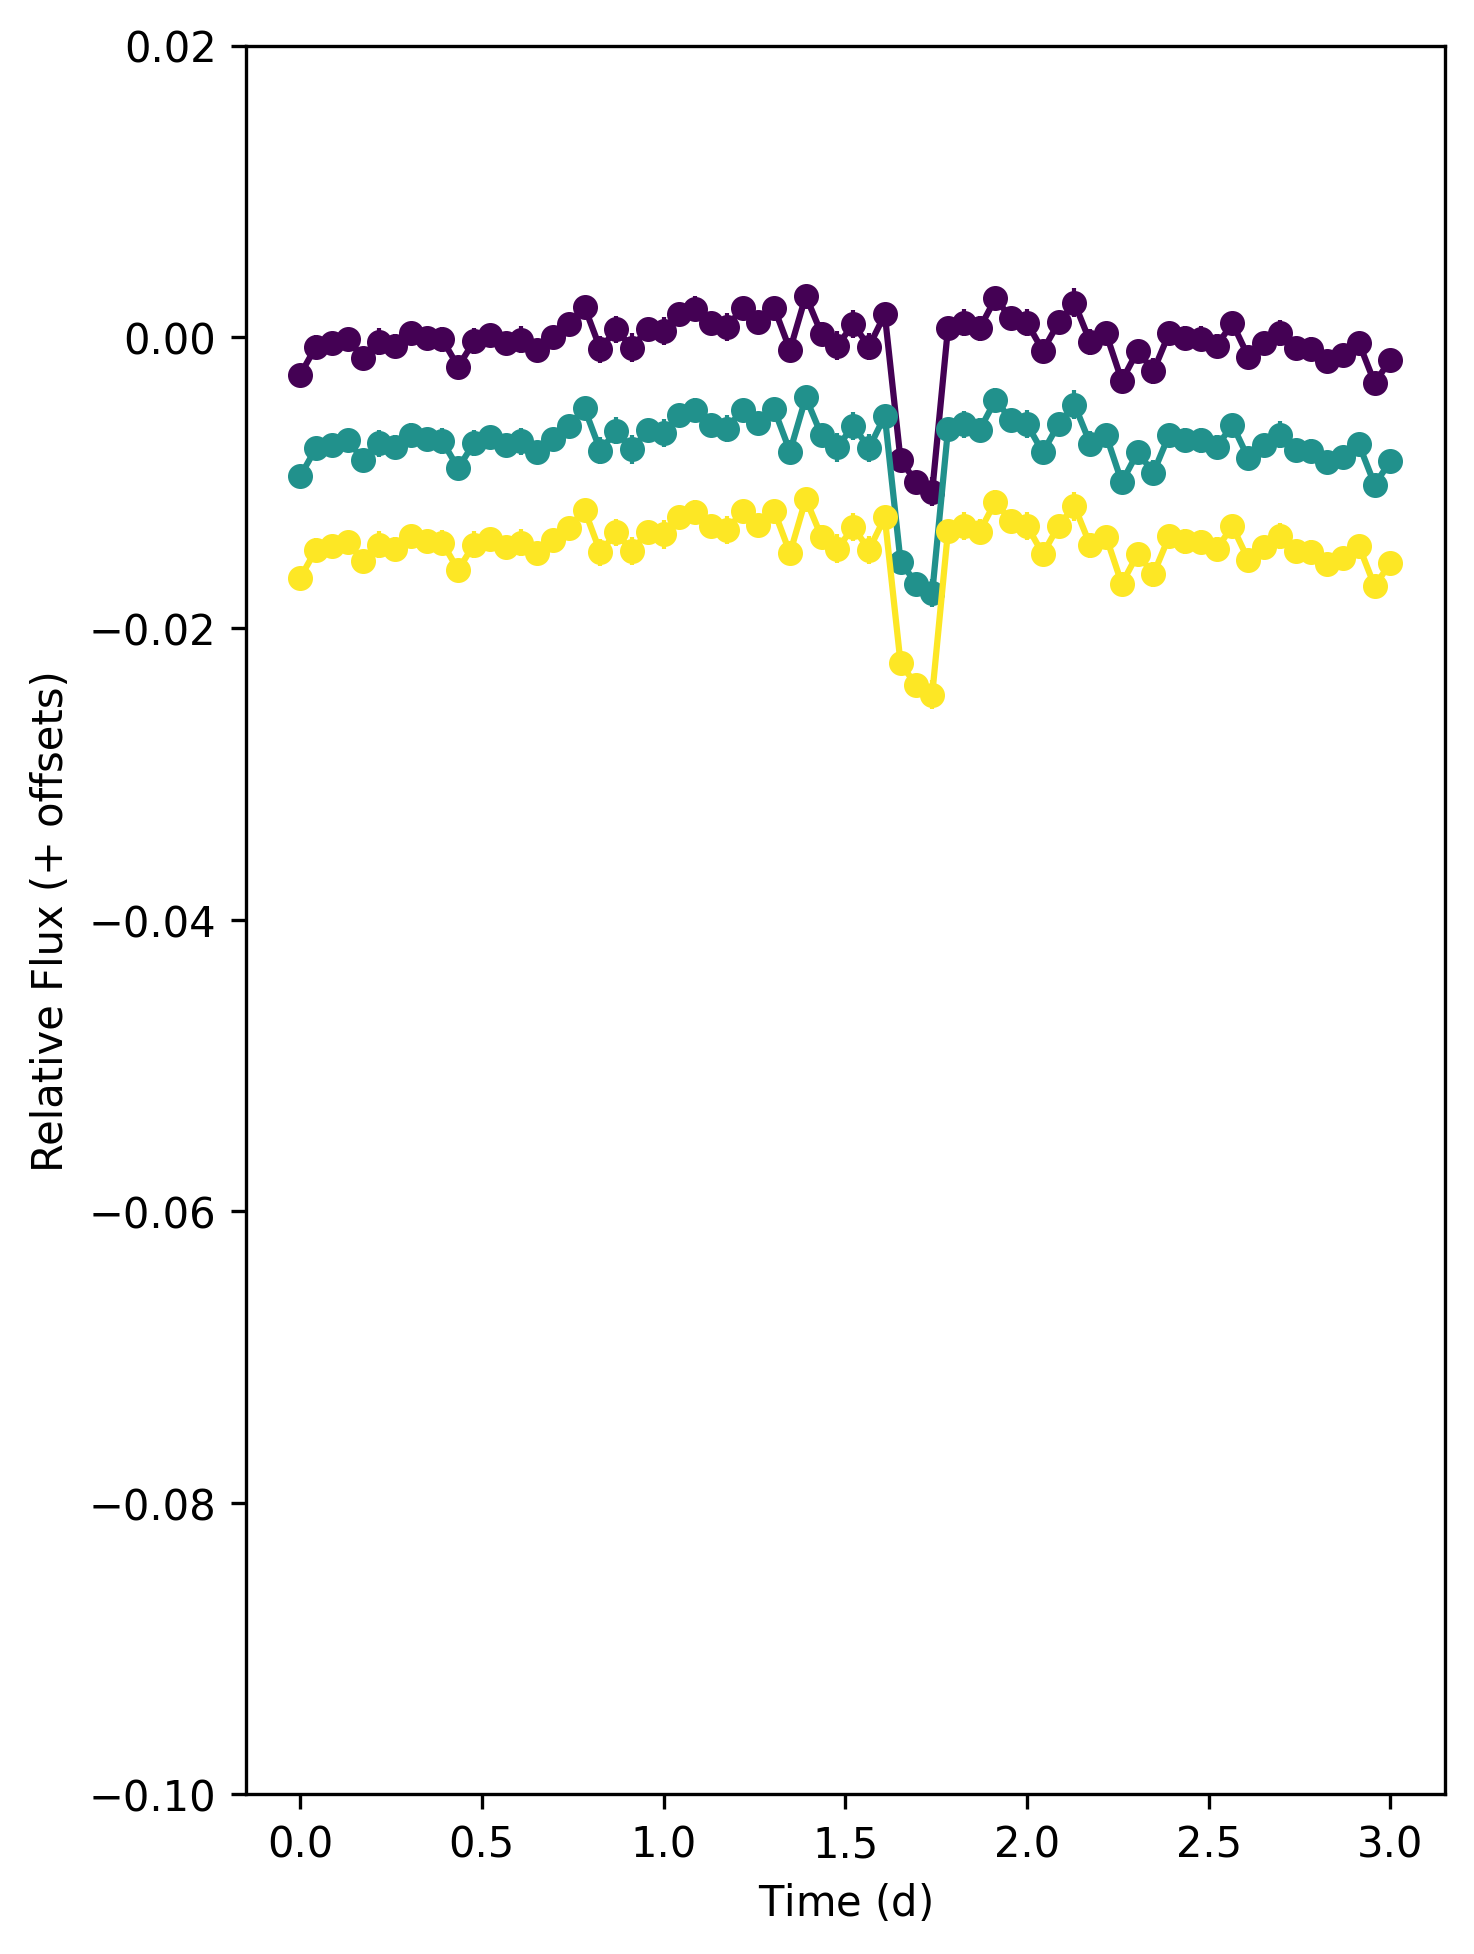

In [8]:
r.plot_lightcurves(text=False)
plt.ylim(-0.1,0.02)

In [9]:
from pymc3.distributions import InverseGamma, Lognormal, Logistic

In [104]:
# set up polynomial model:
p1 = GPModel(kernel='quasi_periodic', name='rot')

# p1.setup_parameters(
#     sigma = WavelikeFitted(Lognormal,mu=0.0, sigma=2),
#     rho = Fitted(Lognormal,mu=0.0, sigma=2),
#     tau = Fitted(Lognormal,mu=0.0, sigma=2),
# )

# # sigma=0.1, rho=10.0, tau=1.0
# p1.summarize_parameters()

p1.setup_parameters(
    sigma = Fitted(Lognormal, mu=0, sigma=1),#InverseGamma, **pmx.estimate_inverse_gamma_parameters(1, 5)),
    period = Fitted(Normal,mu=1, sigma=1),
    Q0 = Fitted(Lognormal,mu=0, sigma=1),
    dQ = Fitted(Lognormal,mu=0, sigma=1),
    f = Fitted(Uniform, lower=0.01, upper=1)
)
p1.summarize_parameters()

rot_sigma =
  <🧮 Fitted Lognormal(mu=0, sigma=1, name='rot_sigma') 🧮>

rot_period =
  <🧮 Fitted Normal(mu=1, sigma=1, name='rot_period') 🧮>

rot_dQ =
  <🧮 Fitted Lognormal(mu=0, sigma=1, name='rot_dQ') 🧮>

rot_Q0 =
  <🧮 Fitted Lognormal(mu=0, sigma=1, name='rot_Q0') 🧮>

rot_f =
  <🧮 Fitted Uniform(lower=0.01, upper=1, name='rot_f') 🧮>



In [105]:
# set up polynomial model:
# p2 = GPModel(kernel='sho', name='nonperiodic')

# p2.setup_parameters(
#     sigma = Fitted(Normal,mu=1, sigma=100),
#     rho = Fitted(Normal,mu=1, sigma=100),
#     Q = 0.25,
# )

# # print a summary of all params:
# p2.summarize_parameters()
# p2 = PolynomialModel(degree=1,)
# p2.setup_parameters(
#     p_0=Fitted(Normal, mu=0, sigma=0.1),
#     p_1=Fitted(Normal, mu=1/5000, sigma=0.1),
# )
# p2.summarize_parameters()

tr = TransitModel()
tr.setup_parameters(
                  period=3, #Fitted(Normal, mu=10, sigma=0.1), #Fitted(Normal, mu=3.5, sigma=0.1), # a fixed value!
                   epoch=Fitted(Normal, mu=1.63, sigma=0.05), # one fitted value across all wavelengths
                   stellar_radius = Fitted(Normal, mu=1.0, sigma=0.1),
                   stellar_mass = Fitted(Normal, mu=1.0, sigma=0.1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.1, sigma=0.01), # a different value fitted for every wavelength!
                   impact_parameter=0, #Fitted(Uniform, lower=0, upper=1, testval=0.1),
                   limb_darkening=WavelikeFitted(Uniform, lower=[0,0], upper=[1,1], testval=[0.2,0.2], shape=2),
                   baseline = Fitted(Normal, mu=0.0, sigma=0.1), #WavelikeFitted(Normal, mu=0.0, sigma=0.05), 
                )
tr.summarize_parameters()

transit_stellar_radius =
  <🧮 Fitted Normal(mu=1.0, sigma=0.1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Normal(mu=1.0, sigma=0.1, name='transit_stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.1, sigma=0.01, name='transit_radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 3 🧮>

transit_epoch =
  <🧮 Fitted Normal(mu=1.63, sigma=0.05, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 Fitted Normal(mu=0.0, sigma=0.1, name='transit_baseline') 🧮>

transit_impact_parameter =
  <🧮 Fixed | 0 🧮>

transit_eccentricity =
  <🧮 Fixed | 0.0 🧮>

transit_omega =
  <🧮 Fixed | 0 🧮>

transit_limb_darkening =
  <🧮 WavelikeFitted Uniform(lower=[0, 0], upper=[1, 1], testval=[0.2, 0.2], shape=2, name='transit_limb_darkening') for each wavelength 🧮>



In [106]:
p = p1 + tr

In [107]:
p

<chromatic combined model 'combined' 🌈, models: <chromatic GP model 'rot', with quasi_periodic kernel 🌈> + <chromatic transit model 'transit' 🌈>

In [108]:
p.summarize_parameters()

A CombinedModel itself does not have any parameters, however each of its constituent models do:

rot_sigma =
  <🧮 Fitted Lognormal(mu=0, sigma=1, name='rot_sigma') 🧮>

rot_period =
  <🧮 Fitted Normal(mu=1, sigma=1, name='rot_period') 🧮>

rot_dQ =
  <🧮 Fitted Lognormal(mu=0, sigma=1, name='rot_dQ') 🧮>

rot_Q0 =
  <🧮 Fitted Lognormal(mu=0, sigma=1, name='rot_Q0') 🧮>

rot_f =
  <🧮 Fitted Uniform(lower=0.01, upper=1, name='rot_f') 🧮>

transit_stellar_radius =
  <🧮 Fitted Normal(mu=1.0, sigma=0.1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Normal(mu=1.0, sigma=0.1, name='transit_stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.1, sigma=0.01, name='transit_radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 3 🧮>

transit_epoch =
  <🧮 Fitted Normal(mu=1.63, sigma=0.05, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 Fitted Normal(mu=0.0, sigma=0.1, name='transit_baseline') 🧮>

transit_impact_parameter =
  <🧮 Fixed | 0 🧮>



In [109]:
p.attach_data(r)

In [110]:
p.add_jitter(Fitted(Normal,name='log_jitter', mu=np.log(np.mean(p.data.uncertainty)), sd=2))
# p.add_mean(tr)

Error applying add_jitter to <chromatic transit model 'transit' 🌈>: 'TransitModel' object has no attribute 'add_jitter'


In [111]:
p.setup_lightcurves()

/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/chromatic_fitting/models/gp.py:109: UserWarning: 
You have not provided a mean to the GP. Are you sure this is right?
If you want to add a mean please run {self}.add_mean. We will proceed assuming a mean of 0.

  warnings.warn(


{'sigma': Subtensor{int64}.0, 'period': Subtensor{int64}.0, 'dQ': Subtensor{int64}.0, 'Q0': Subtensor{int64}.0, 'f': Subtensor{int64}.0}
{'sigma': Subtensor{int64}.0, 'period': Subtensor{int64}.0, 'dQ': Subtensor{int64}.0, 'Q0': Subtensor{int64}.0, 'f': Subtensor{int64}.0}
{'sigma': Subtensor{int64}.0, 'period': Subtensor{int64}.0, 'dQ': Subtensor{int64}.0, 'Q0': Subtensor{int64}.0, 'f': Subtensor{int64}.0}


In [112]:
print(p._pymc3_model)

                  rot_sigma_log__ ~ TransformedDistribution
                       rot_period ~ Normal
                     rot_dQ_log__ ~ TransformedDistribution
                     rot_Q0_log__ ~ TransformedDistribution
                 rot_f_interval__ ~ TransformedDistribution
                       log_jitter ~ Normal
                    transit_epoch ~ Normal
           transit_stellar_radius ~ Normal
             transit_stellar_mass ~ Normal
transit_limb_darkening_interval__ ~ TransformedDistribution
             transit_radius_ratio ~ Normal
                 transit_baseline ~ Normal
                        rot_sigma ~ Lognormal
                           rot_dQ ~ Lognormal
                           rot_Q0 ~ Lognormal
                            rot_f ~ Uniform
           transit_limb_darkening ~ Uniform
                     transit_a_R* ~ Deterministic
            transit_planet_radius ~ Deterministic


In [113]:
p.setup_likelihood()

/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/chromatic_fitting/models/combined.py:530: UserWarning: 
You have not provided a mean to the GP. Are you sure this is right?
If you want to add a mean please run {self}.add_mean. We will proceed assuming a mean of 0.

  warnings.warn(


In [114]:
# p._chromatic_models['transit'].parameters

In [115]:
p._pymc3_model.check_test_point()

rot_sigma_log__                      -0.92
rot_period                           -0.92
rot_dQ_log__                         -0.92
rot_Q0_log__                         -0.92
rot_f_interval__                     -1.39
log_jitter                           -1.61
transit_epoch                         2.08
transit_stellar_radius                1.38
transit_stellar_mass                  1.38
transit_limb_darkening_interval__   -11.00
transit_radius_ratio                 11.06
transit_baseline                      1.38
gp_w0                                37.16
gp_w1                                37.16
gp_w2                                37.16
Name: Log-probability of test_point, dtype: float64

optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_epoch, log_jitter, rot_f, rot_Q0, rot_dQ, rot_period, rot_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: 111.09546555831932 -> 987.5241156932921


(-0.02, 0.02)

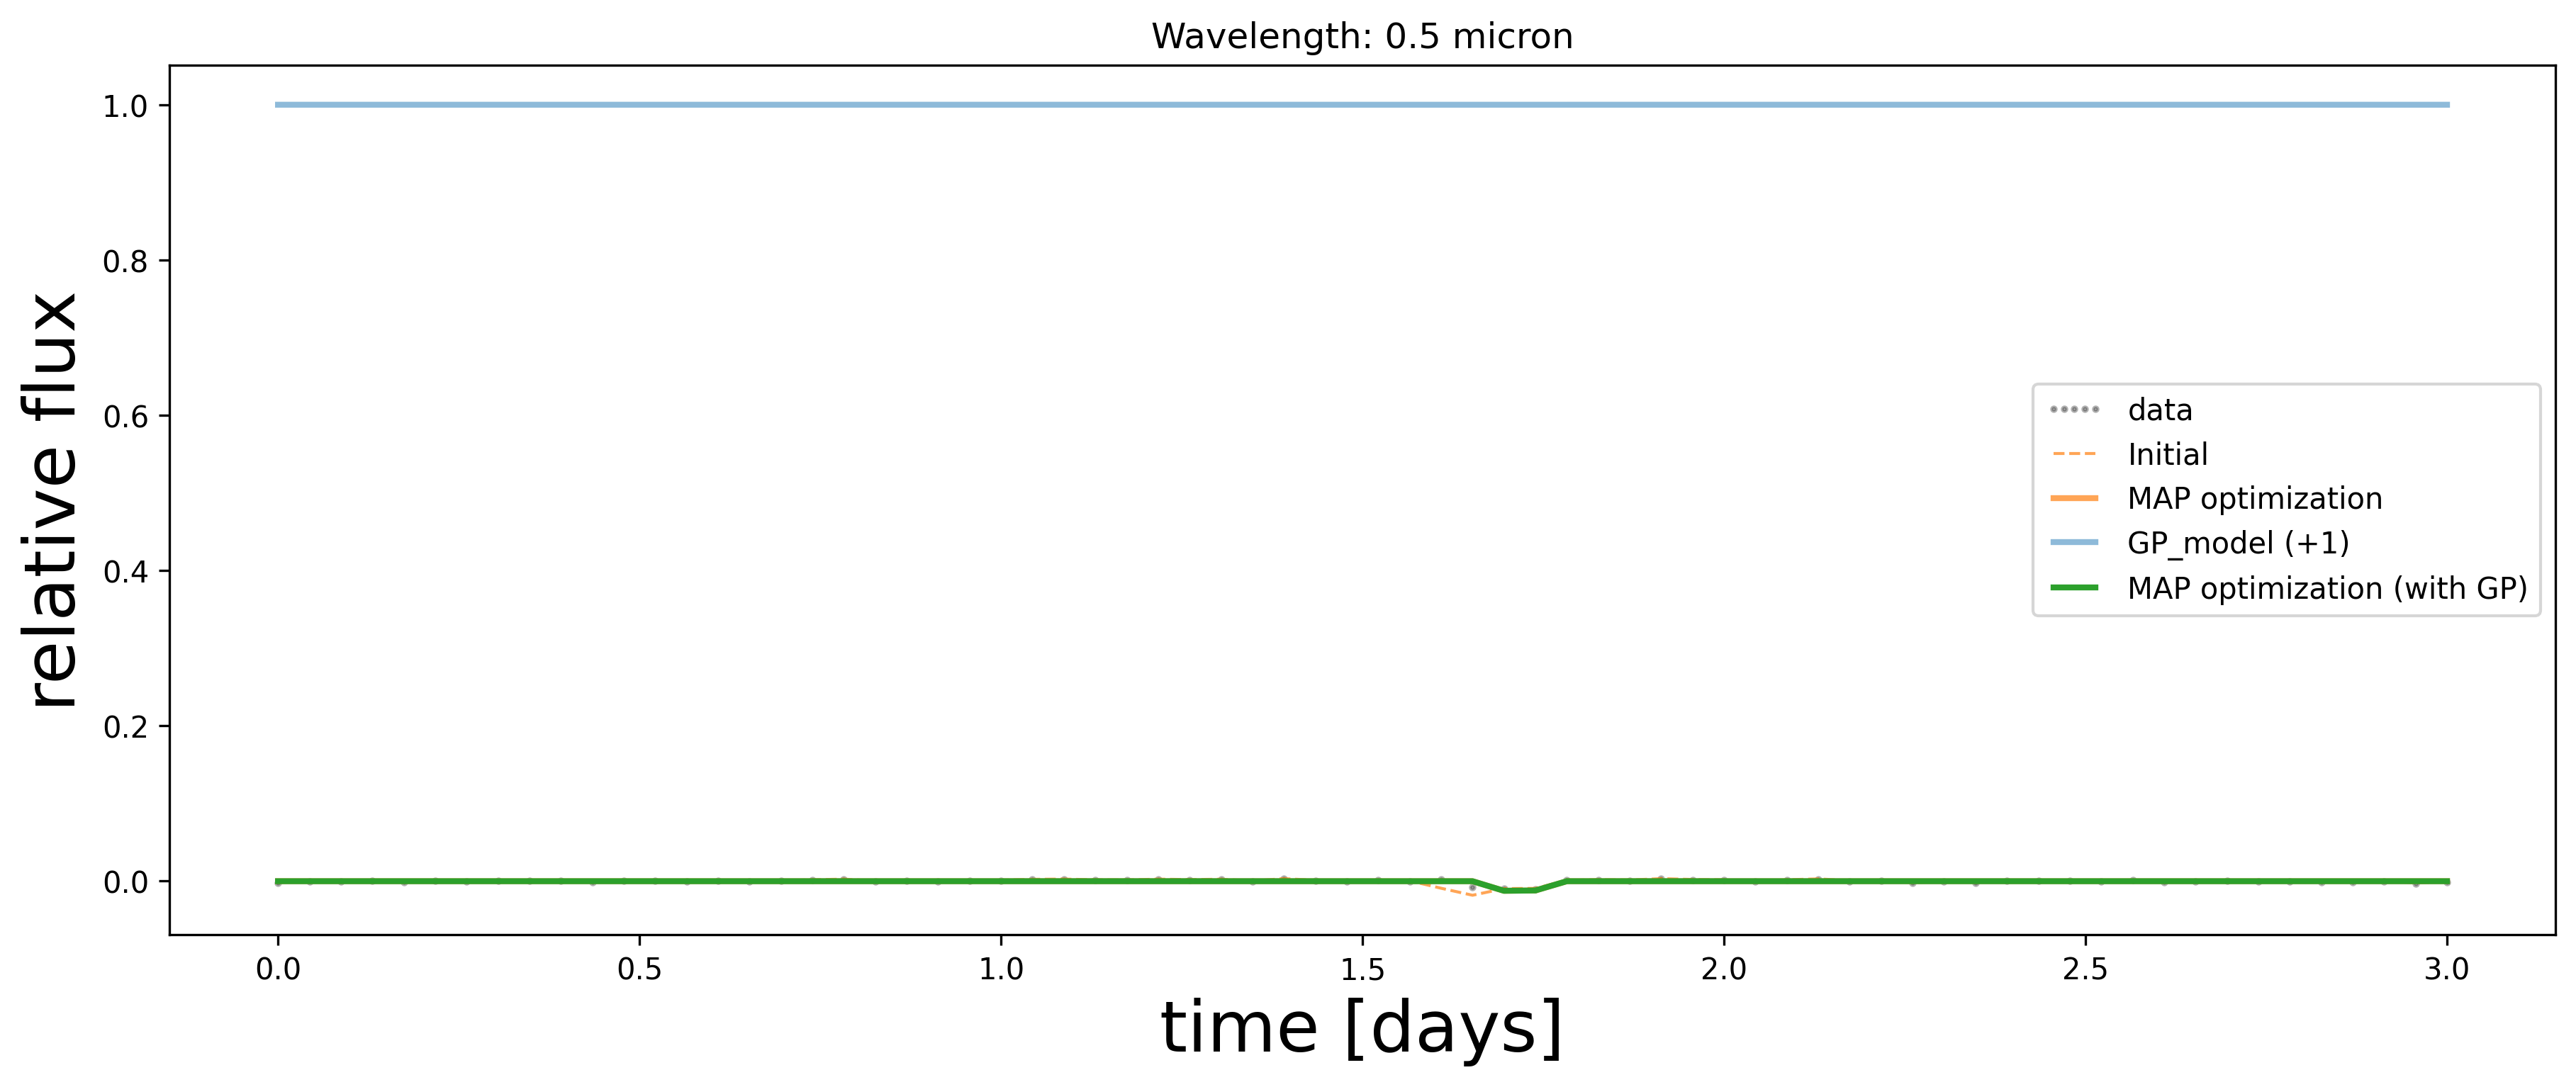

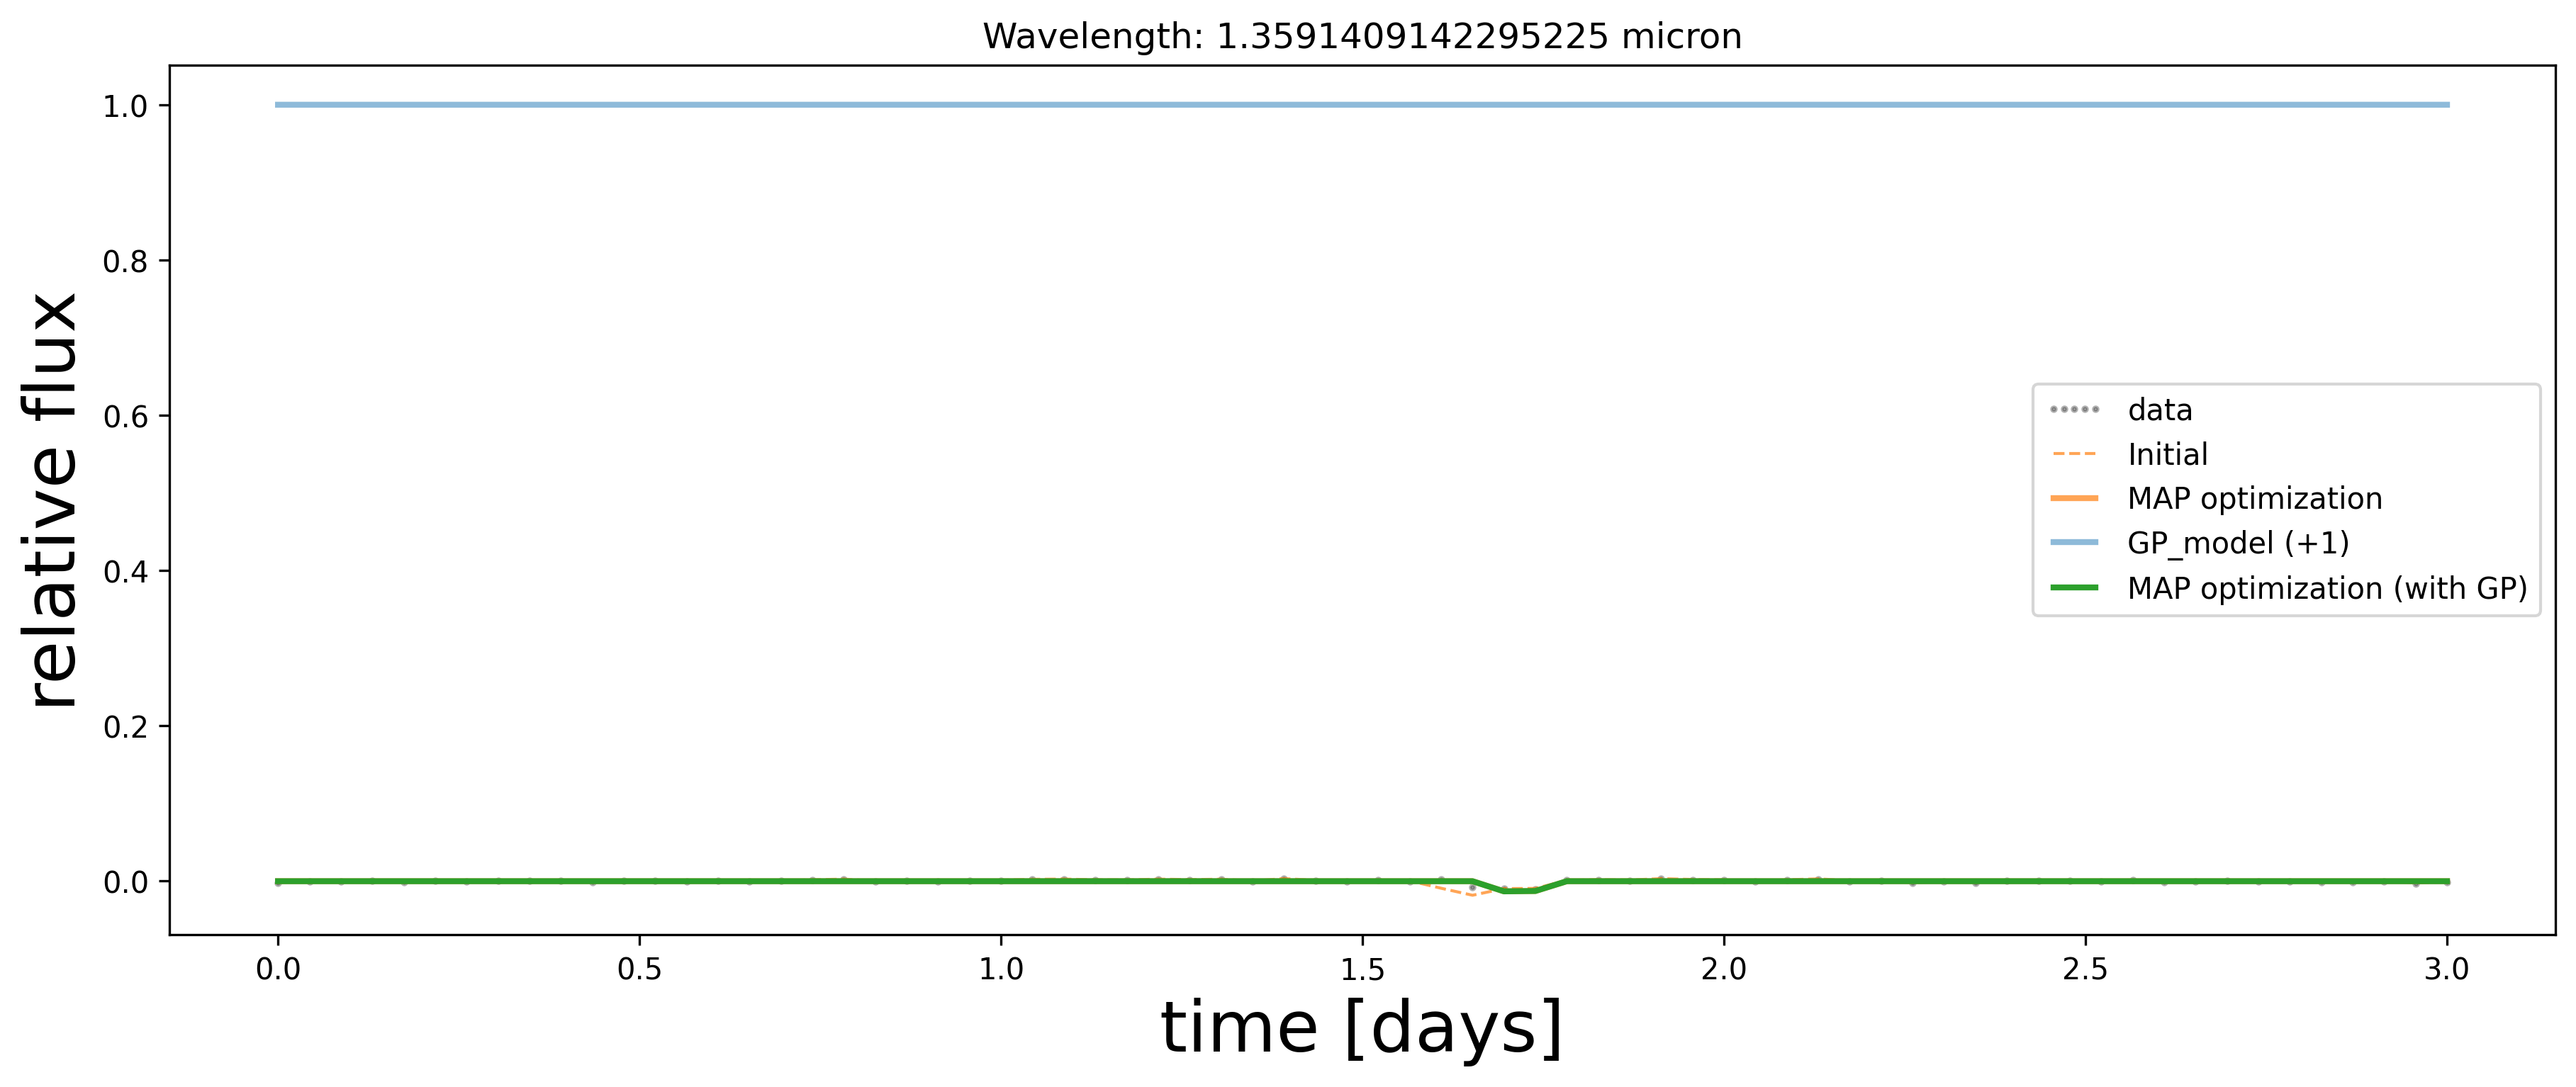

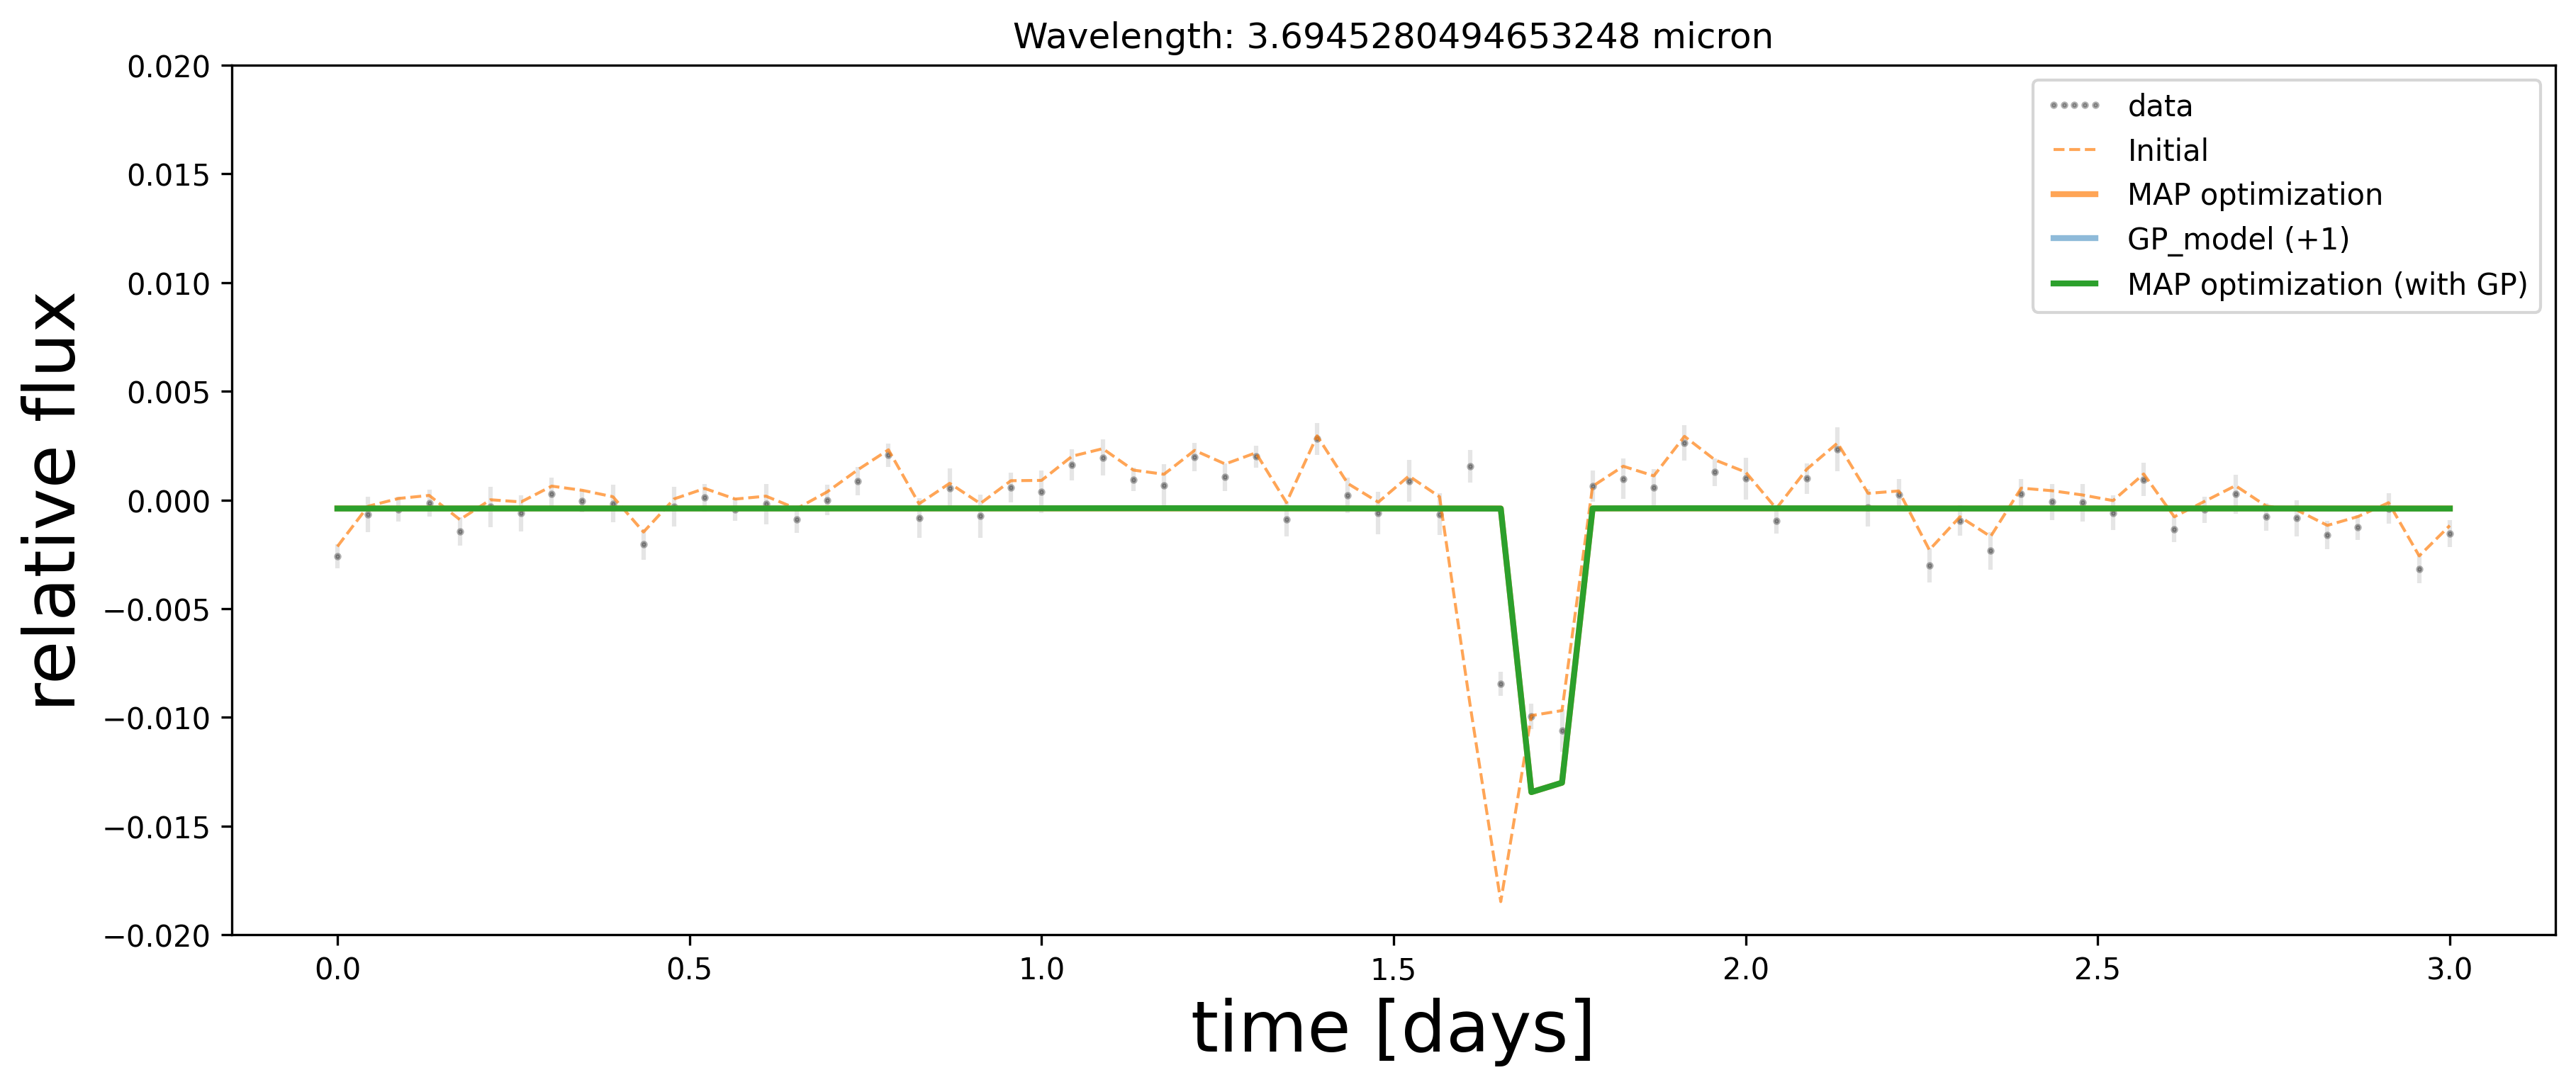

In [116]:
opt = p.optimize(plot=True)
plt.ylim(-0.02,0.02)

In [91]:
opt

{'rot_sigma_log__': array([0.]),
 'rot_period': array([1.]),
 'rot_dQ_log__': array([0.]),
 'rot_Q0_log__': array([0.]),
 'rot_f_interval__': array([0.]),
 'log_jitter': array(-7.19320166),
 'transit_epoch': array([1.6]),
 'transit_stellar_radius': array([1.]),
 'transit_stellar_mass': array([1.]),
 'transit_limb_darkening_interval__': array([[-1.38629436, -1.38629436],
        [-1.38629436, -1.38629436],
        [-1.38629436, -1.38629436]]),
 'transit_radius_ratio': array([0.1, 0.1, 0.1]),
 'transit_baseline': array([0.]),
 'rot_sigma': array([1.]),
 'rot_dQ': array([1.]),
 'rot_Q0': array([1.]),
 'rot_f': array([0.505]),
 'transit_limb_darkening': array([[0.2, 0.2],
        [0.2, 0.2],
        [0.2, 0.2]]),
 'transit_a_R*': array([8.75357171]),
 'transit_planet_radius': array([0.1, 0.1, 0.1])}

In [330]:
from astropy.constants import G
R_star = 1 * u.R_sun
a = 9 * R_star
P = 3 * u.d
M = (a**3 * 4 *(np.pi**2))/ (P**2 * G)
(M/(1* u.M_sun)).decompose()

<Quantity 1.0868551>

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

message: Desired error not necessarily achieved due to precision loss.
logp: 526.5602551142753 -> 526.5602551142753



{'rot_sigma': array([0.1, 0.1, 0.1]), 'rot_rho': array([10.]), 'rot_tau': array([1.]), 'log_jitter': array(-7.19320166), 'transit_epoch': array([1.65]), 'transit_stellar_radius': array([1.]), 'transit_stellar_mass': array([1.]), 'transit_limb_darkening_interval__': array([[-1.38629436, -1.38629436],
       [-1.38629436, -1.38629436],
       [-1.38629436, -1.38629436]]), 'transit_radius_ratio': array([0.1, 0.1, 0.1]), 'transit_baseline': array([0.]), 'transit_limb_darkening': array([[0.2, 0.2],
       [0.2, 0.2],
       [0.2, 0.2]]), 'transit_a_R*': array([8.75357171]), 'transit_planet_radius': array([0.1, 0.1, 0.1])}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

message: Desired error not necessarily achieved due to precision loss.
logp: 526.5602551142753 -> 1034.7168743597742


(-0.02, 0.02)

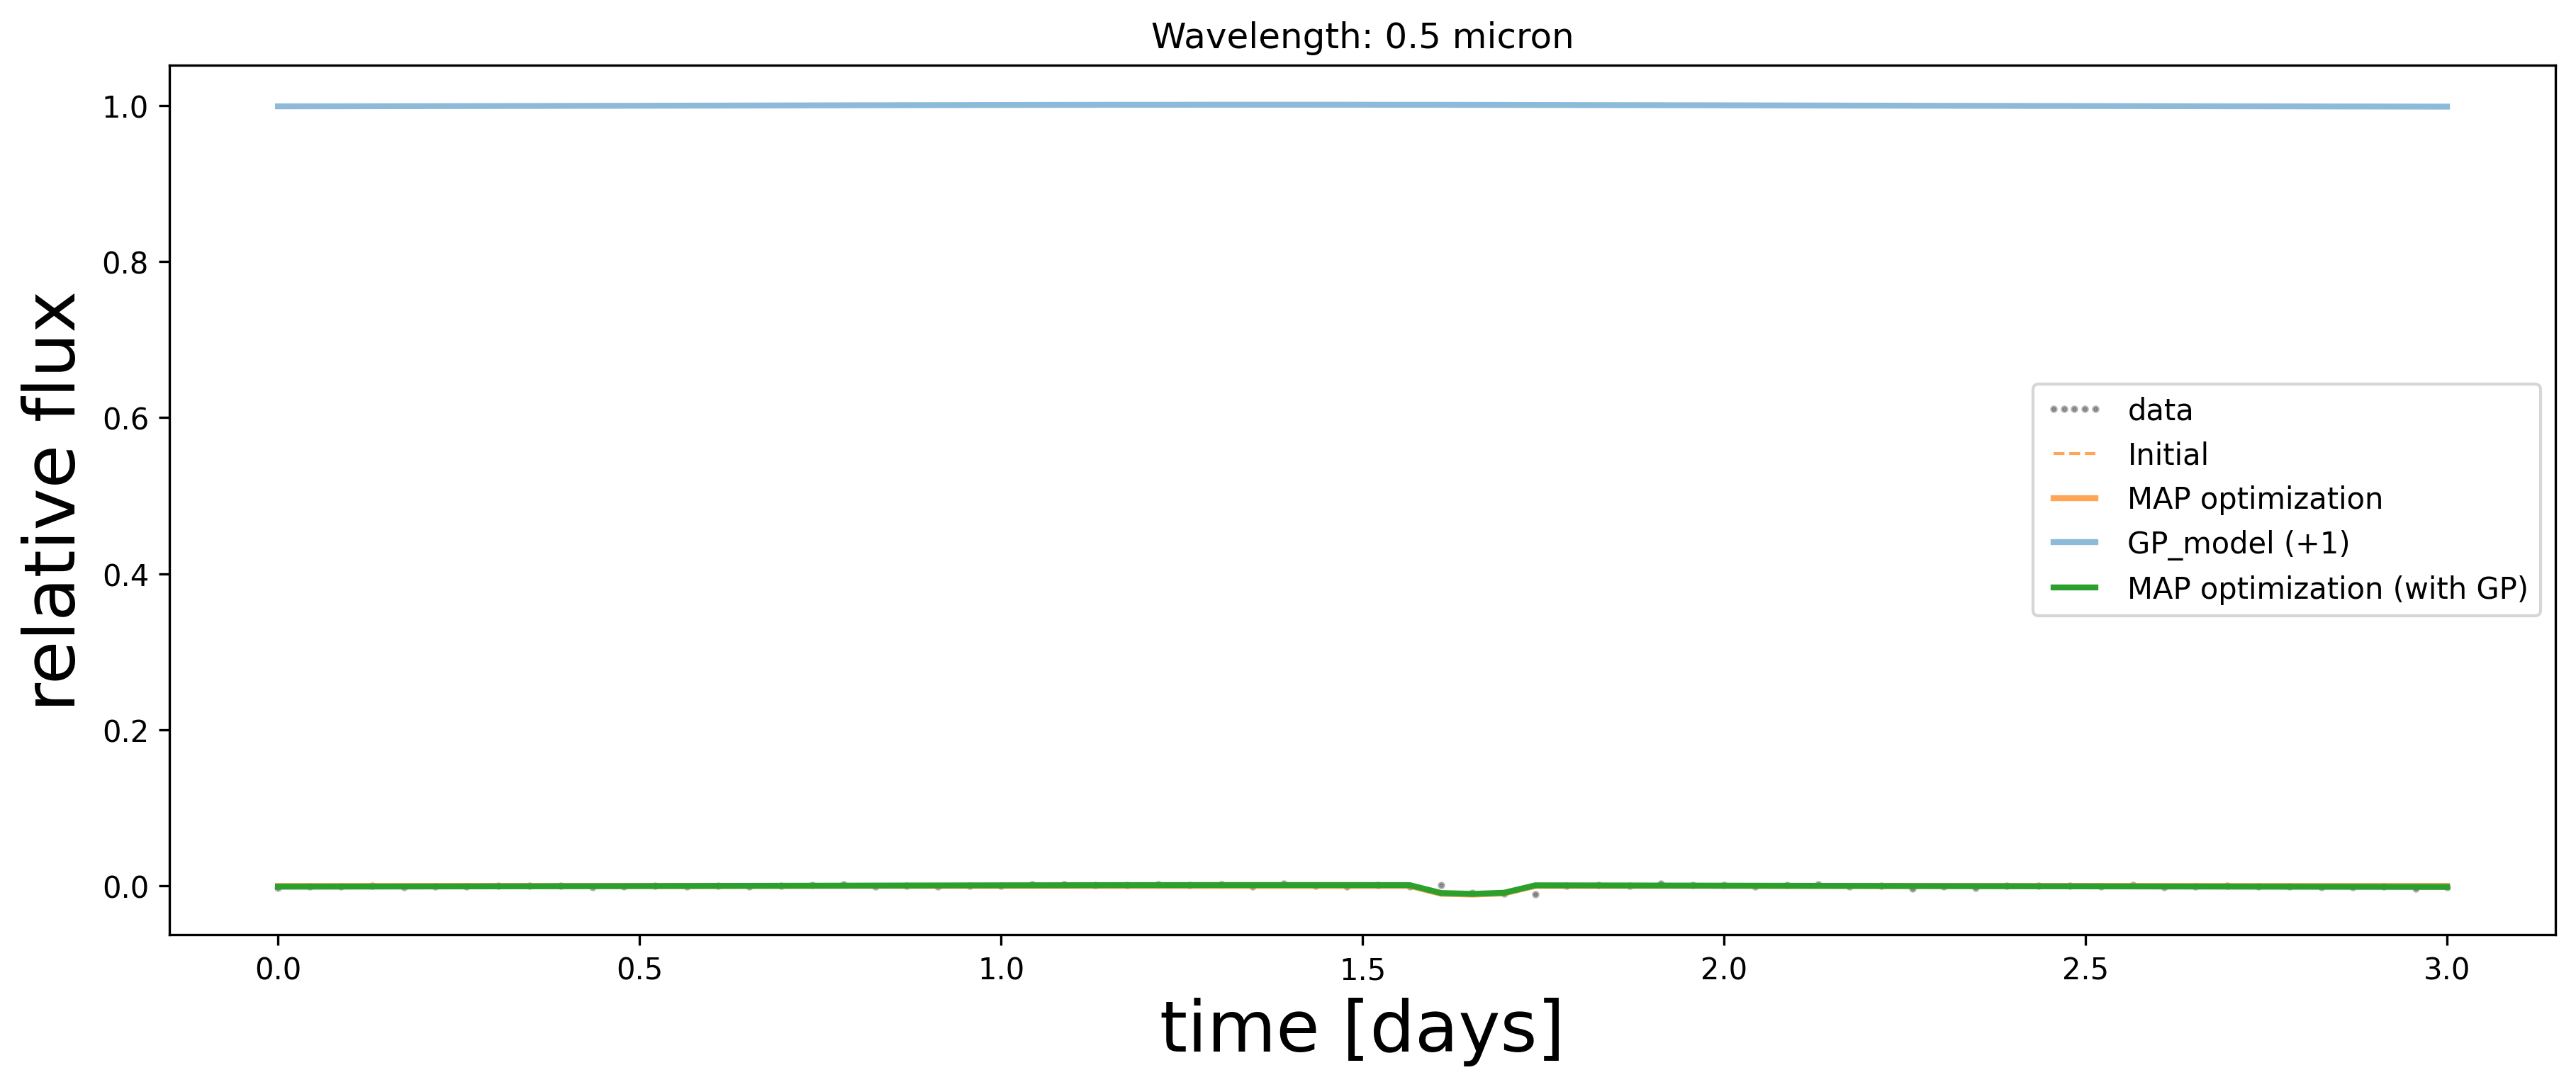

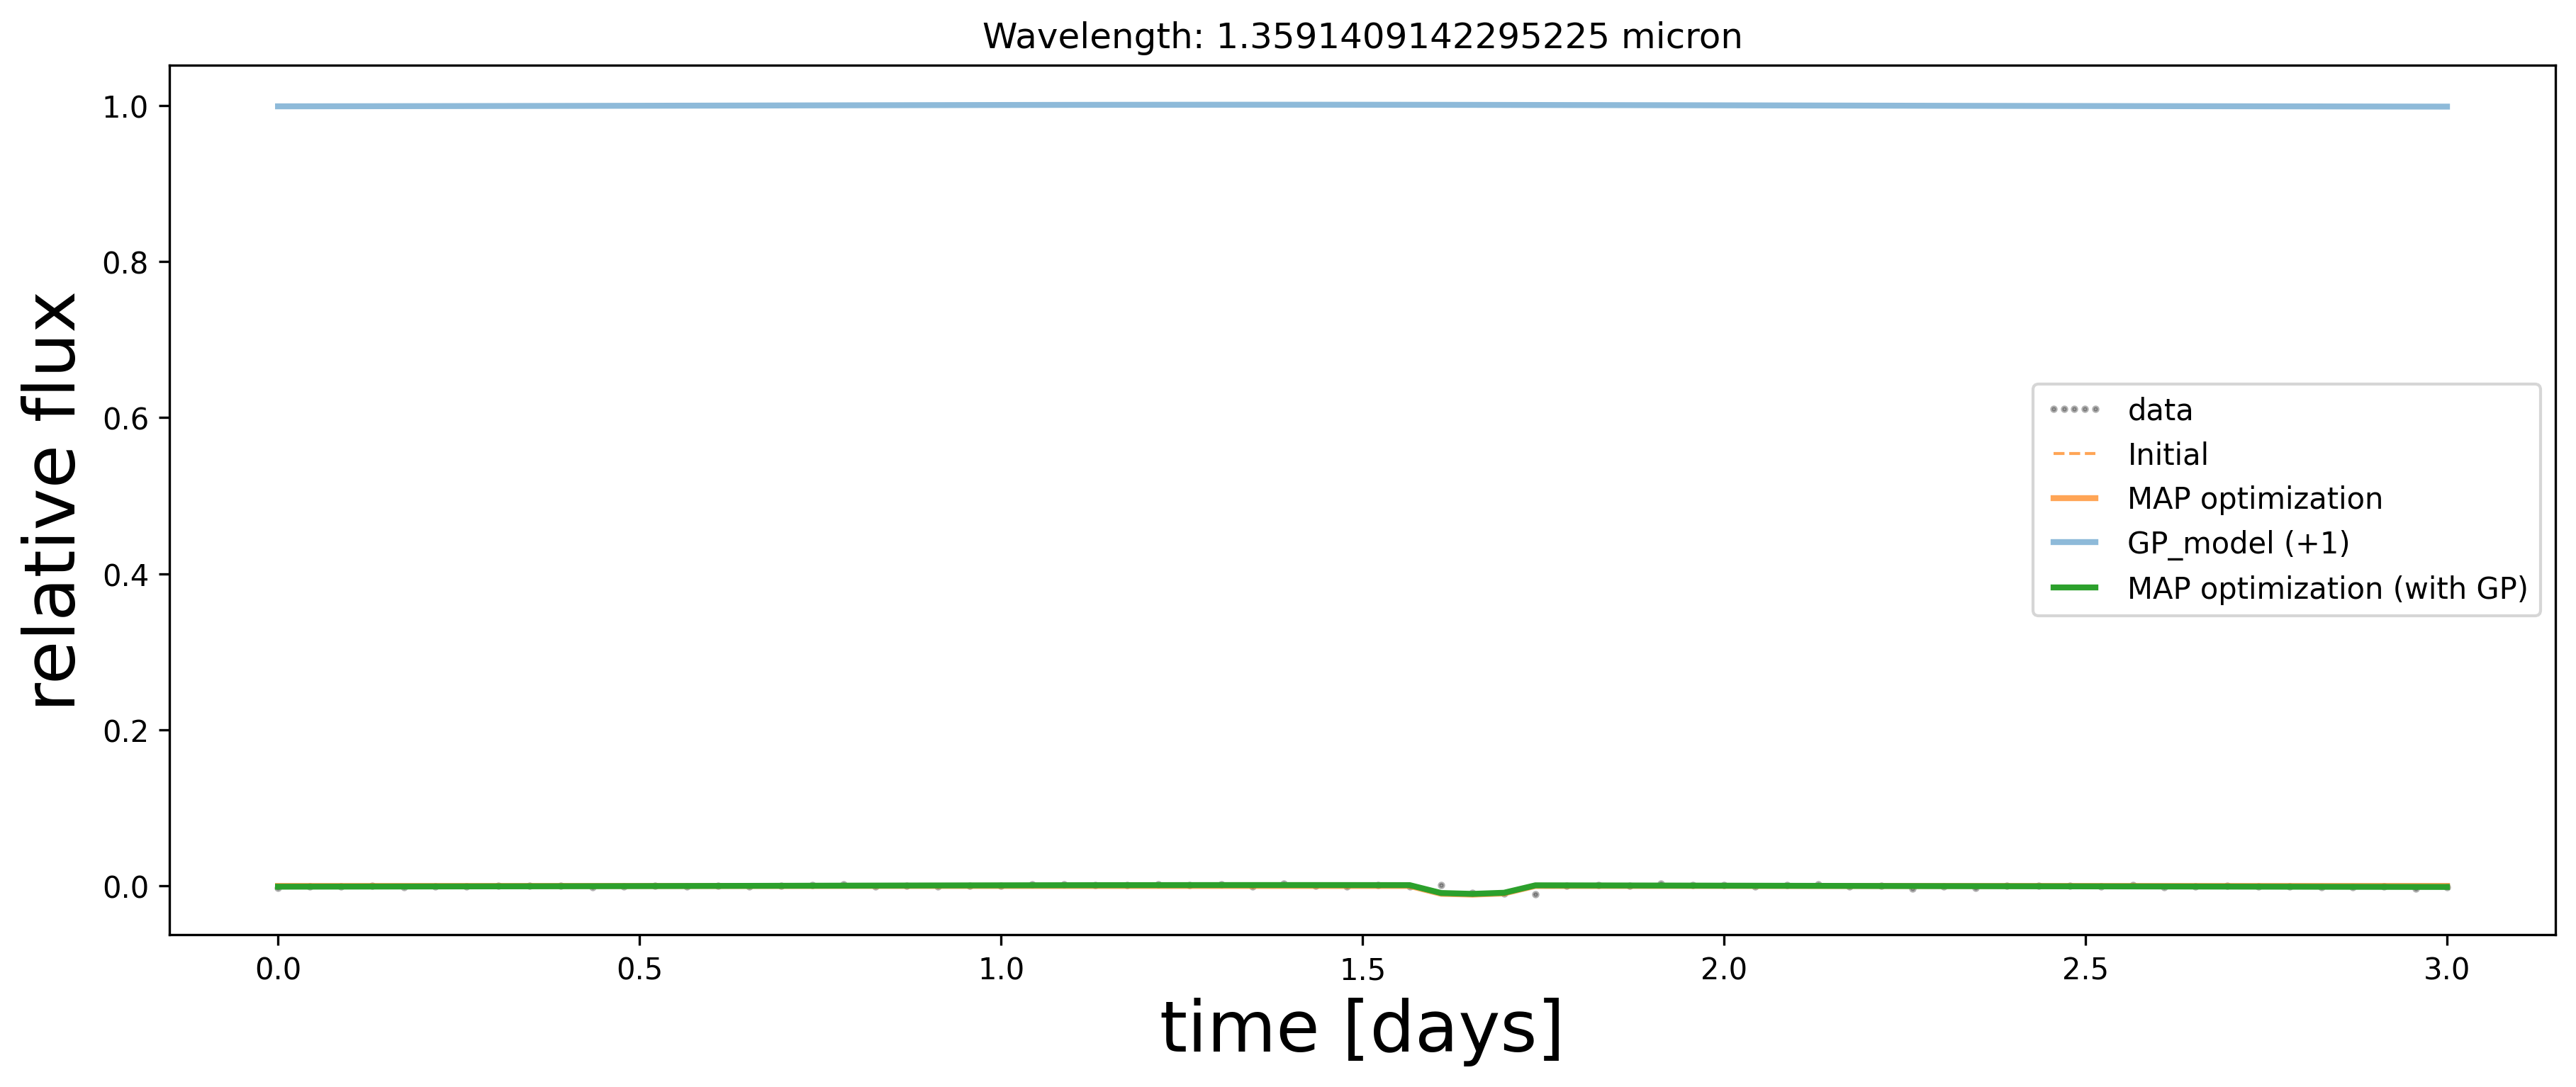

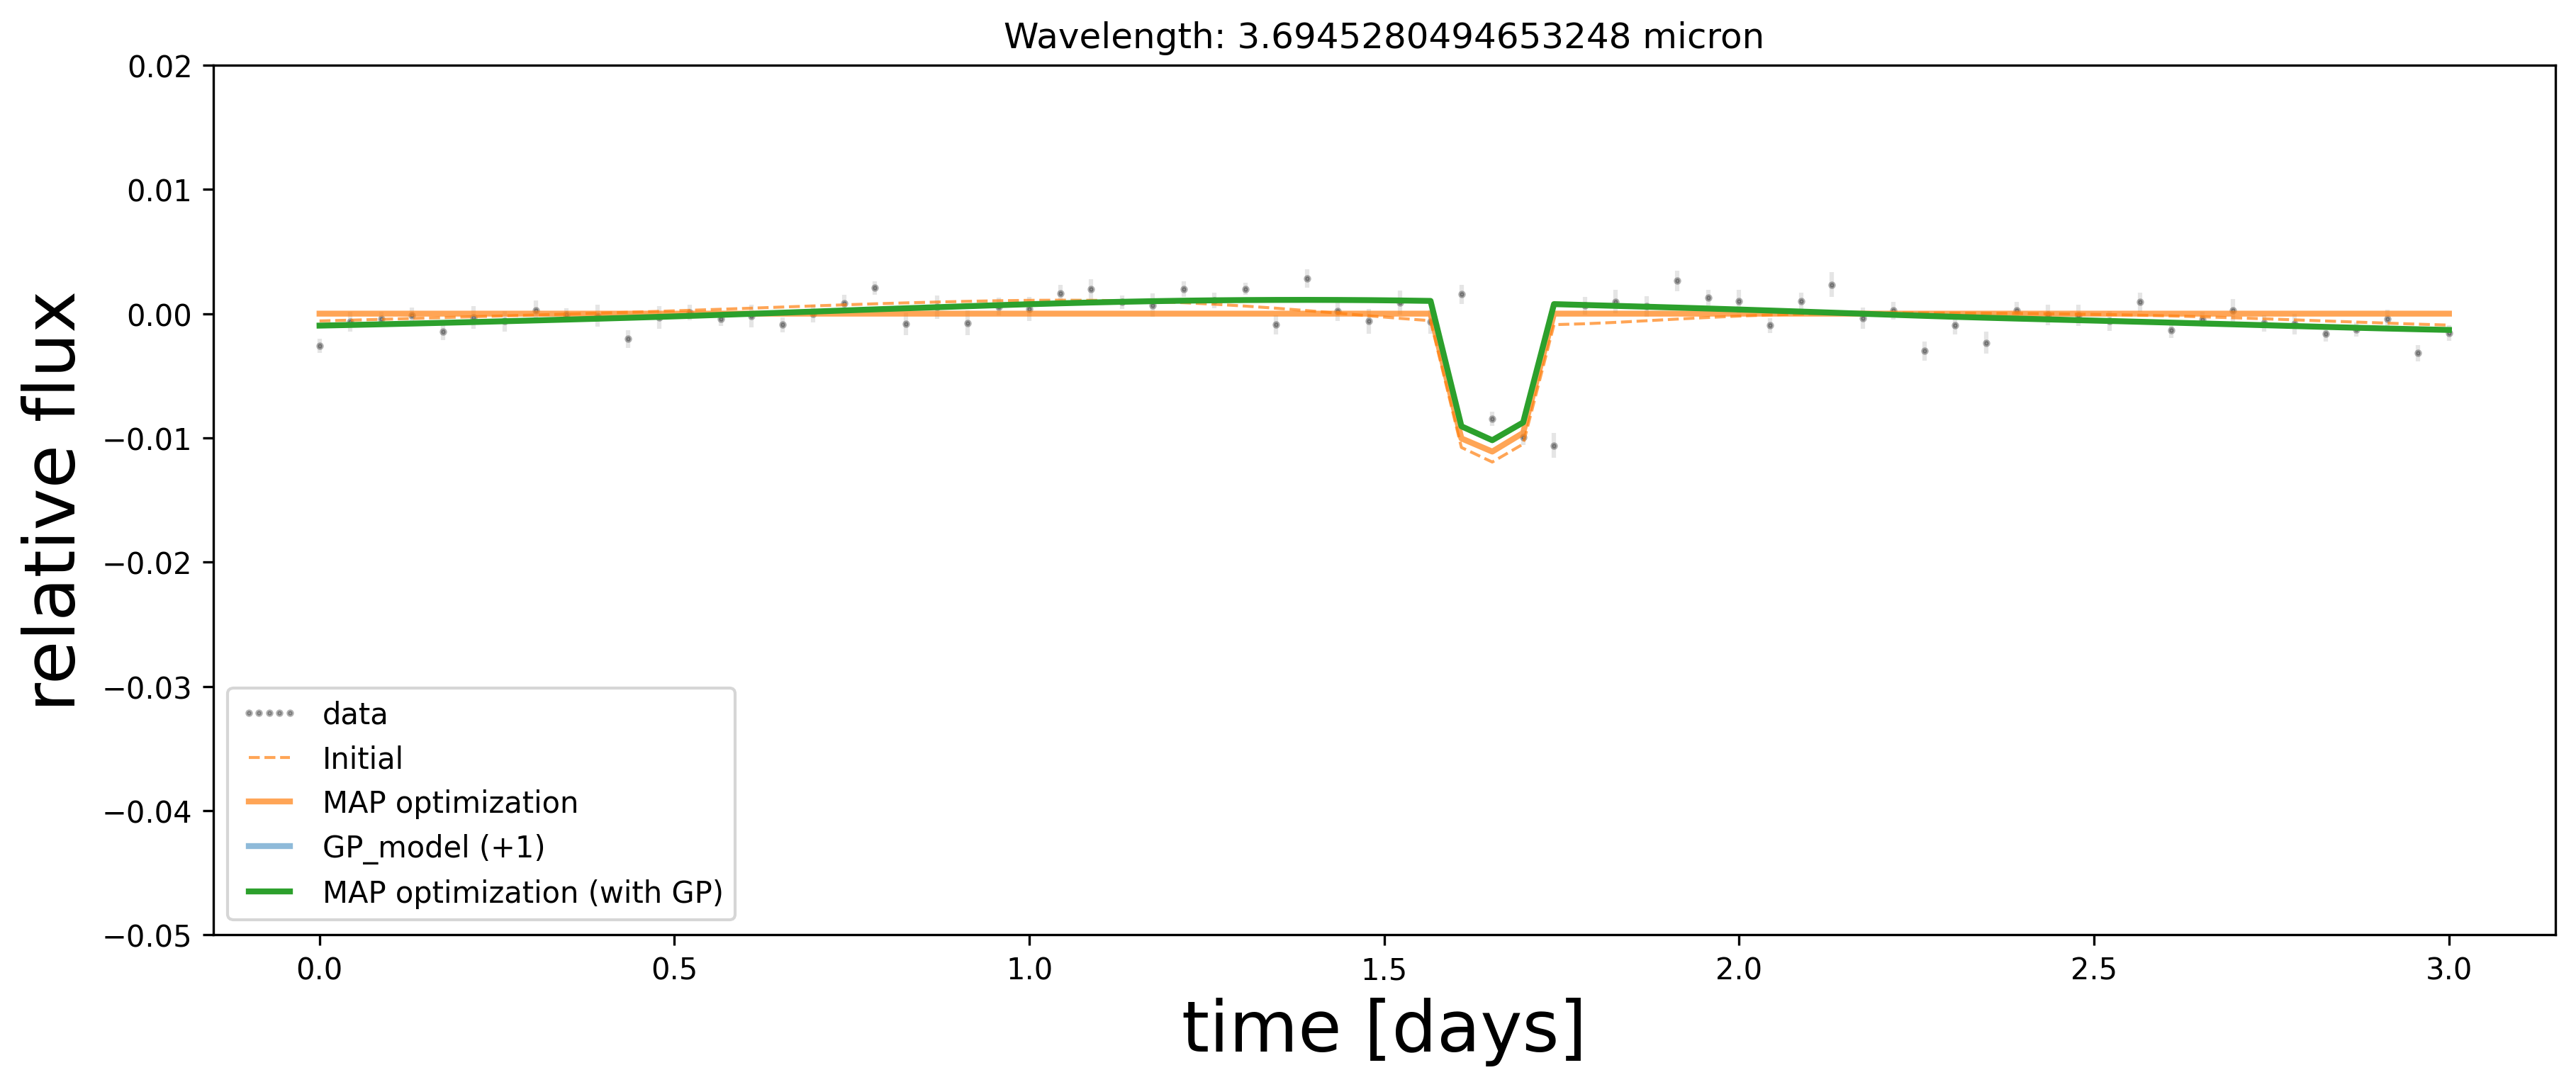

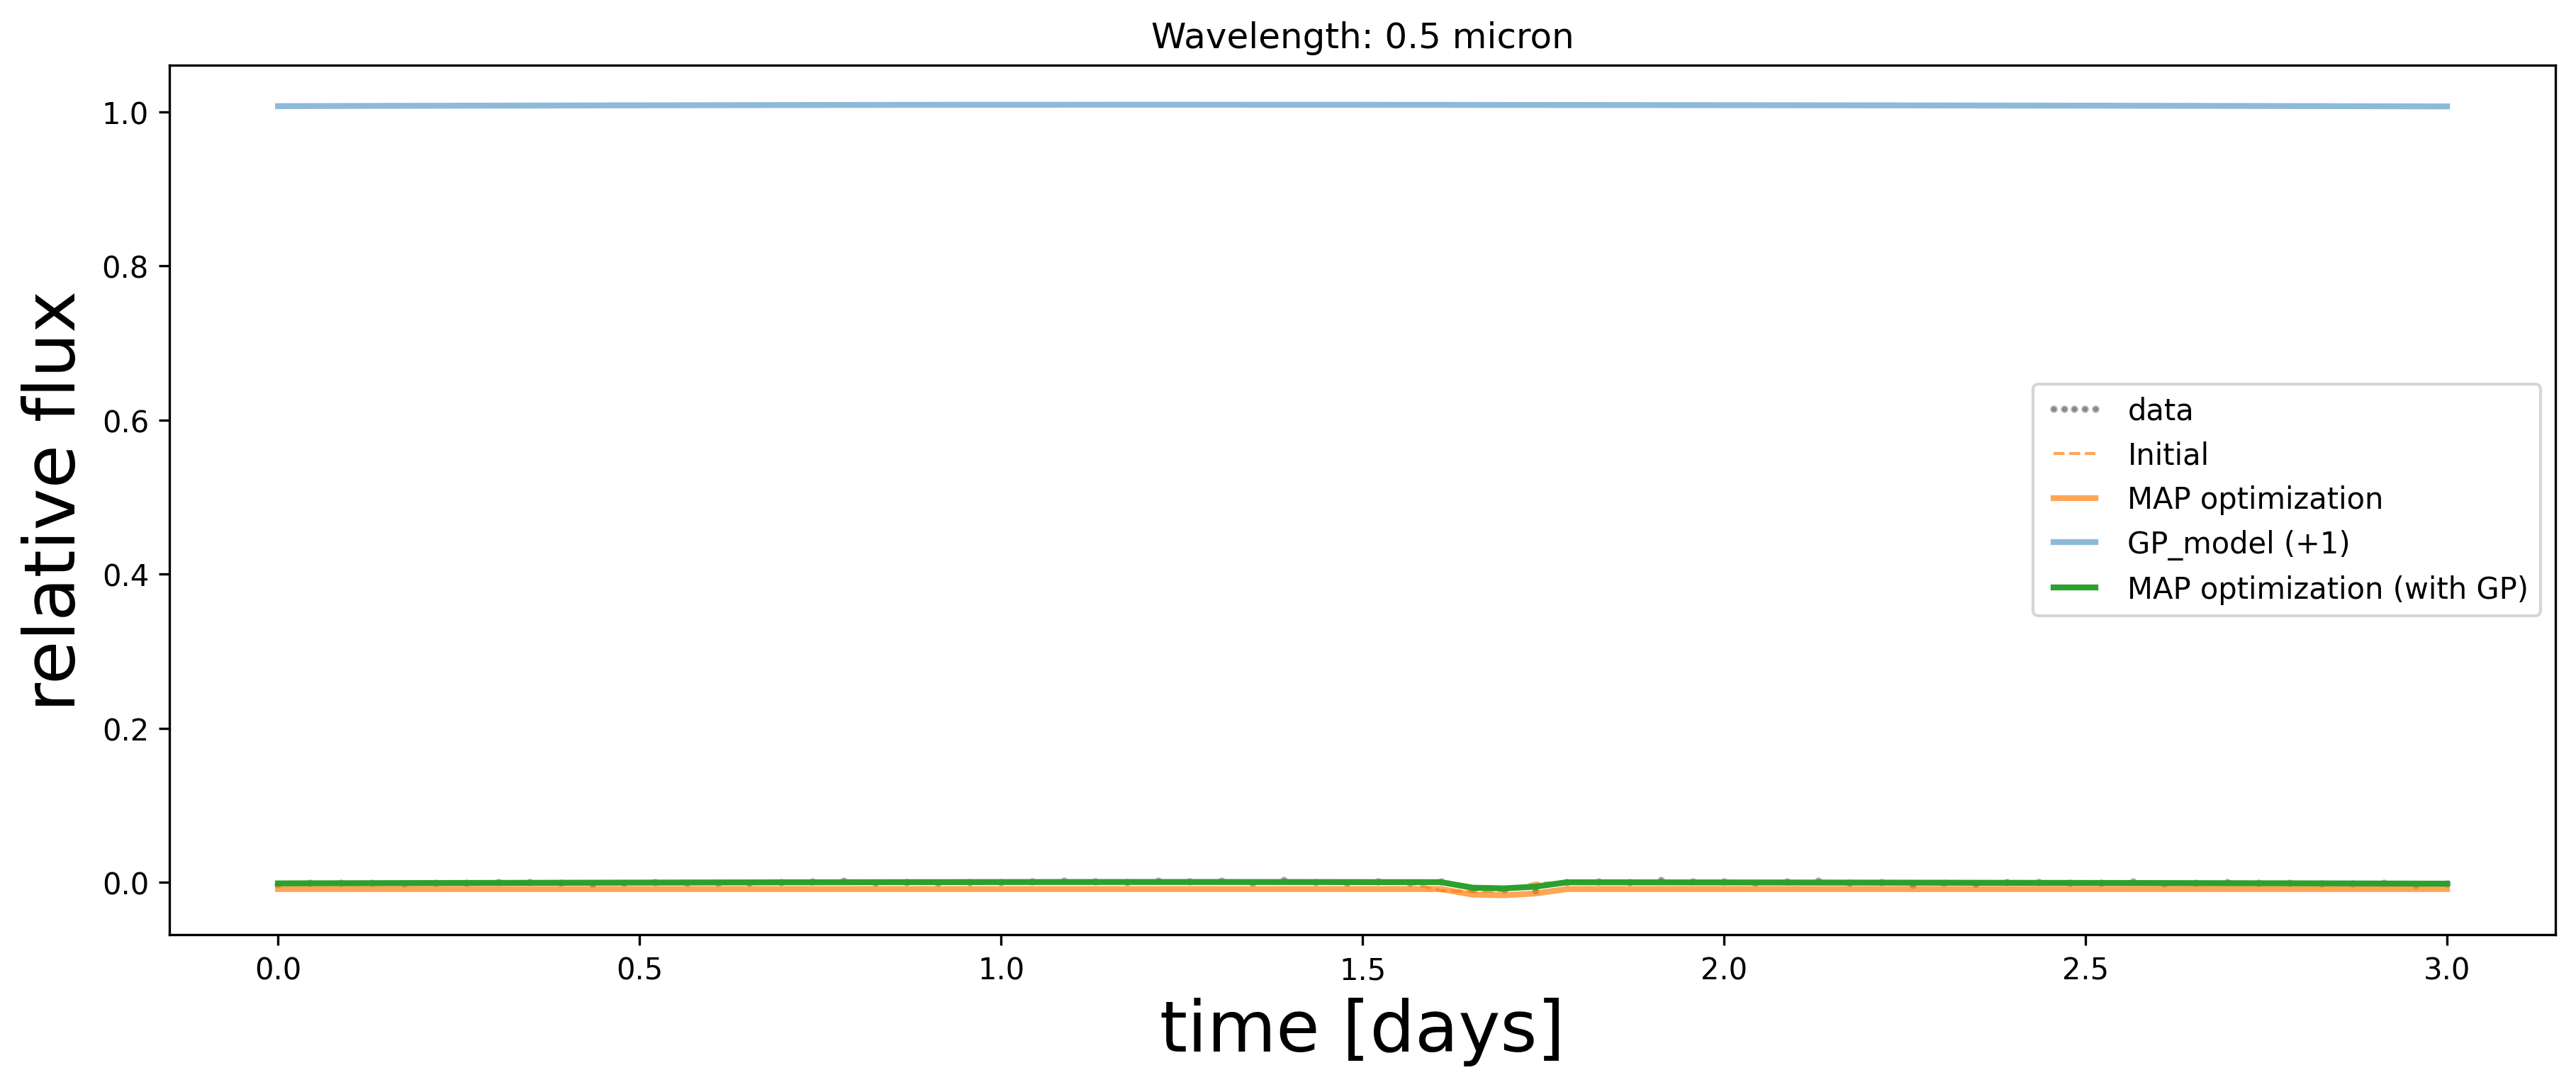

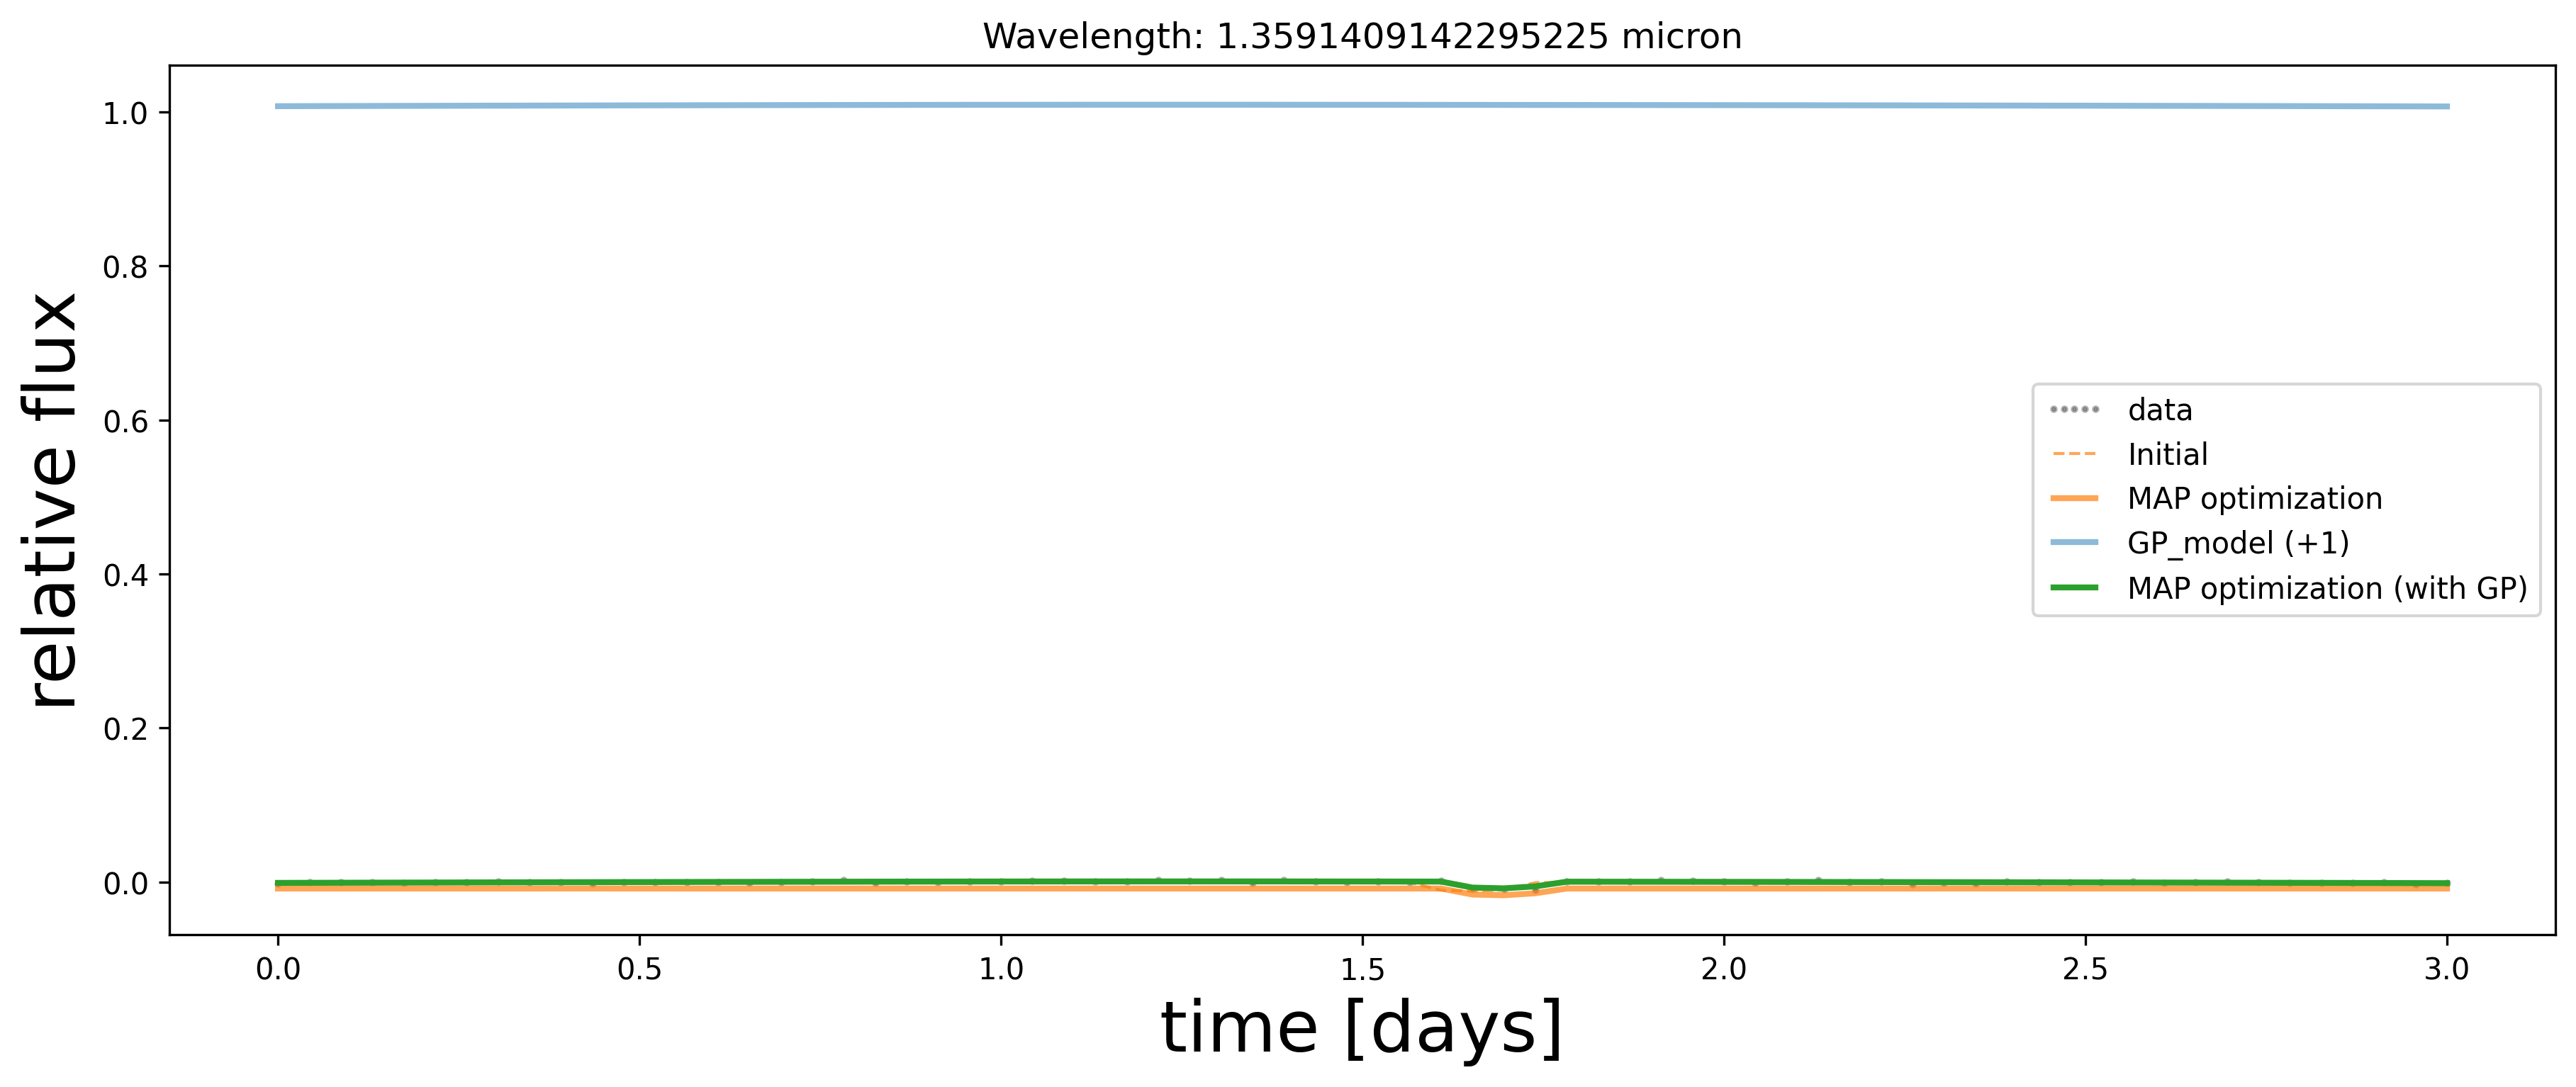

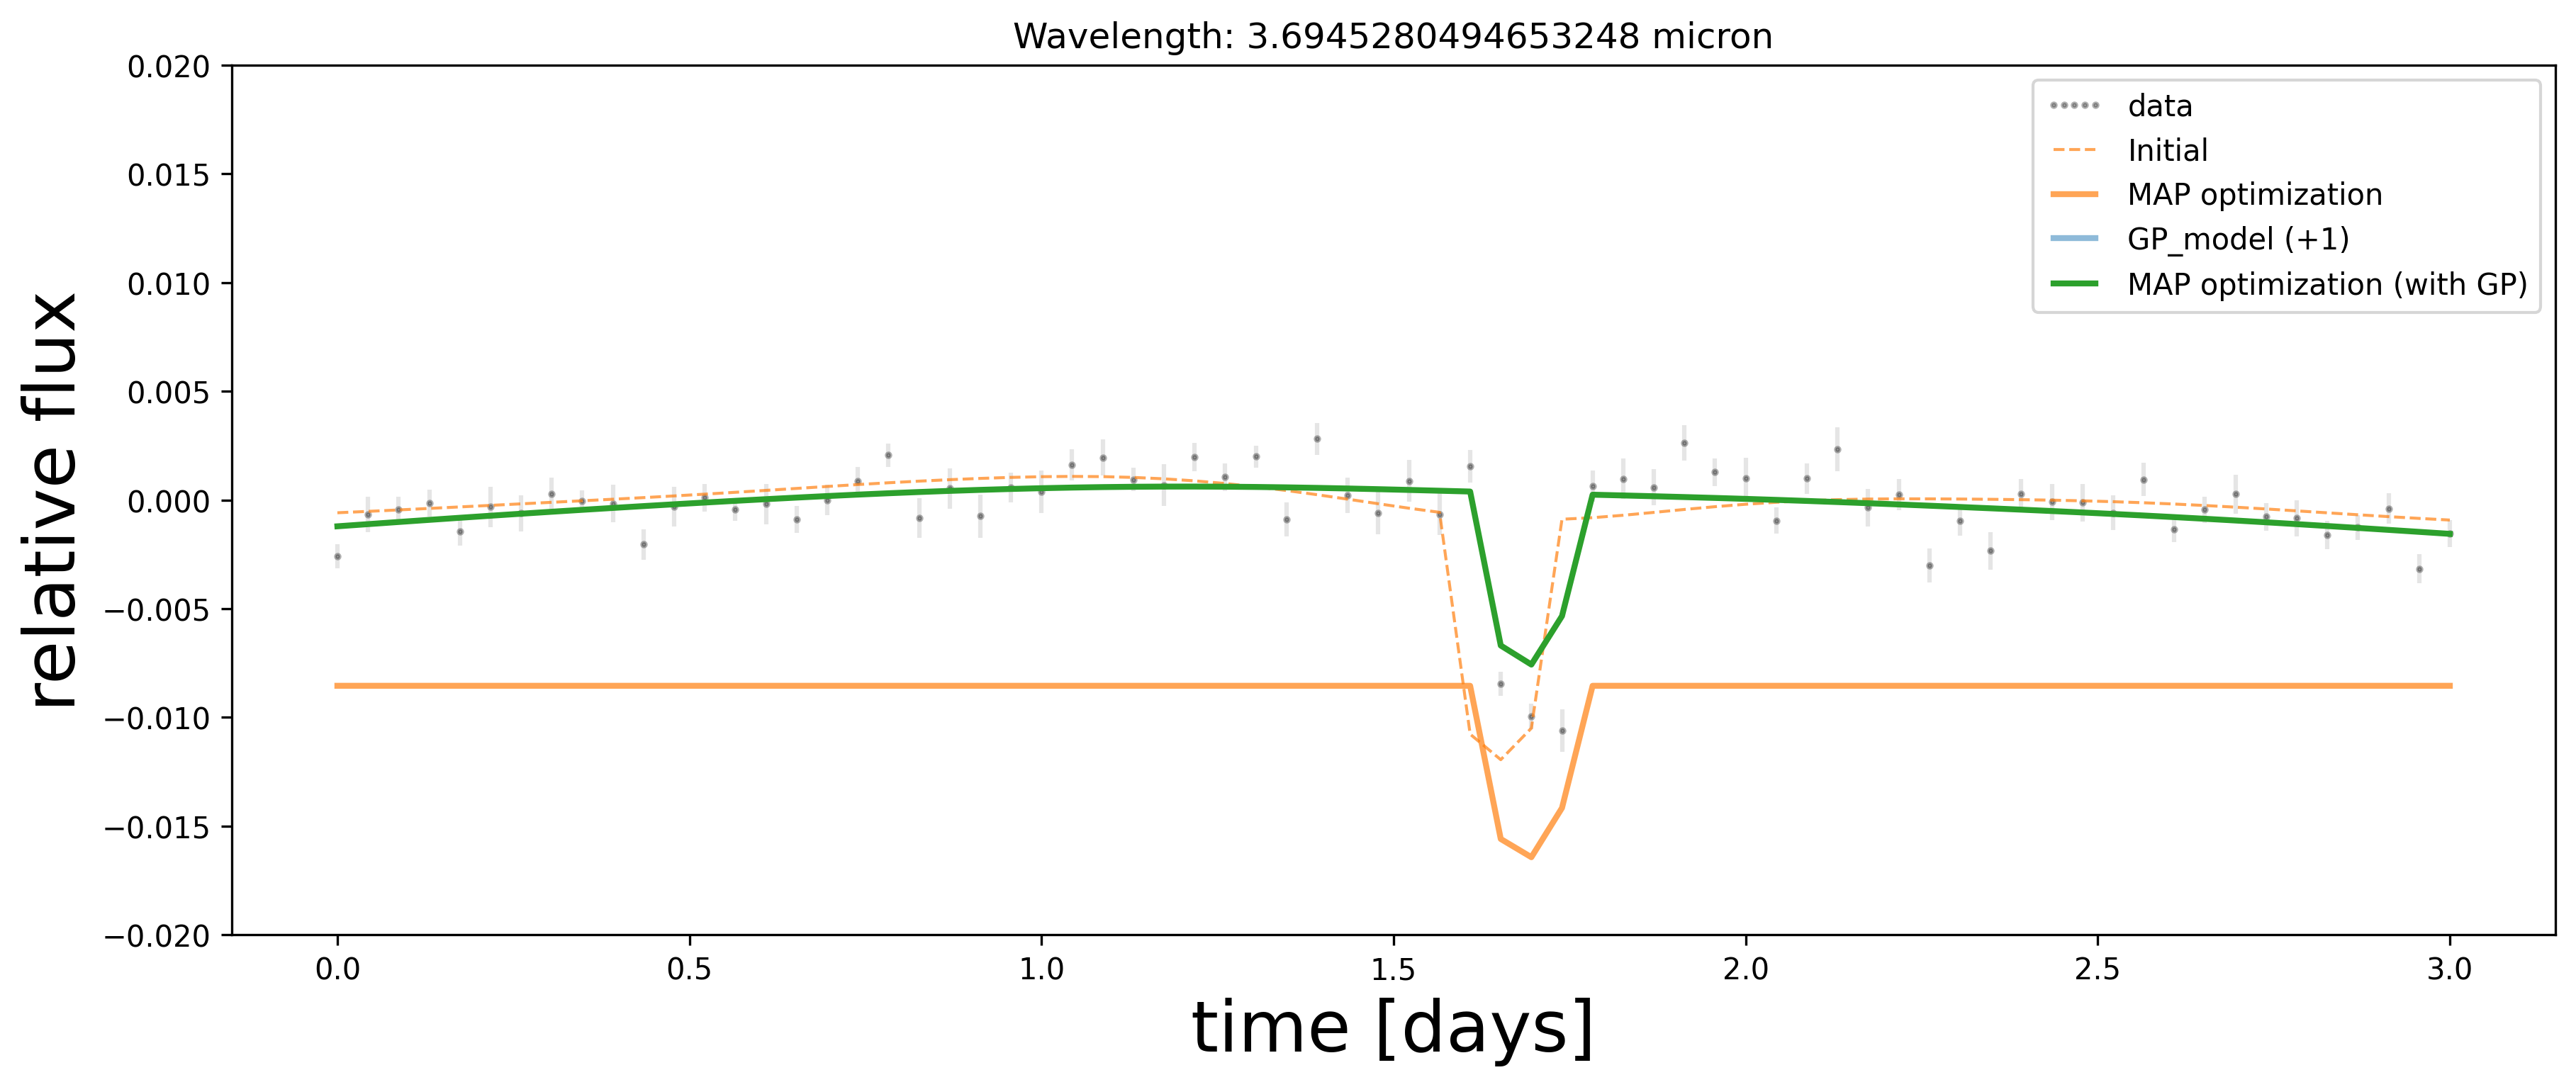

In [53]:
# optimize for initial values!
# opt = p.optimize(plot=True)
# plt.ylim(-0.02,0.02)

params_gp = p._chromatic_models['rot'].parameters
params_tr = p._chromatic_models['transit'].parameters
map_soln = p._pymc3_model.test_point

map_soln = p.optimize( plot=True, start=map_soln, 
                          vars=[params_tr['transit_stellar_radius'].get_prior_vector(), 
                                  params_tr['transit_radius_ratio'].get_prior_vector(), 
                                  params_tr['transit_epoch'].get_prior_vector(),
                                 params_tr['transit_stellar_mass'].get_prior_vector(),
                                params_tr['transit_baseline'].get_prior_vector(),
                               params_tr['transit_limb_darkening'].get_prior_vector()]
        )
plt.ylim(-0.05,0.02)
print(map_soln)

opt = p.optimize(plot=True, start=map_soln)
plt.ylim(-0.02,0.02)

# # map_soln = p.optimize(plot=True, start=map_soln,
# #                       vars=[params_gp['periodic_sigma'].get_prior_vector(), 
# #                                   params_gp['periodic_rho'].get_prior_vector(), 
# #                                   params_gp['periodic_tau'].get_prior_vector()]
# #          )
# # print(map_soln)
# # plt.ylim(-0.02,0.02)

# gp_model = p.generate_gp_model_from_params(params=map_soln)
# opt_y = eval_in_model(p.every_light_curve['wavelength_0'],model=p._pymc3_model)[0]
# mu, variance = eval_in_model(gp_model.predict(p.data.flux[0] - opt_y, t=p.data.time, return_var=True), model=p._pymc3_model)

TypeError: object of type 'TensorVariable' has no len()

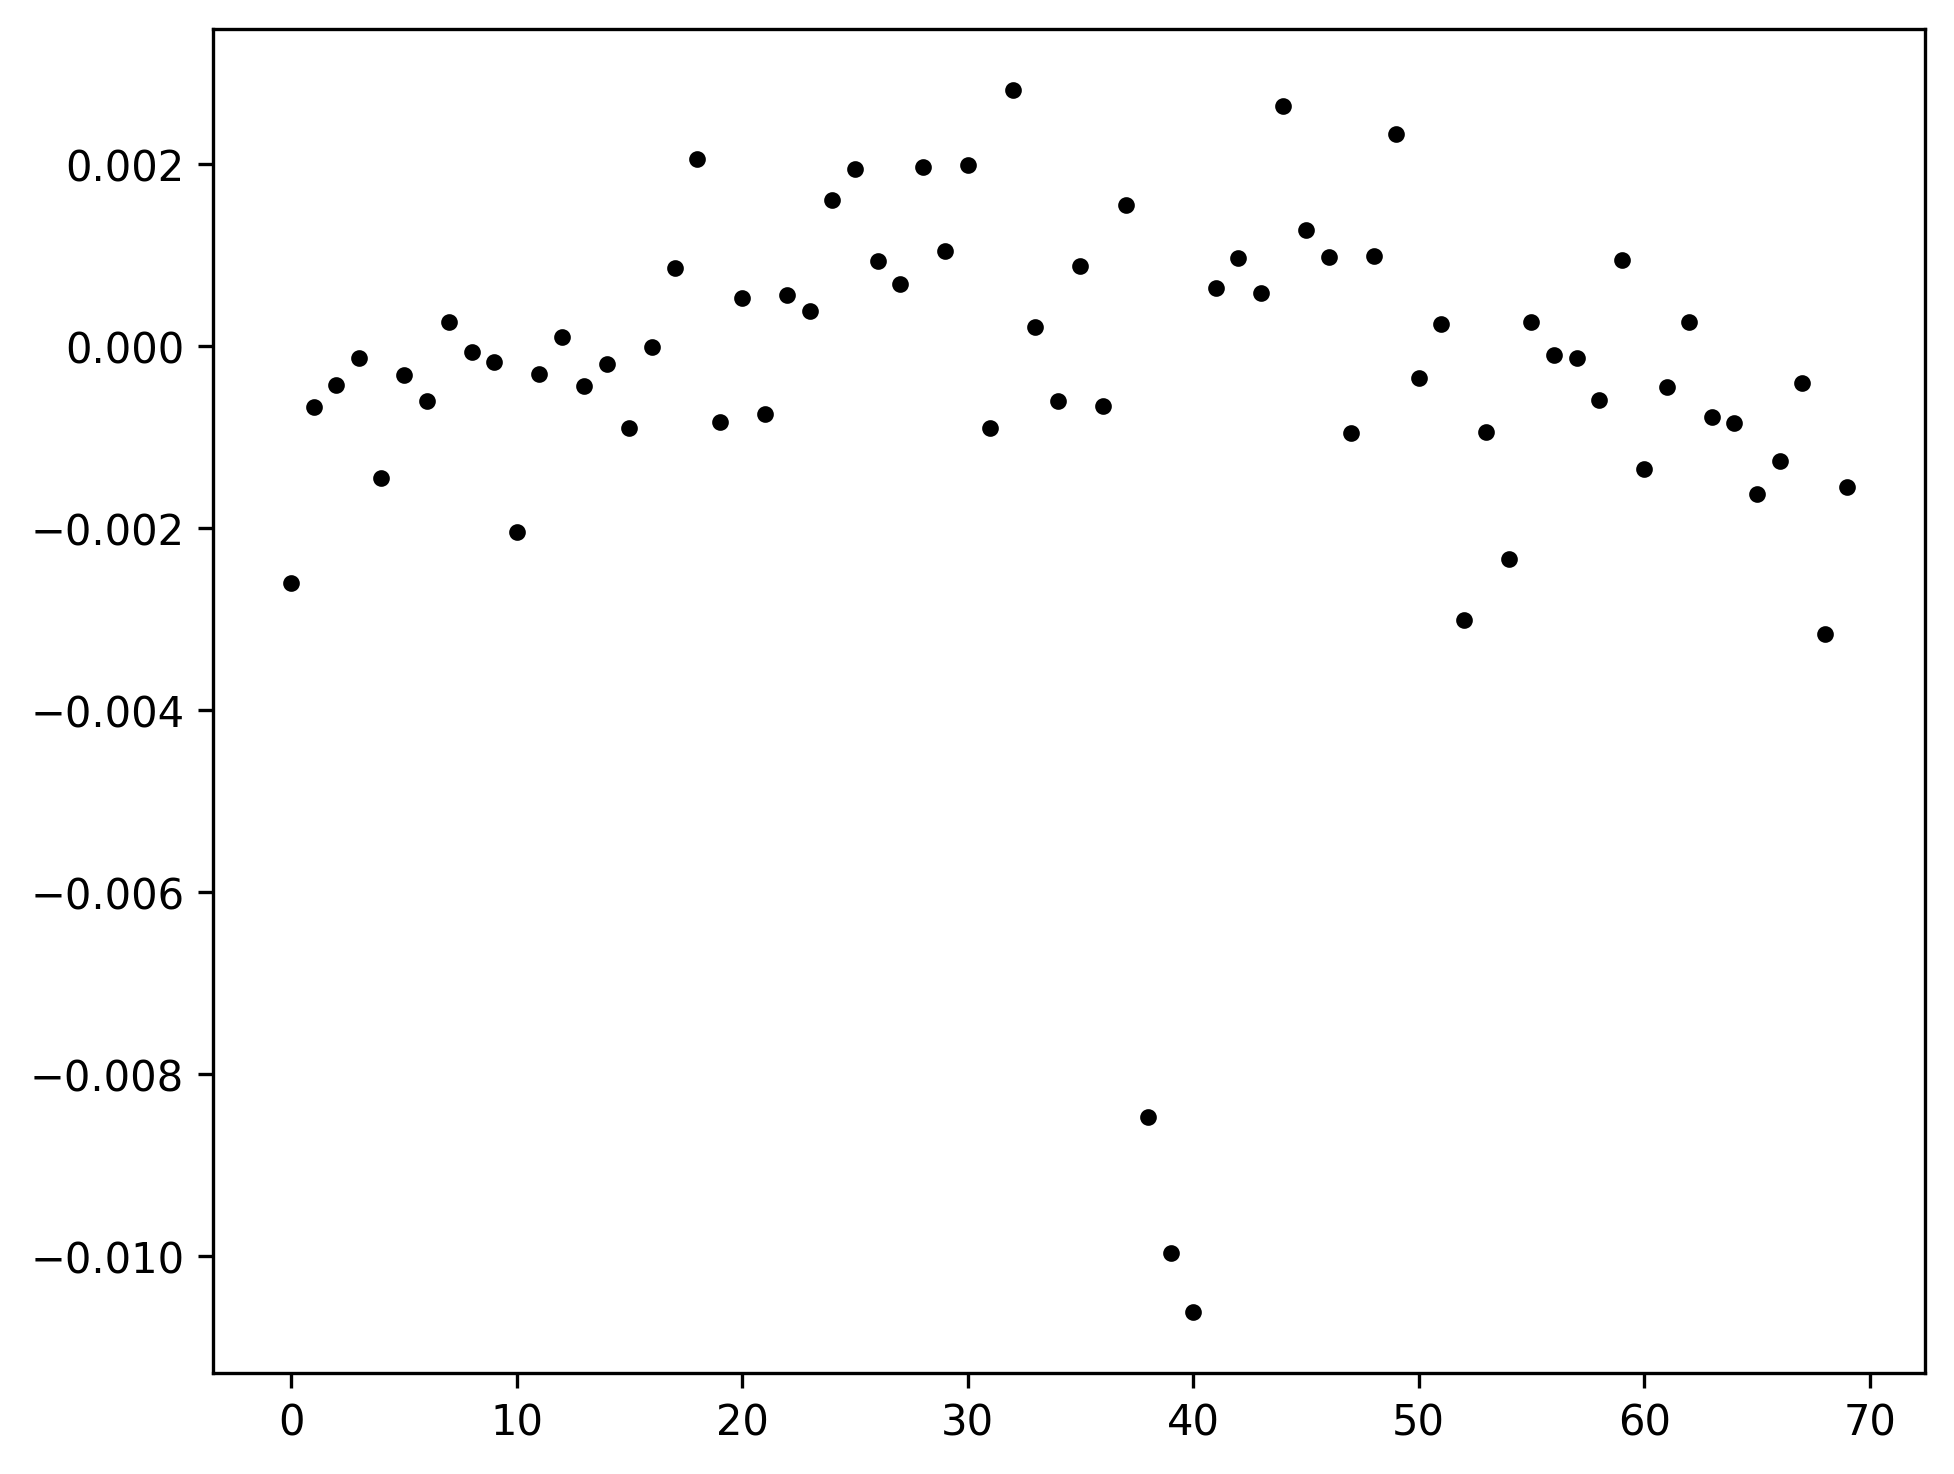

In [117]:
plt.plot(p.data.flux[0], 'k.')
plt.plot(mu)

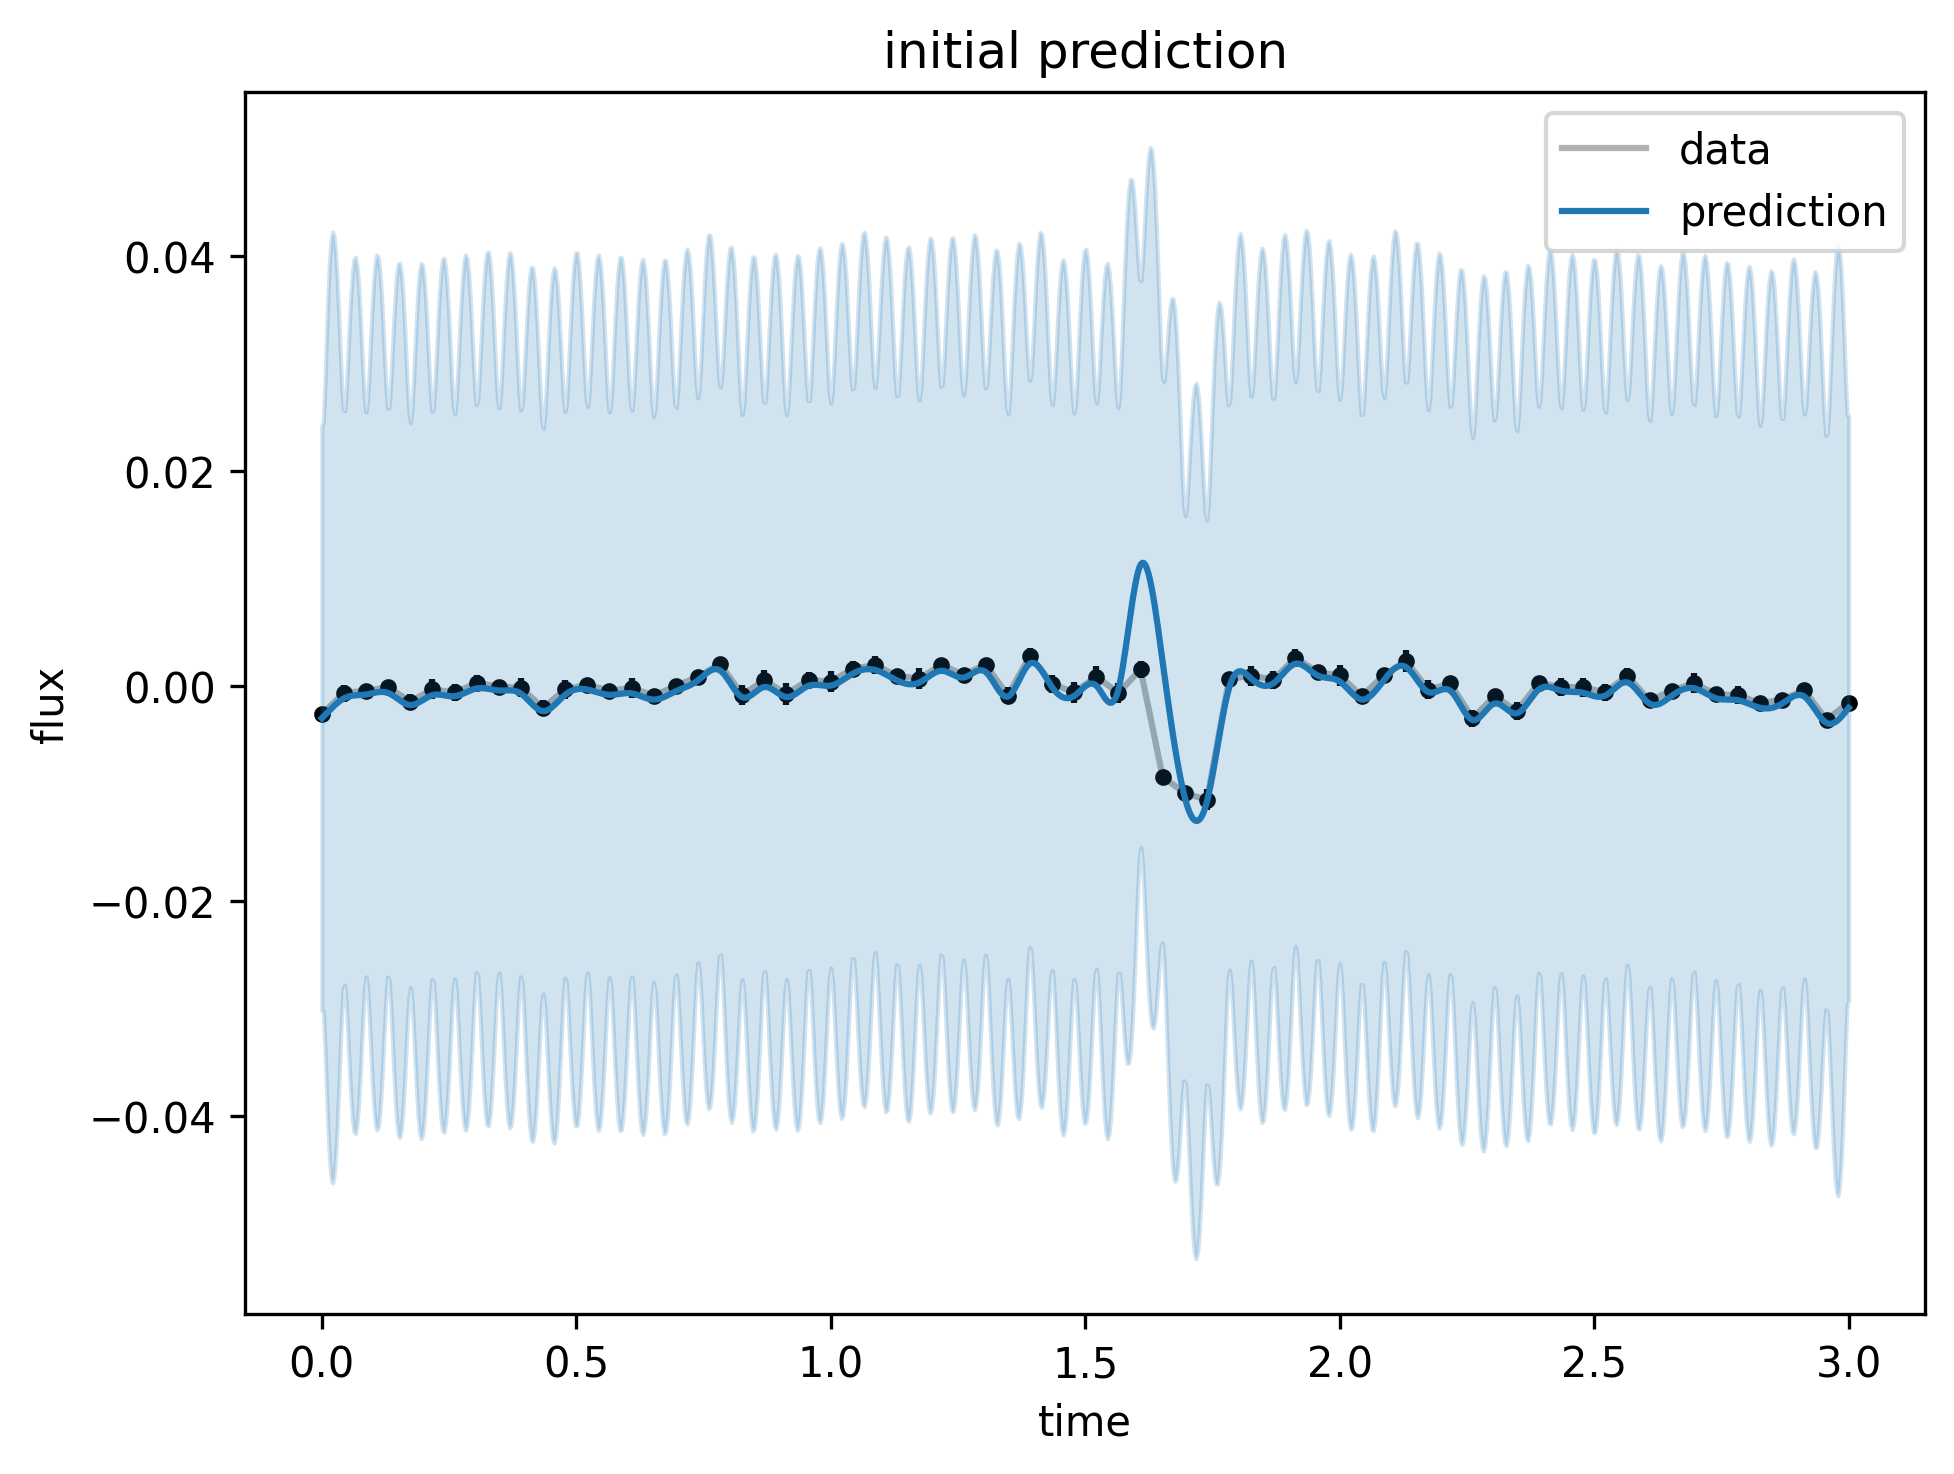

In [118]:
plt.title("initial prediction")
p.plot_prediction(p.gp[0])

In [ ]:
plt.title("MAP-opt prediction")
p.plot_prediction(p.generate_gp_model_from_params(params=opt), plot_var=True, legend=False)

In [485]:
with pm.Model() as pmmodel:
    # Quasi-periodic term
    kernel = terms.SHOTerm(sigma=pm.Normal('sigma', mu=1.0, sd=2), 
                           rho=pm.Normal('rho', mu=2.0, sd=2), 
                           tau=pm.Normal('tau', mu=10.0, sd=2))
    
    # Setup the GP
    gp = GaussianProcess(kernel, mean=0.0)
    gp.compute(t=t, yerr=p.data.uncertainty[0])

    # initial_params = [0.0, 1.0, 2.0, 10.0, np.log(0.01)]
    # soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
    # opt_gp = set_params(soln.x, gp)
    # soln

    opt = pmx.optimize()
    opt


optimizing logp for variables: [tau, rho, sigma]


message: Optimization terminated successfully.
logp: -4.836257141293855 -> -4.836257141293855


In [486]:
opt

{'sigma': array(1.), 'rho': array(2.), 'tau': array(10.)}

In [54]:
# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains.
p.sample(sampling_method=pmx.sample, start=opt, tune=2000, draws=4000, chains=4, cores=4, return_inferencedata=False)

Sampling model using the <function sample at 0x283a93280> method


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sin,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: InplaceDimShuffle{x,0}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{cos,no_inplace}.0
WARNING 

/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
/Users/catrionamurray/anaconda3/envs/chromatic_fitting_mp/lib/python3.9/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 262 seconds.
WARNING (theano.tensor.opt): Canno

                                   mean        sd    hdi_16%    hdi_84%  \
rot_sigma[0]                  -0.001707  0.003508  -0.005964  -0.000779   
rot_sigma[1]                  -0.003402  0.002107  -0.004046  -0.001271   
rot_sigma[2]                  -0.001647  0.003524  -0.005906  -0.000860   
rot_rho[0]                     9.205508  2.179328   7.151289  11.565722   
rot_tau[0]                     3.274128  1.442911   1.569877   4.445187   
log_jitter                   -14.456187  0.210326 -14.668042 -14.252536   
transit_epoch[0]               1.701604  0.003802   1.698109   1.705689   
transit_stellar_radius[0]      1.201496  0.114470   1.086360   1.315034   
transit_stellar_mass[0]        0.926407  0.192035   0.741671   1.124184   
transit_radius_ratio[0]        0.095370  0.004943   0.091485   0.101042   
transit_radius_ratio[1]        0.095325  0.004914   0.091028   0.100507   
transit_radius_ratio[2]        0.095357  0.004878   0.091190   0.100631   
transit_baseline[0]      

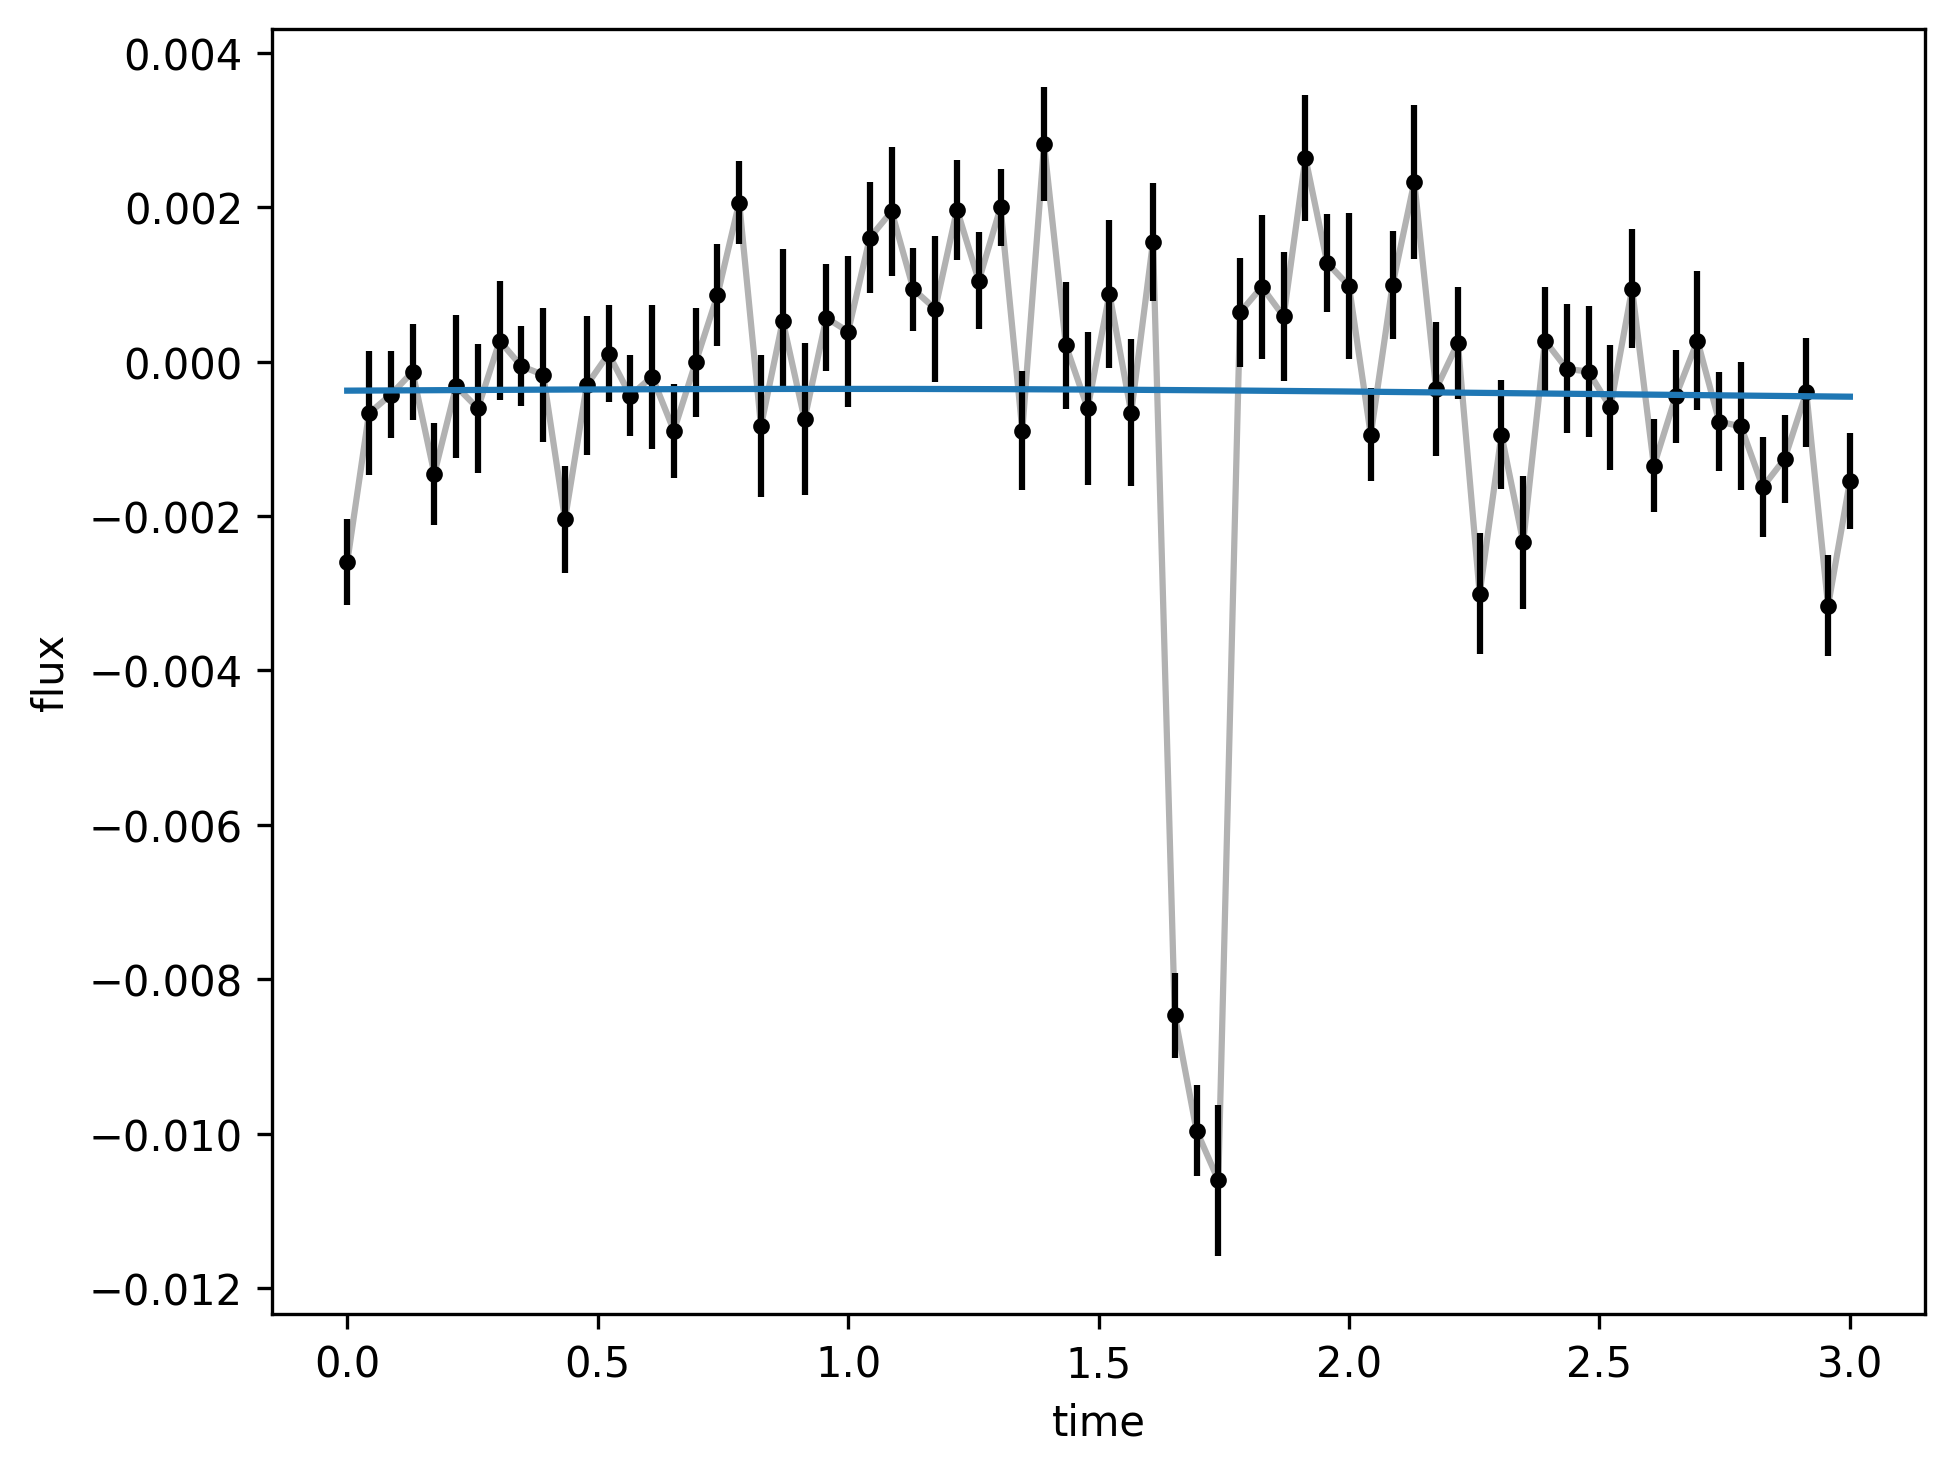

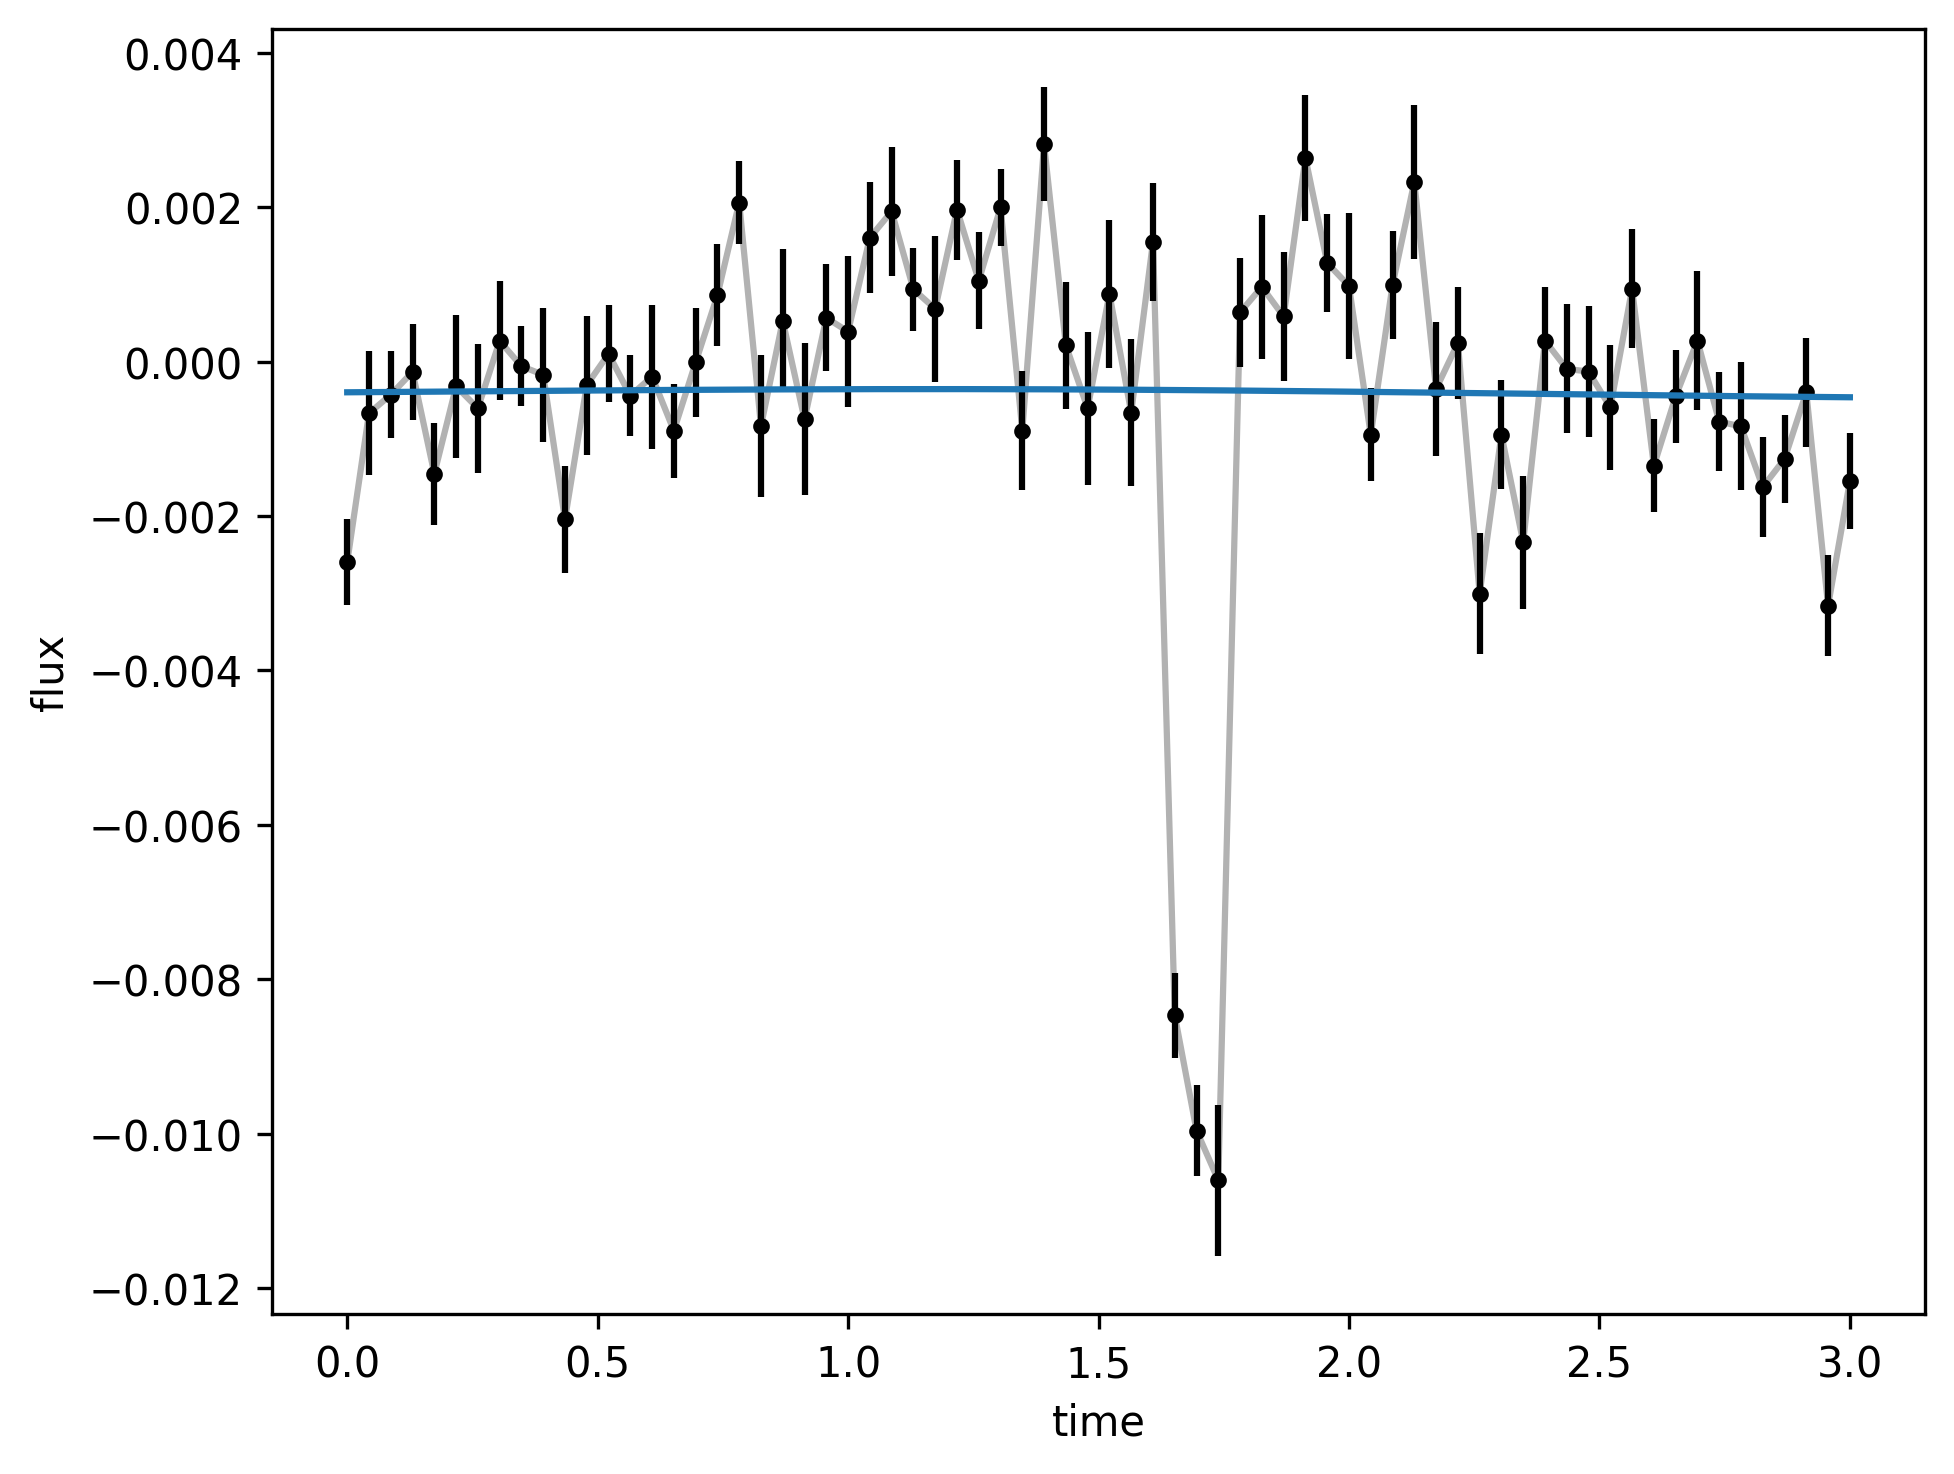

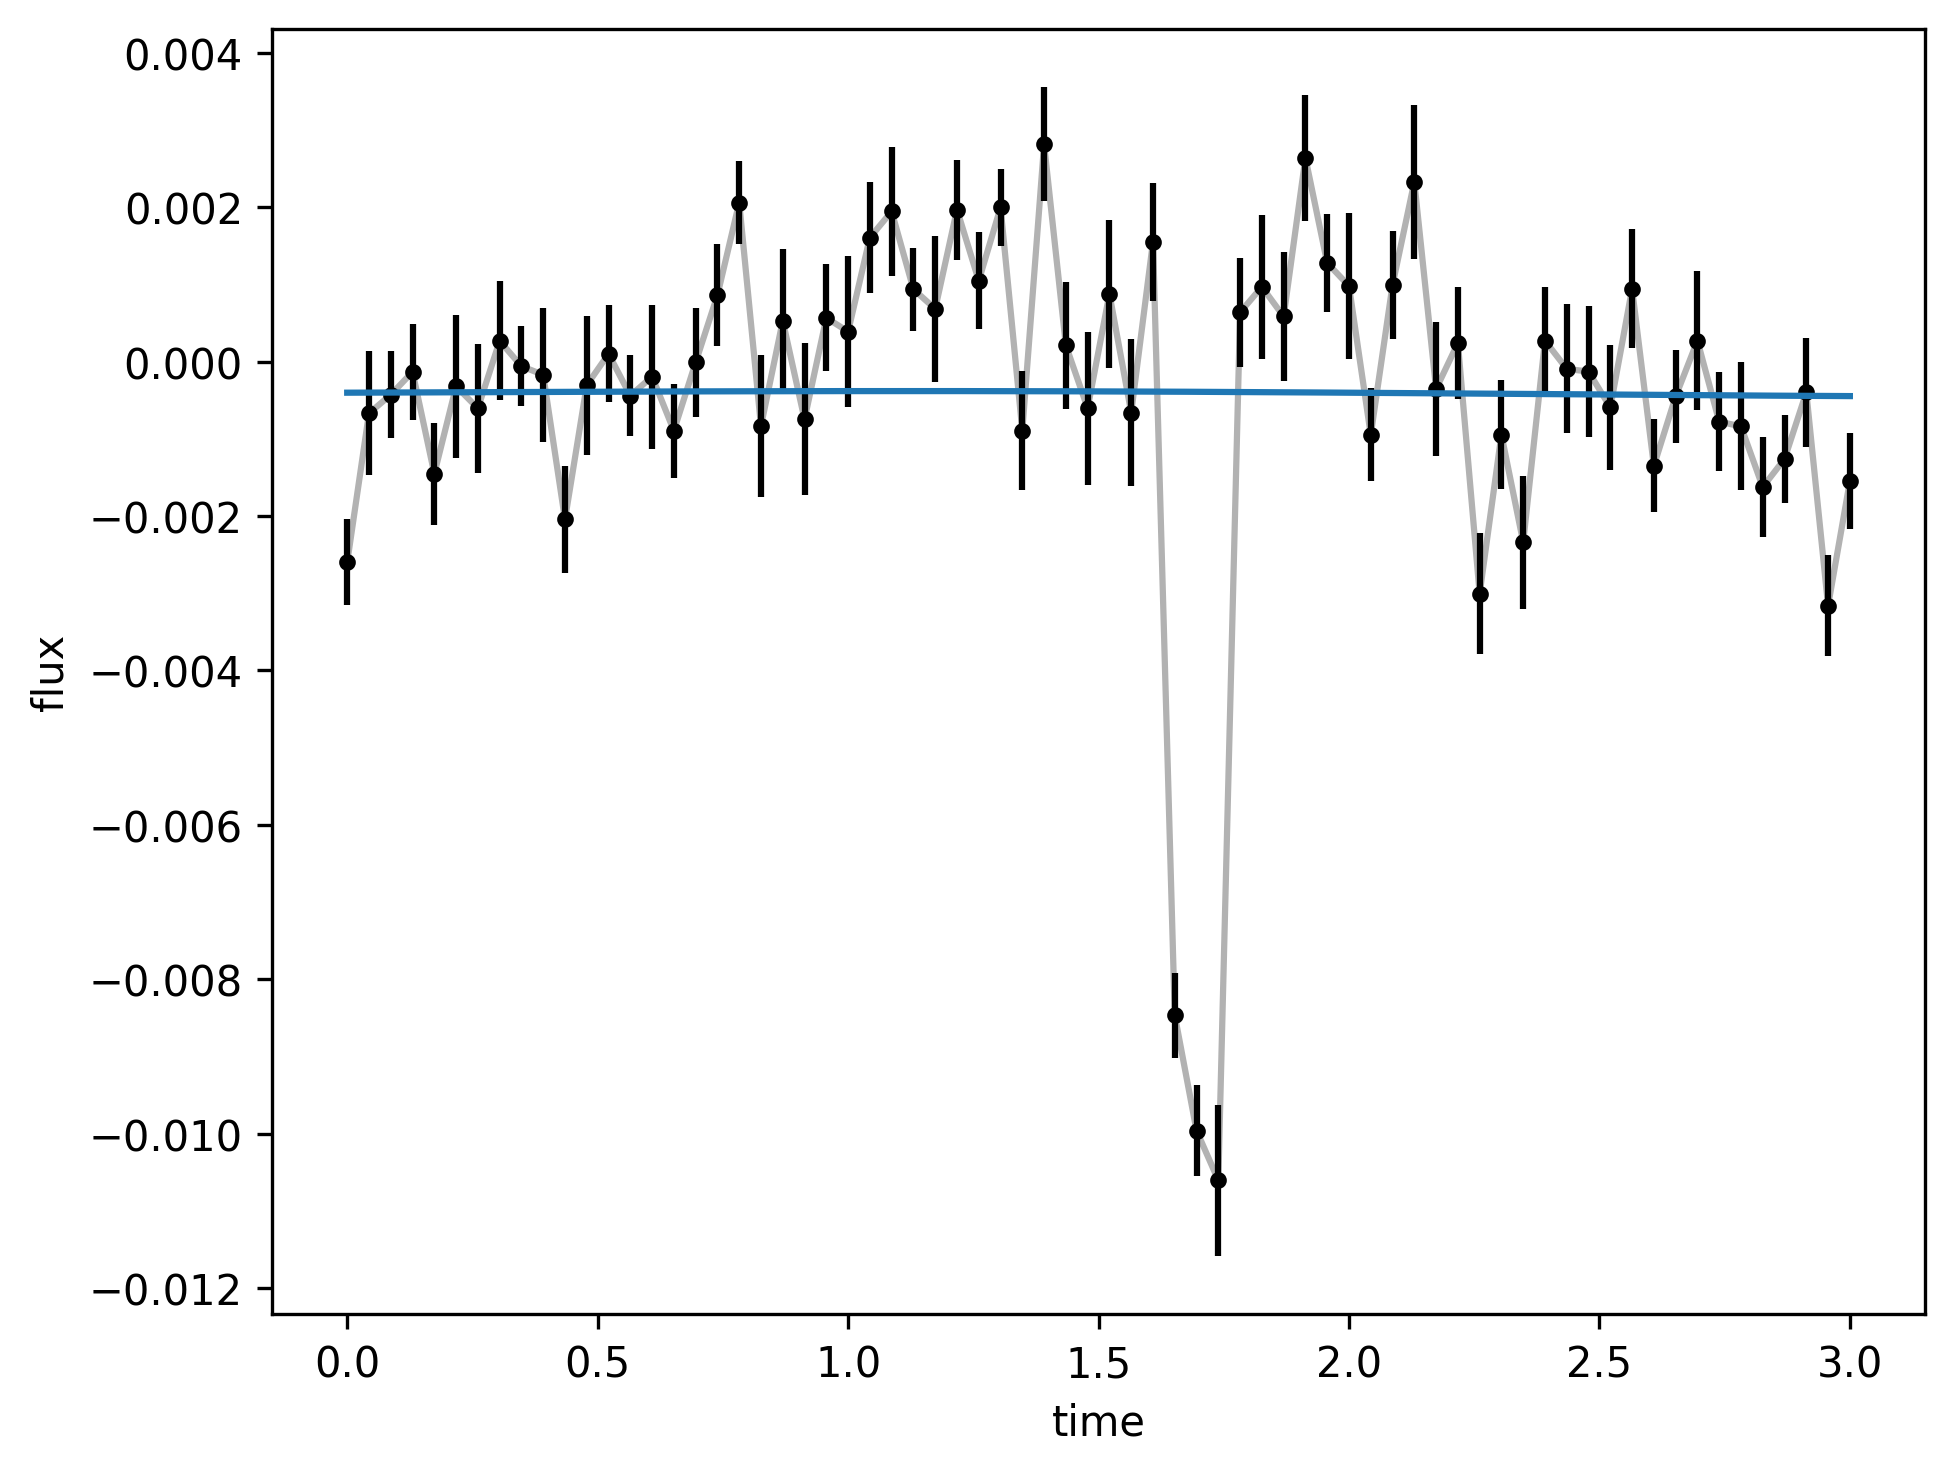

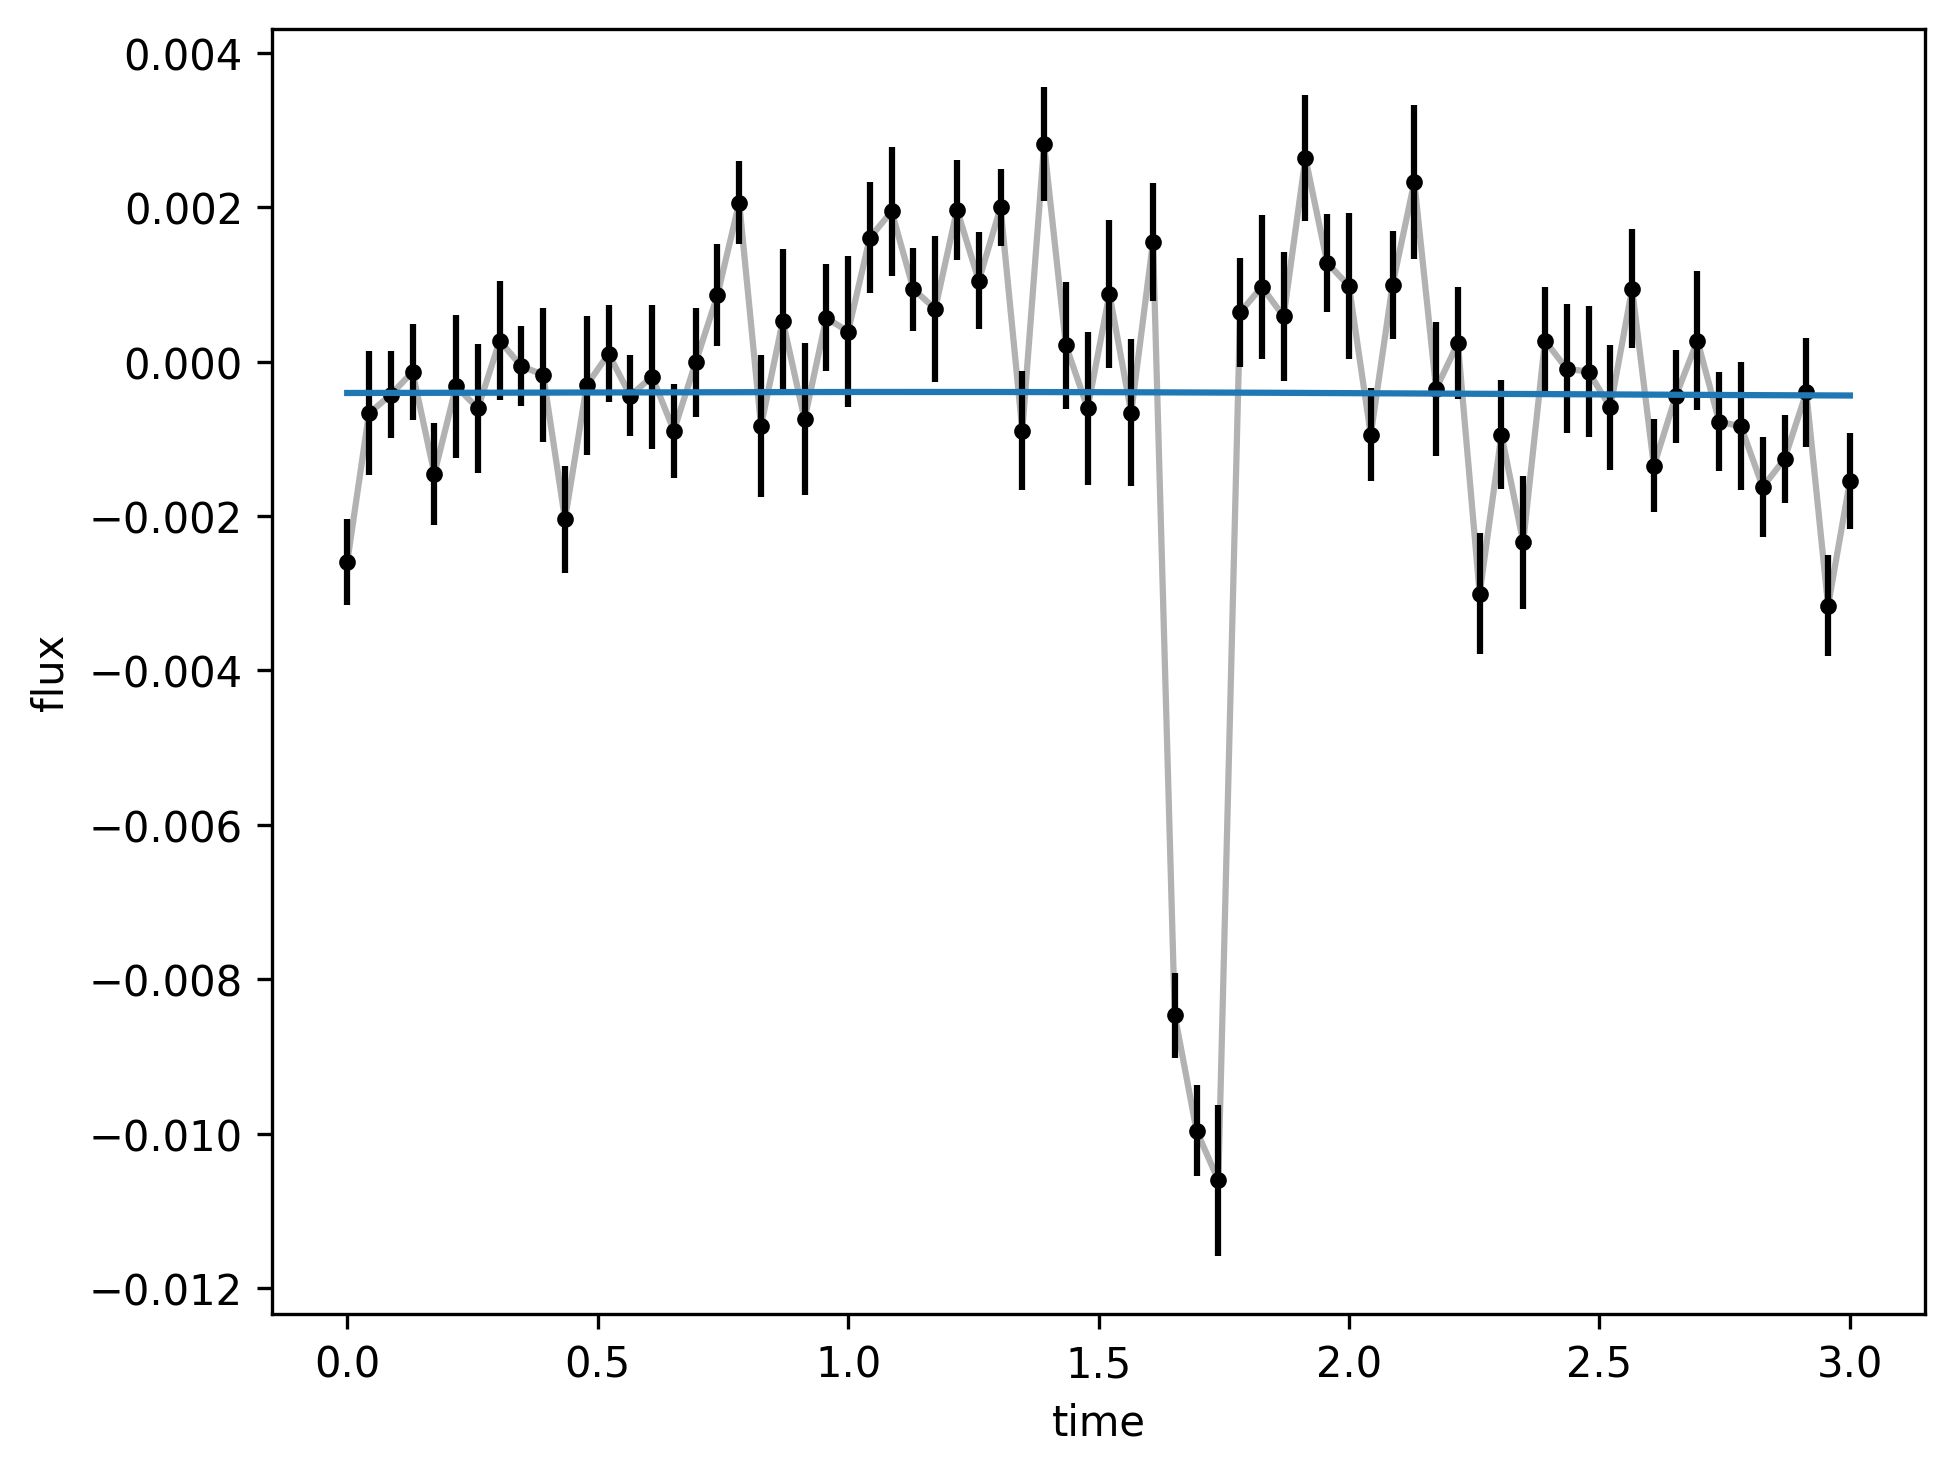

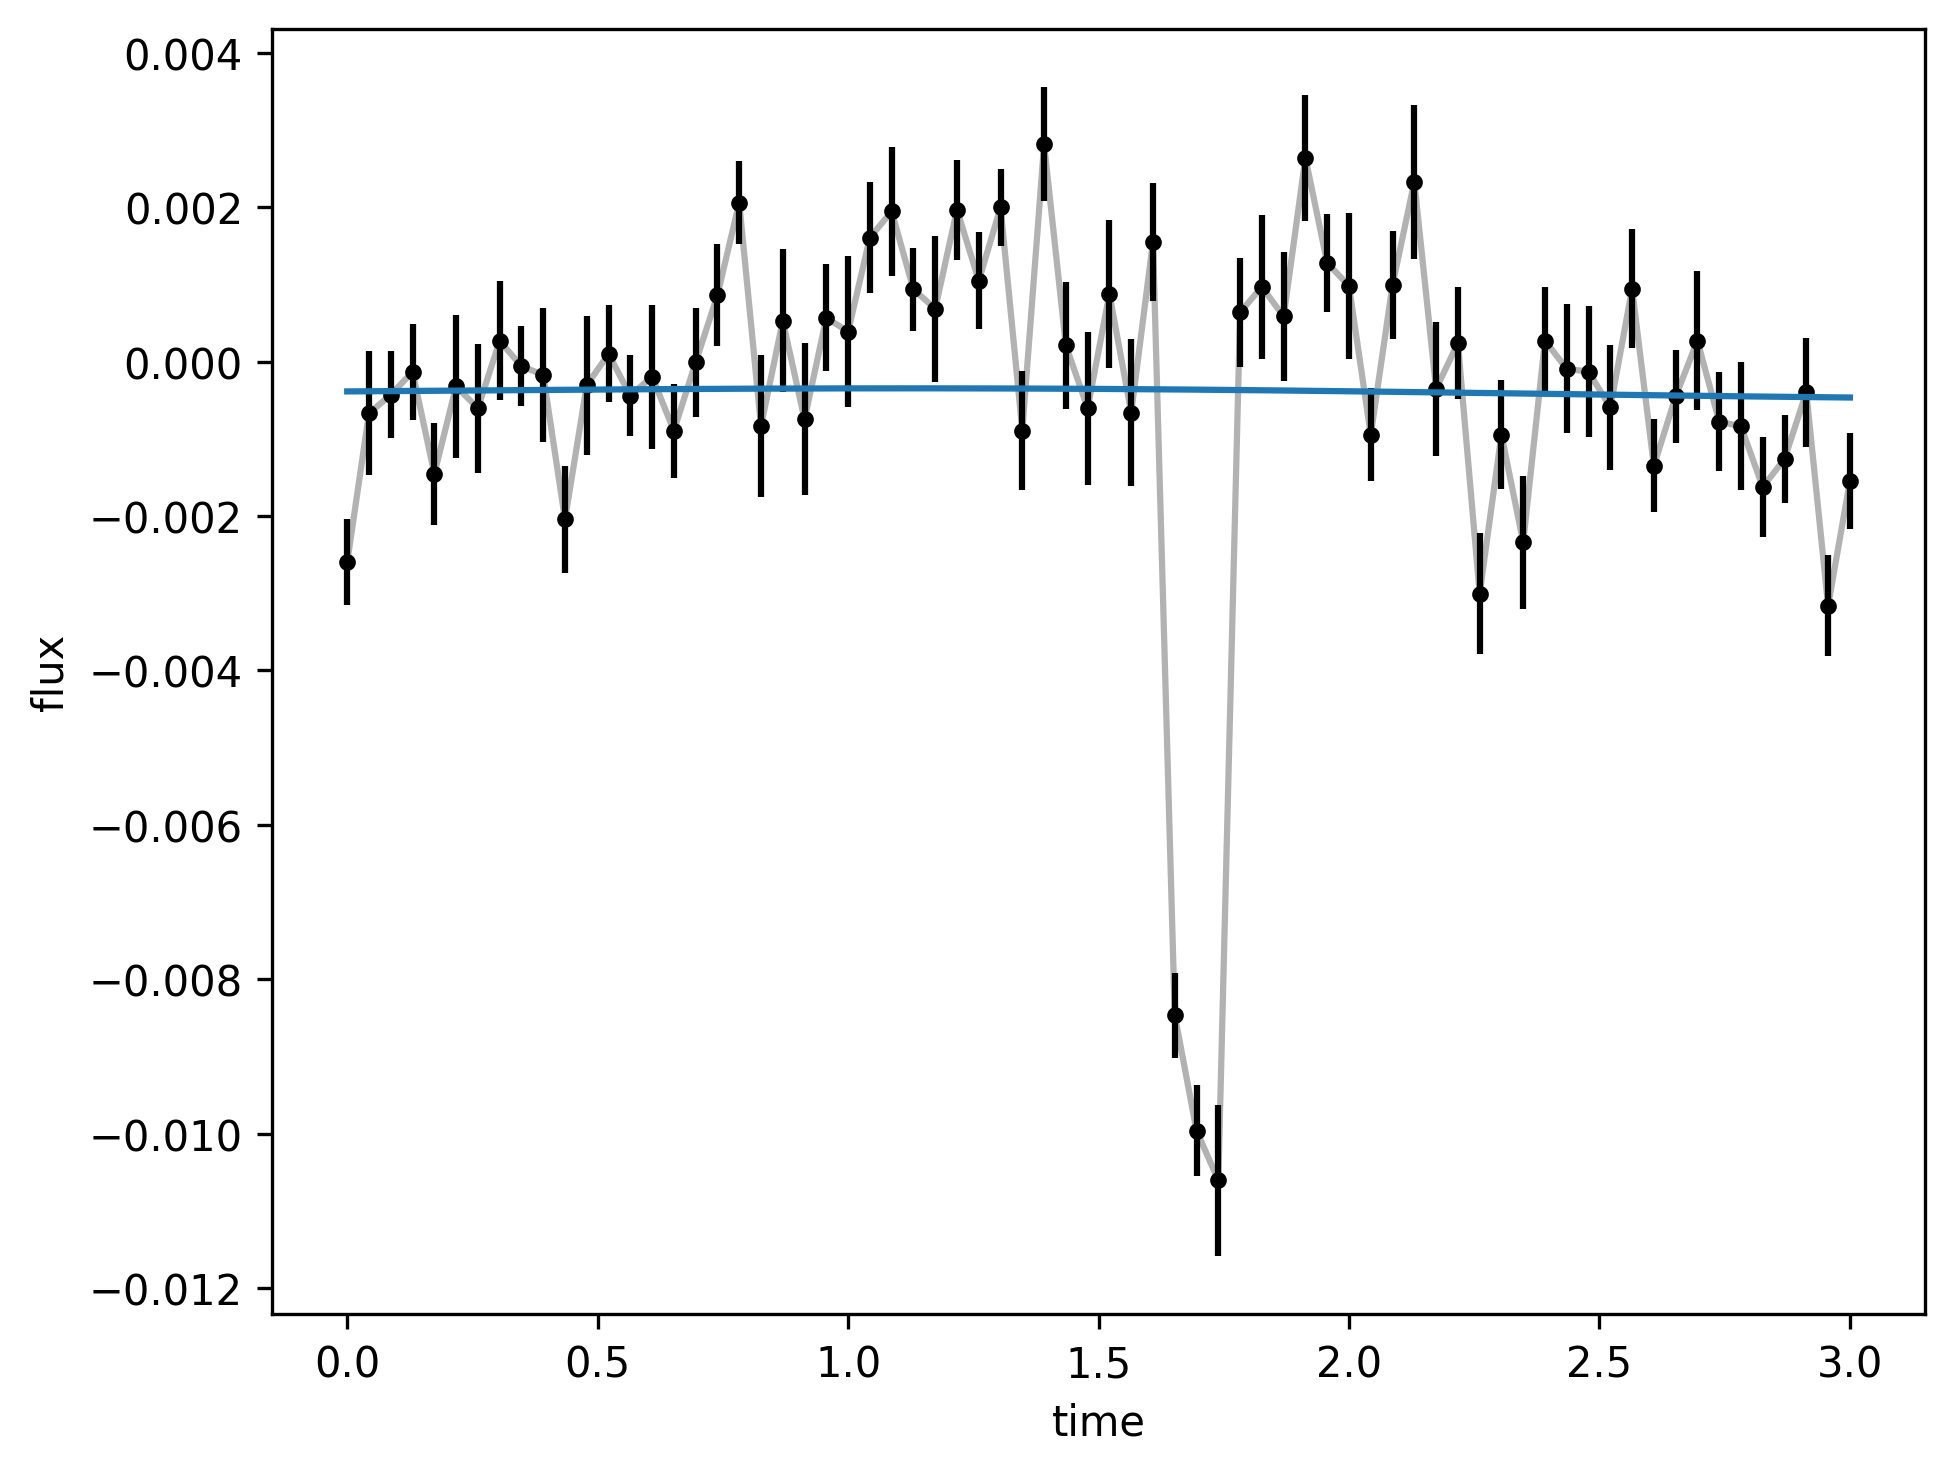

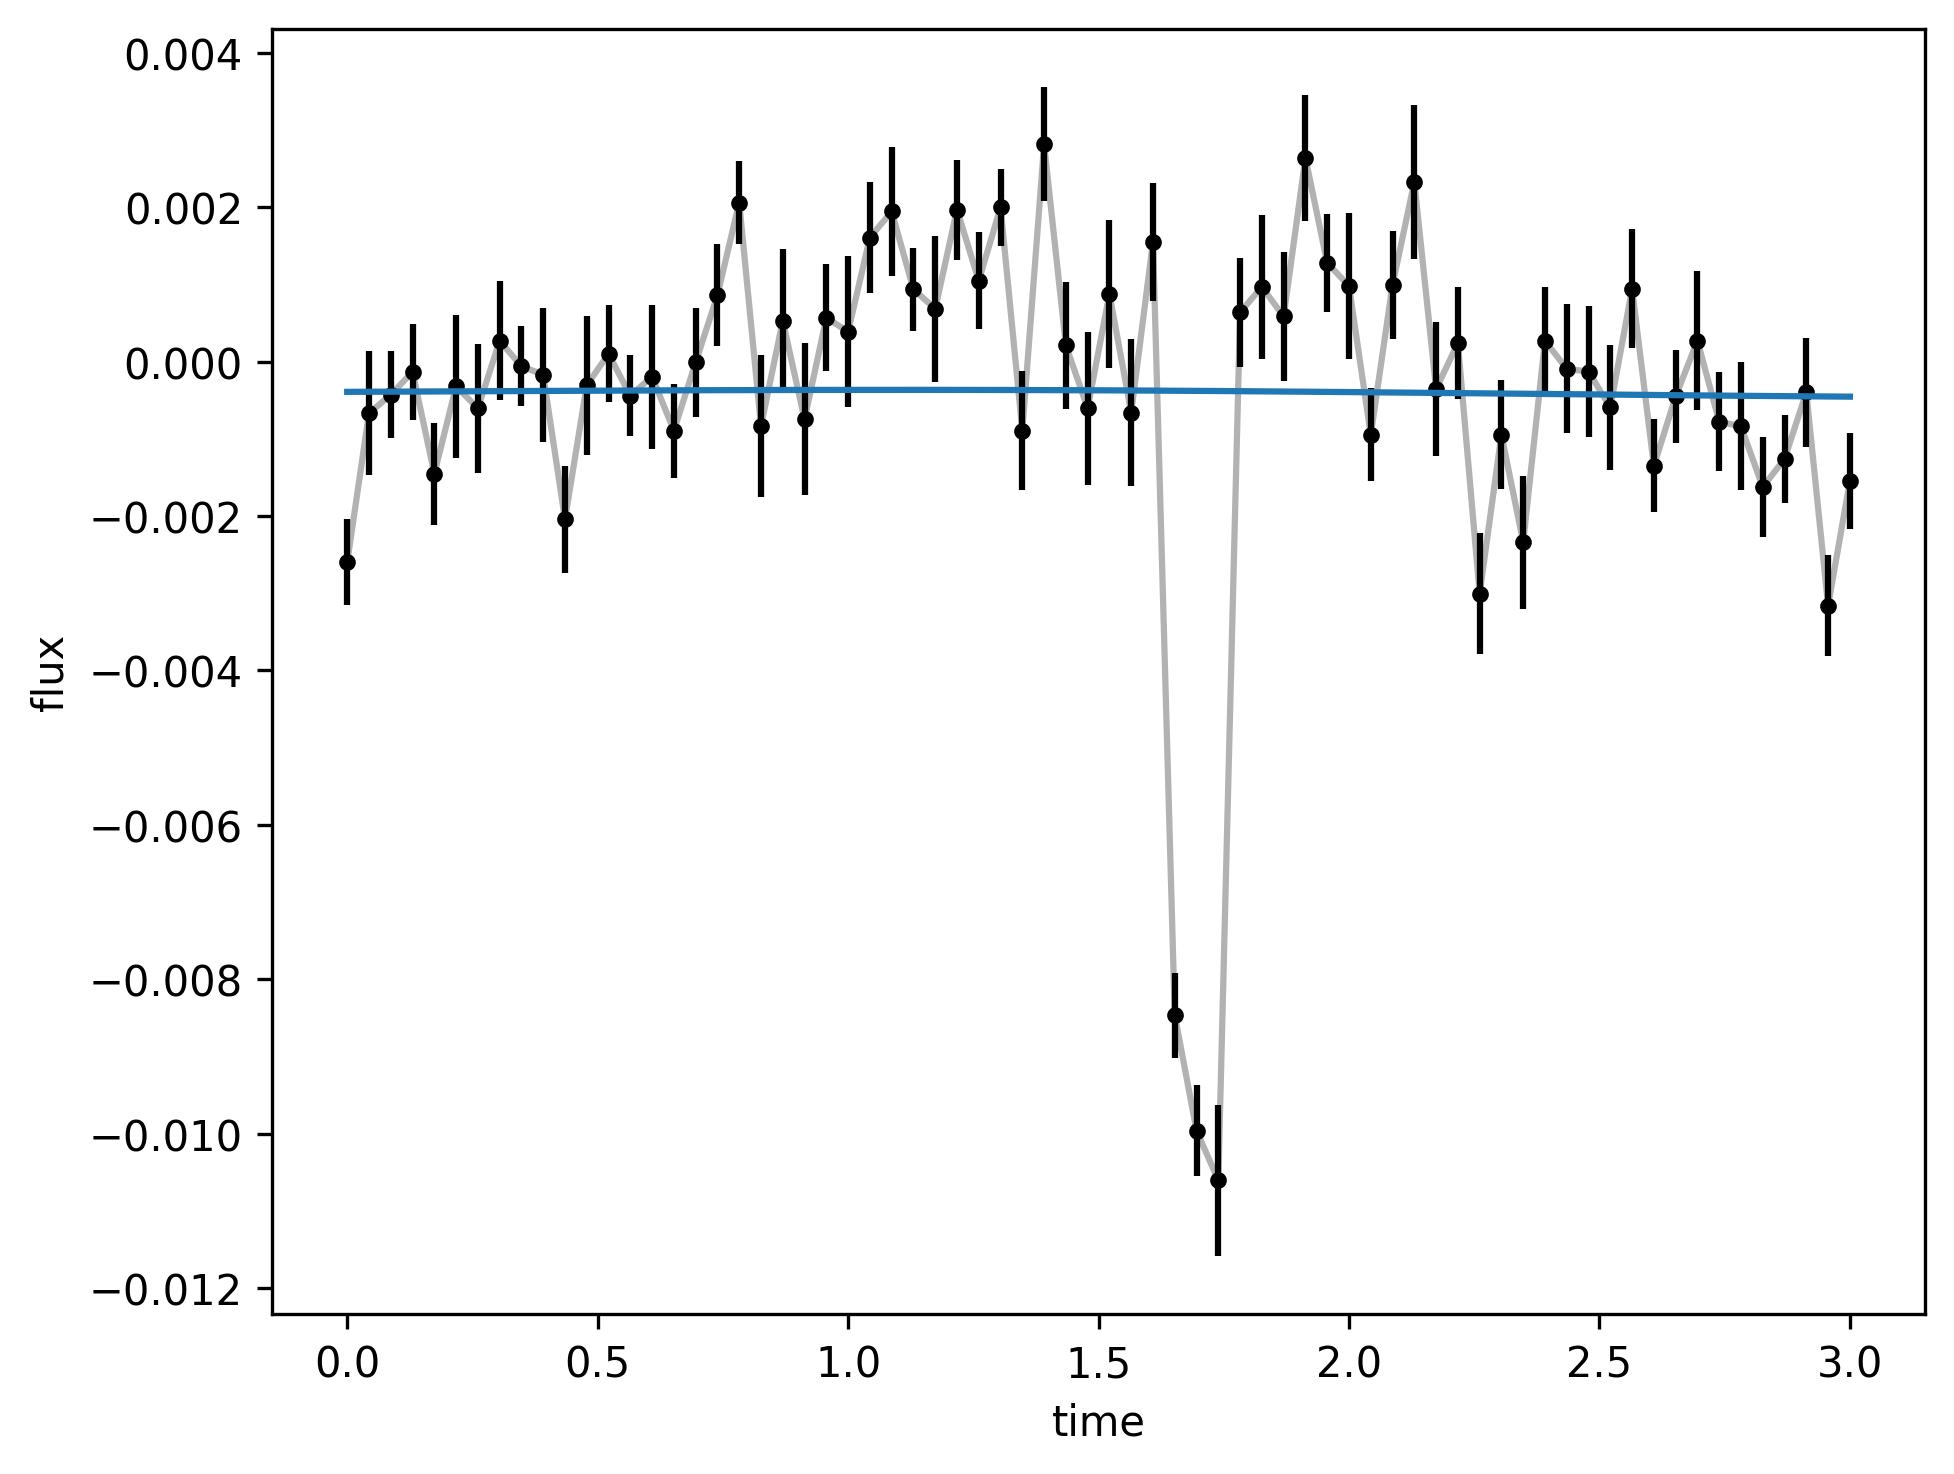

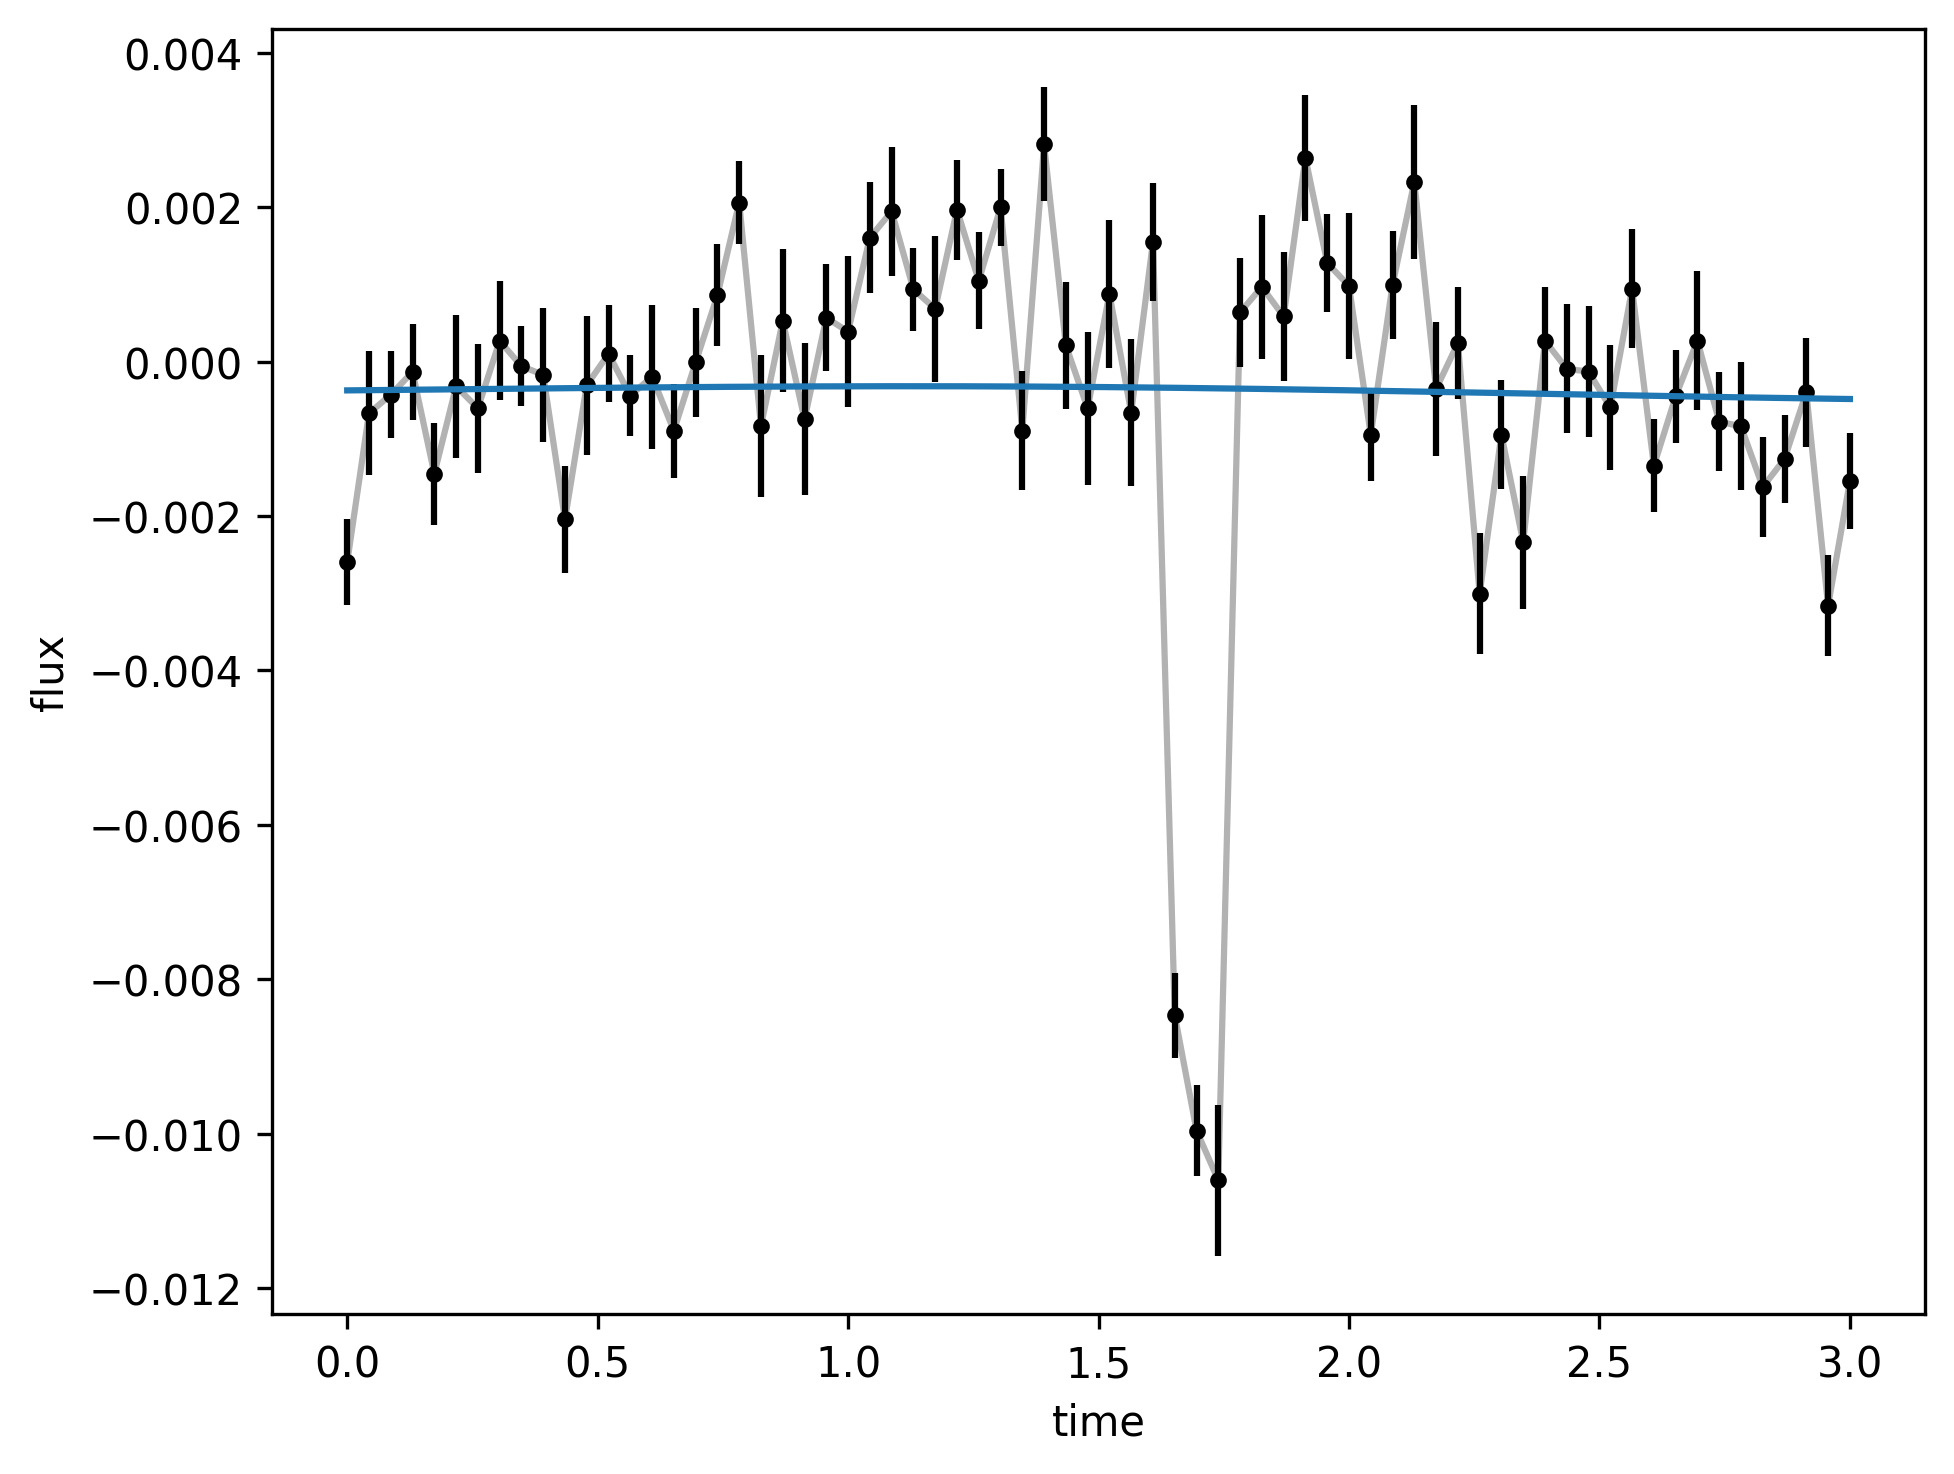

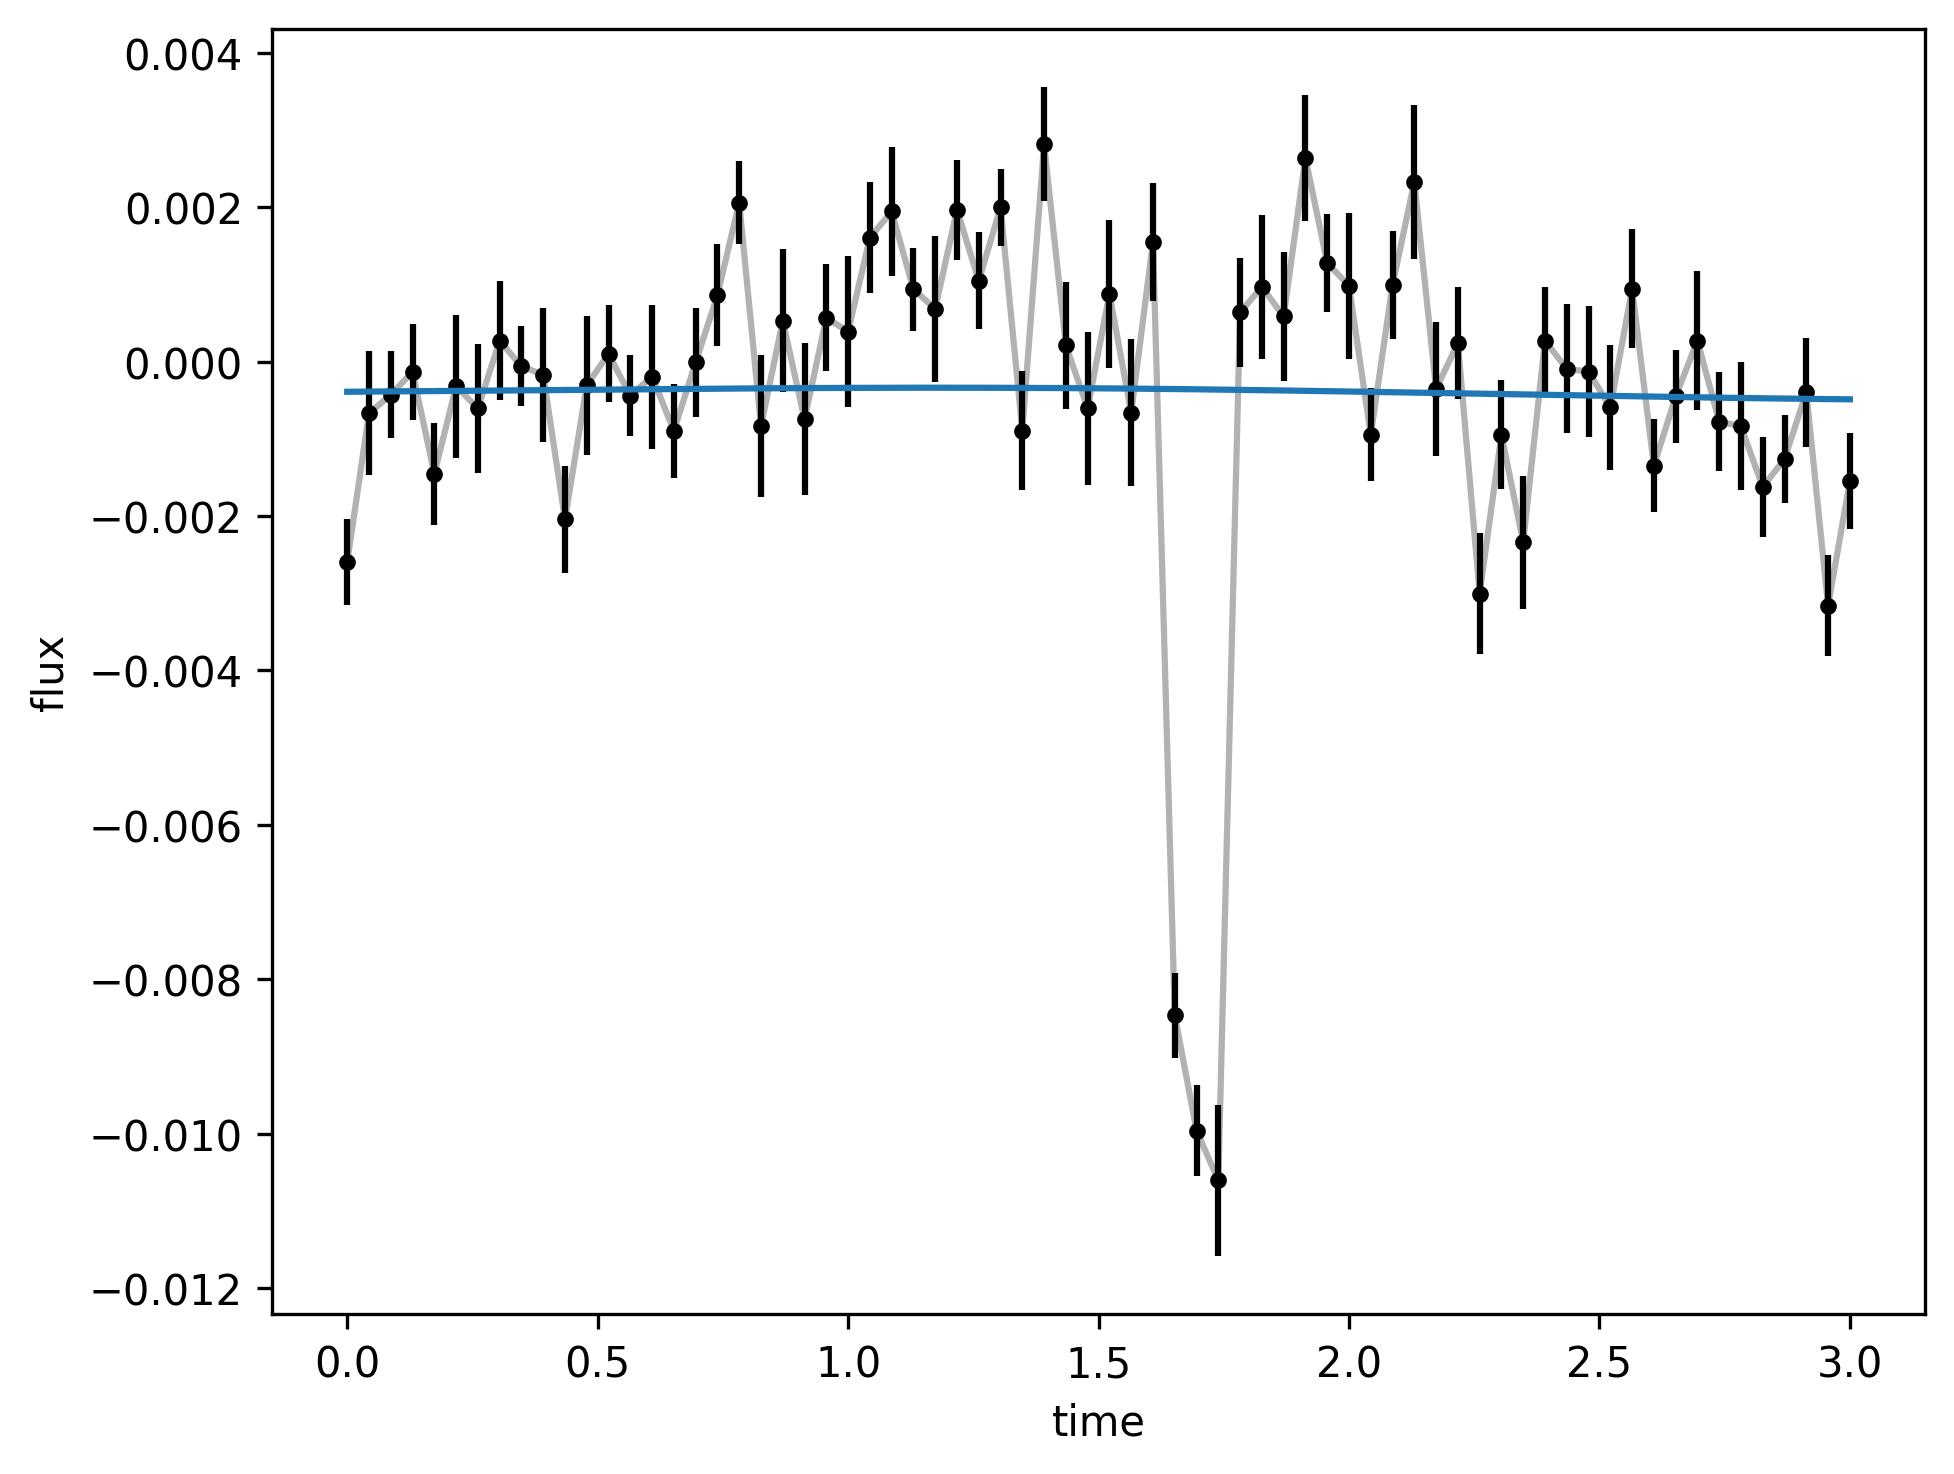

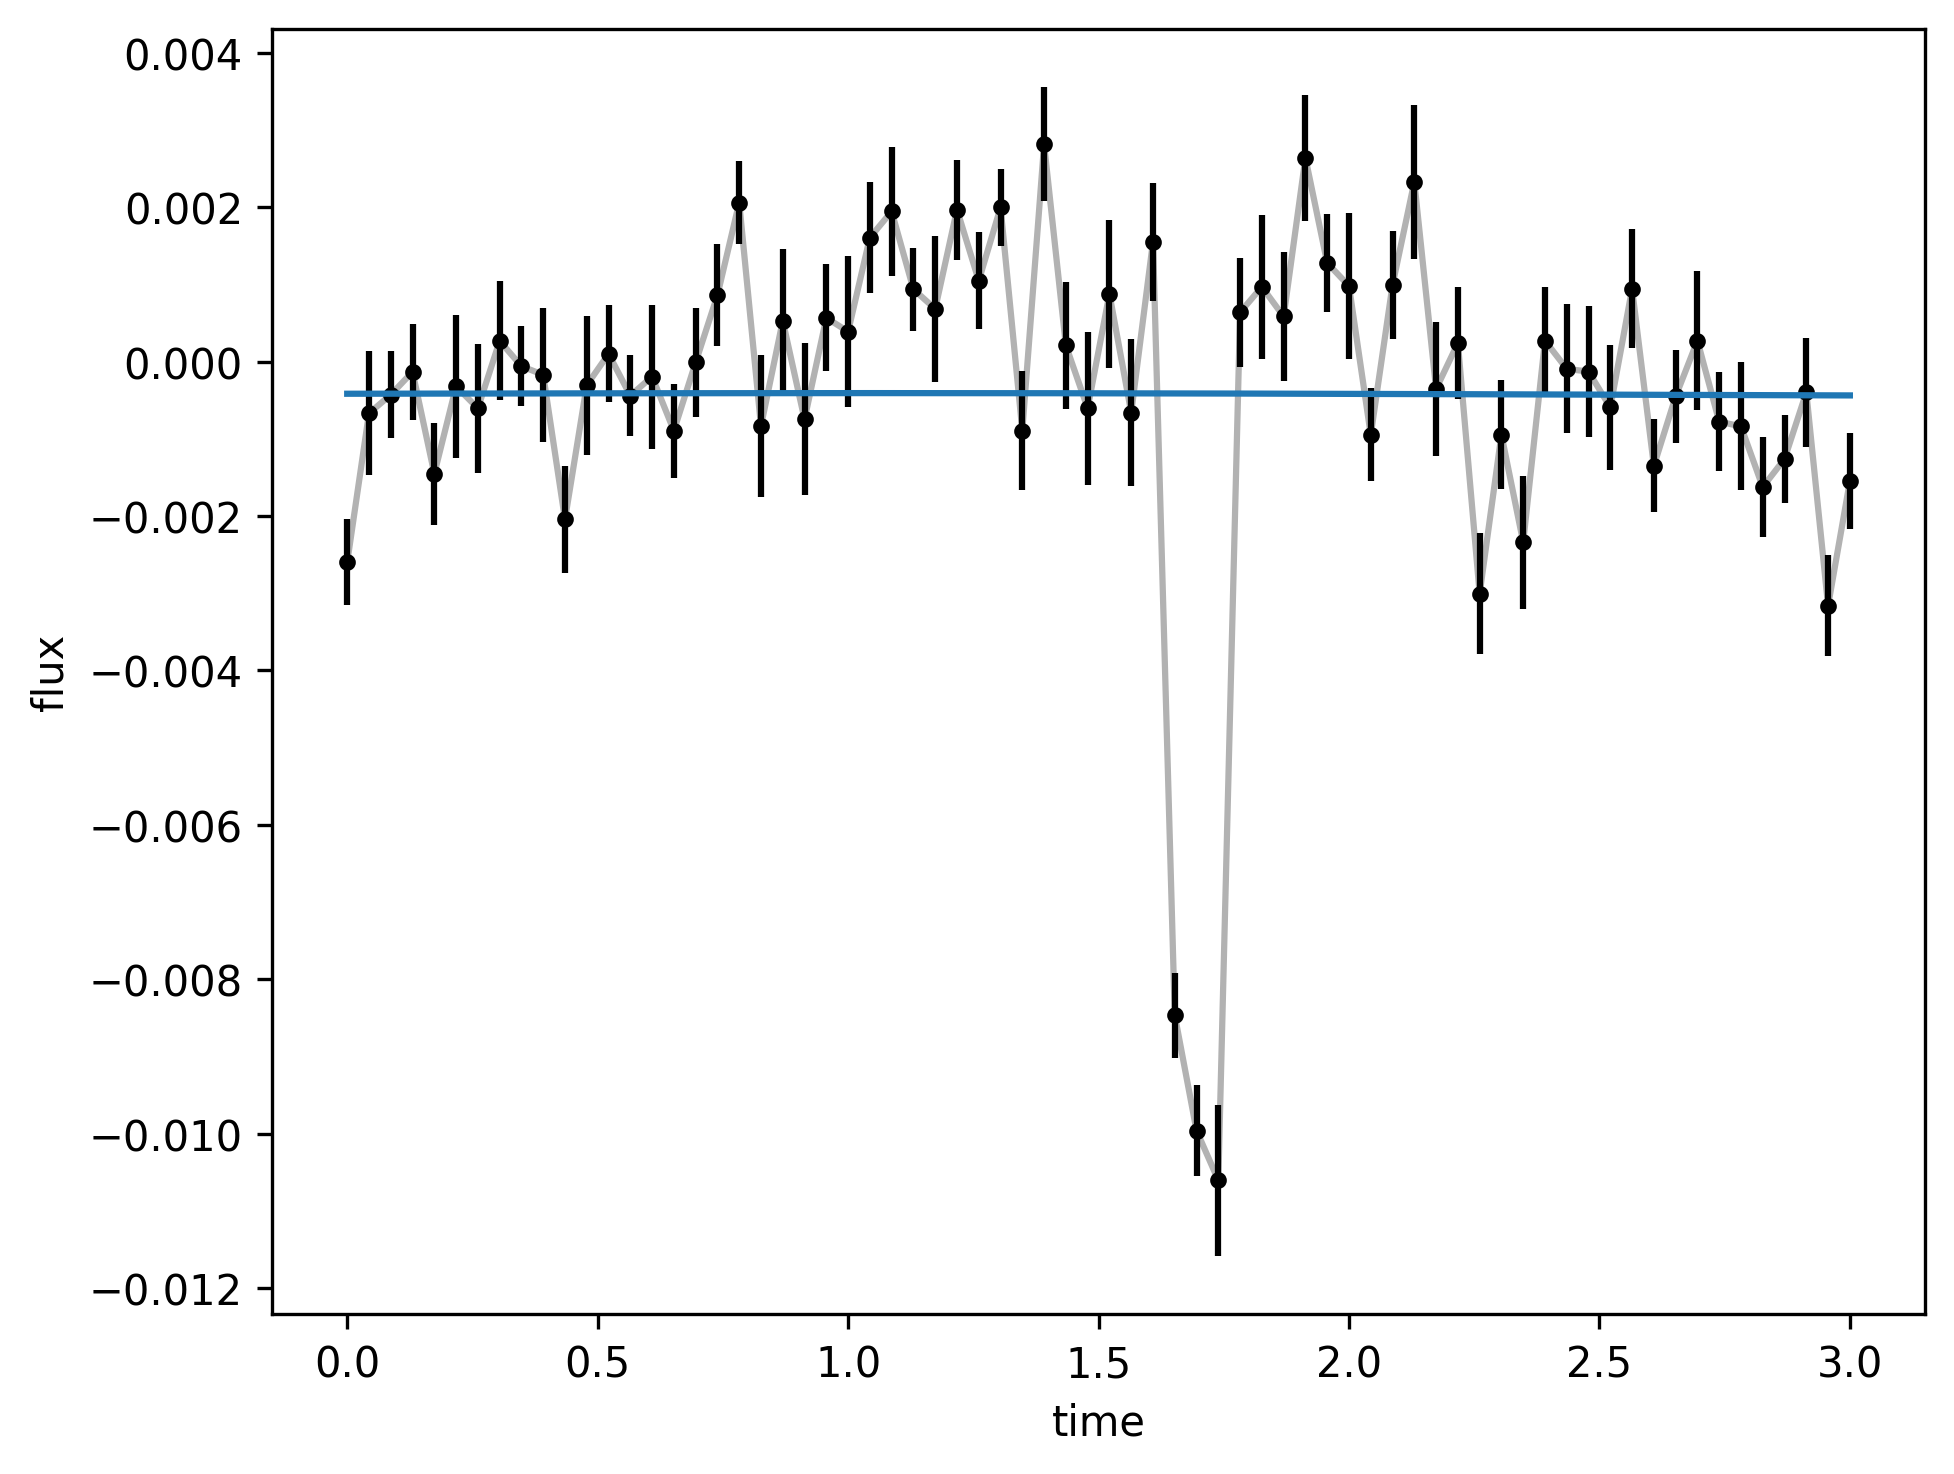

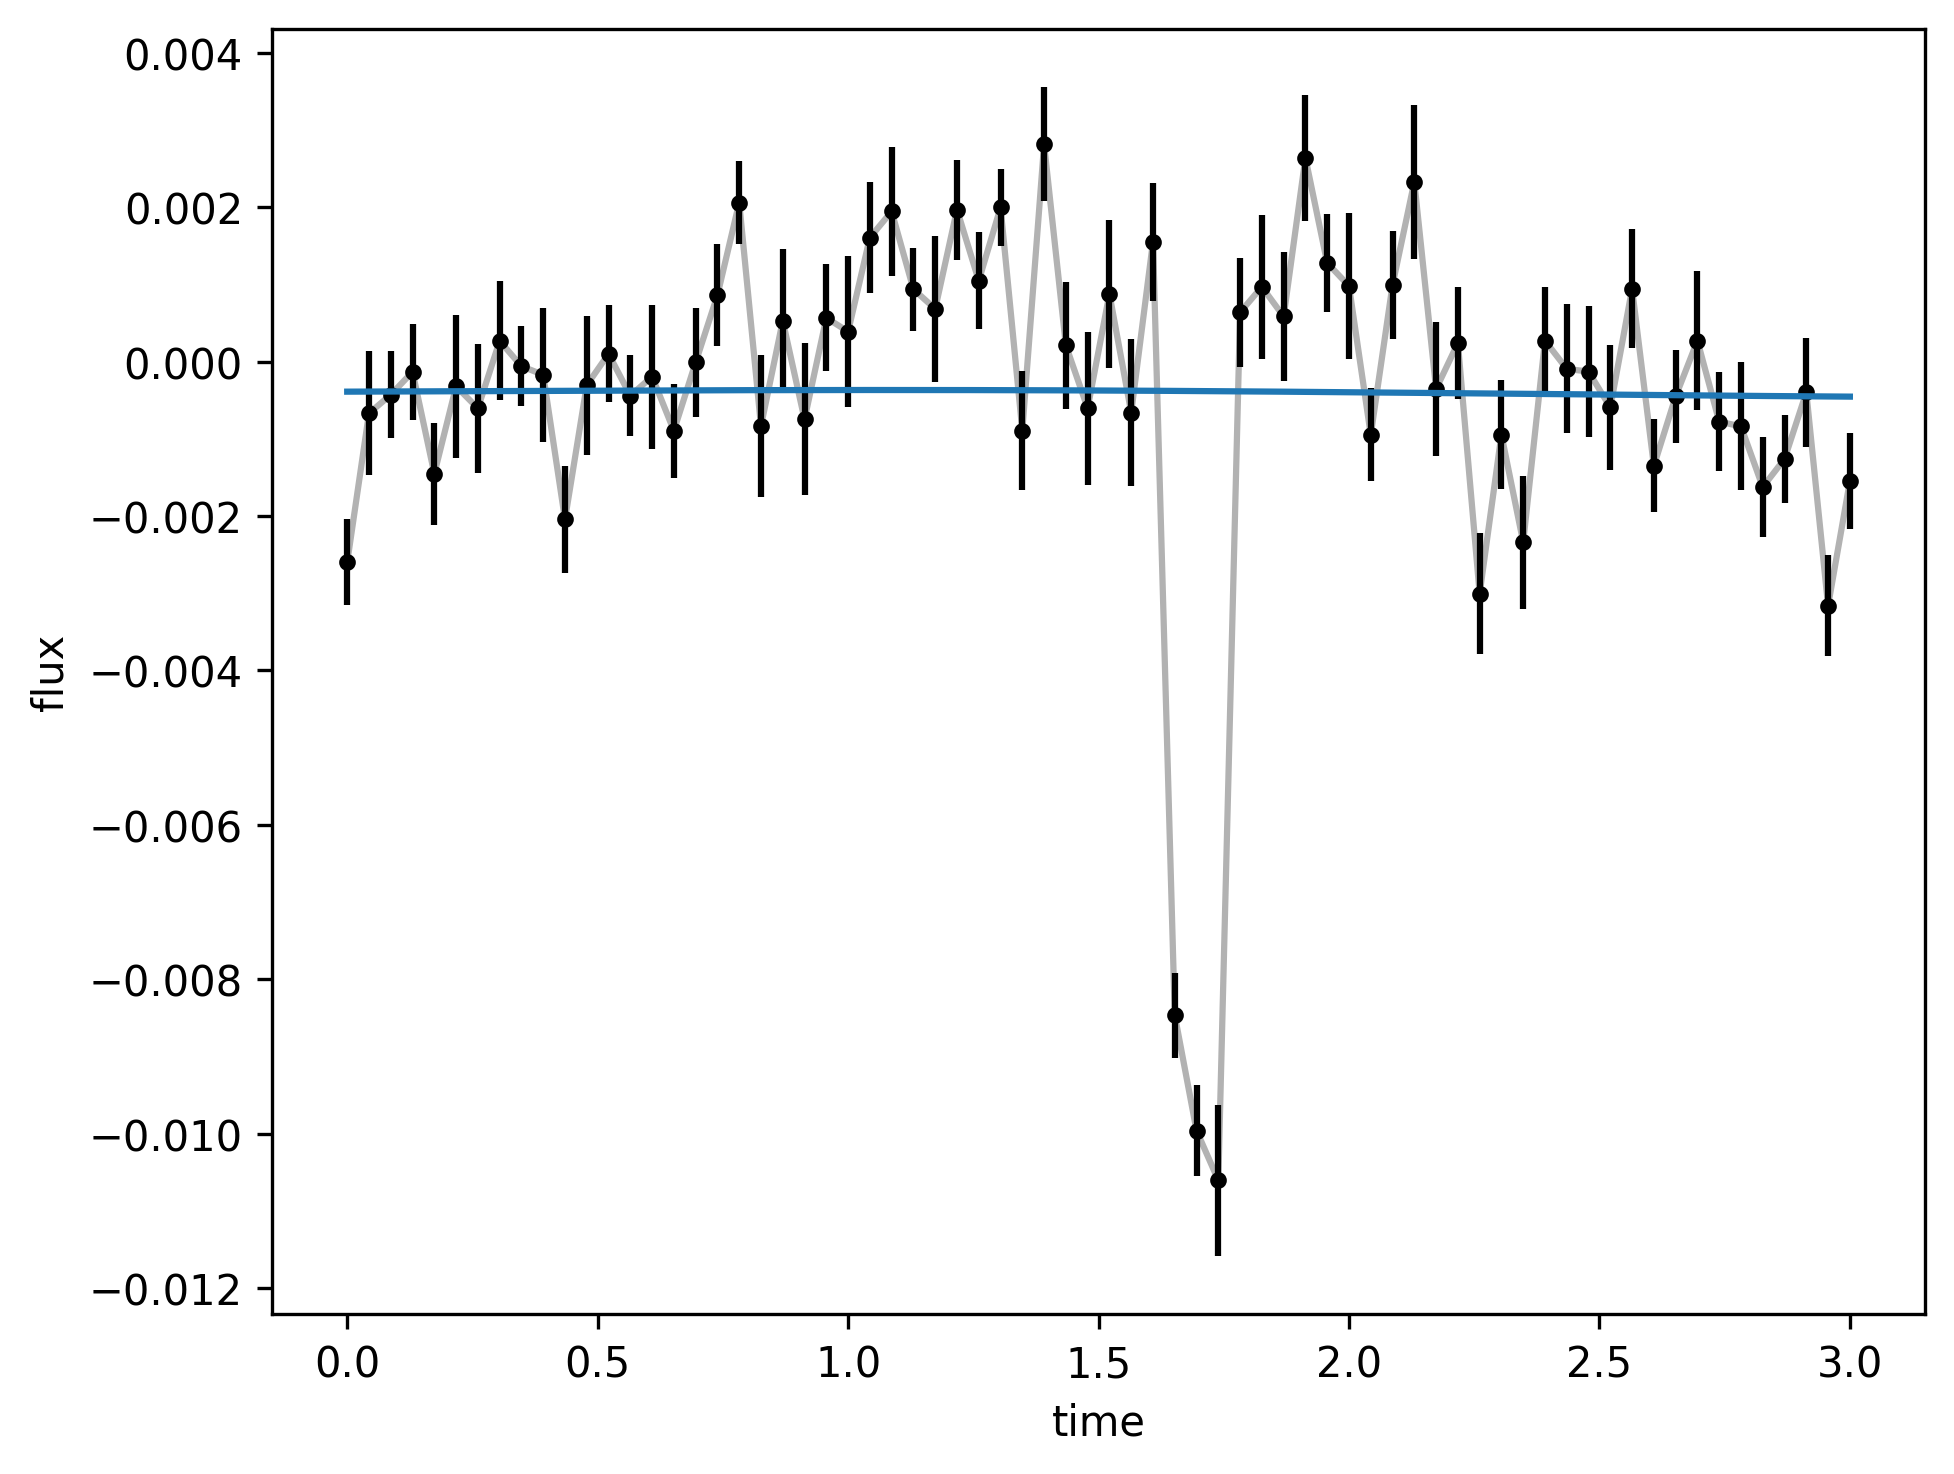

In [58]:
p.plot_traces(num_traces=10, i=1)

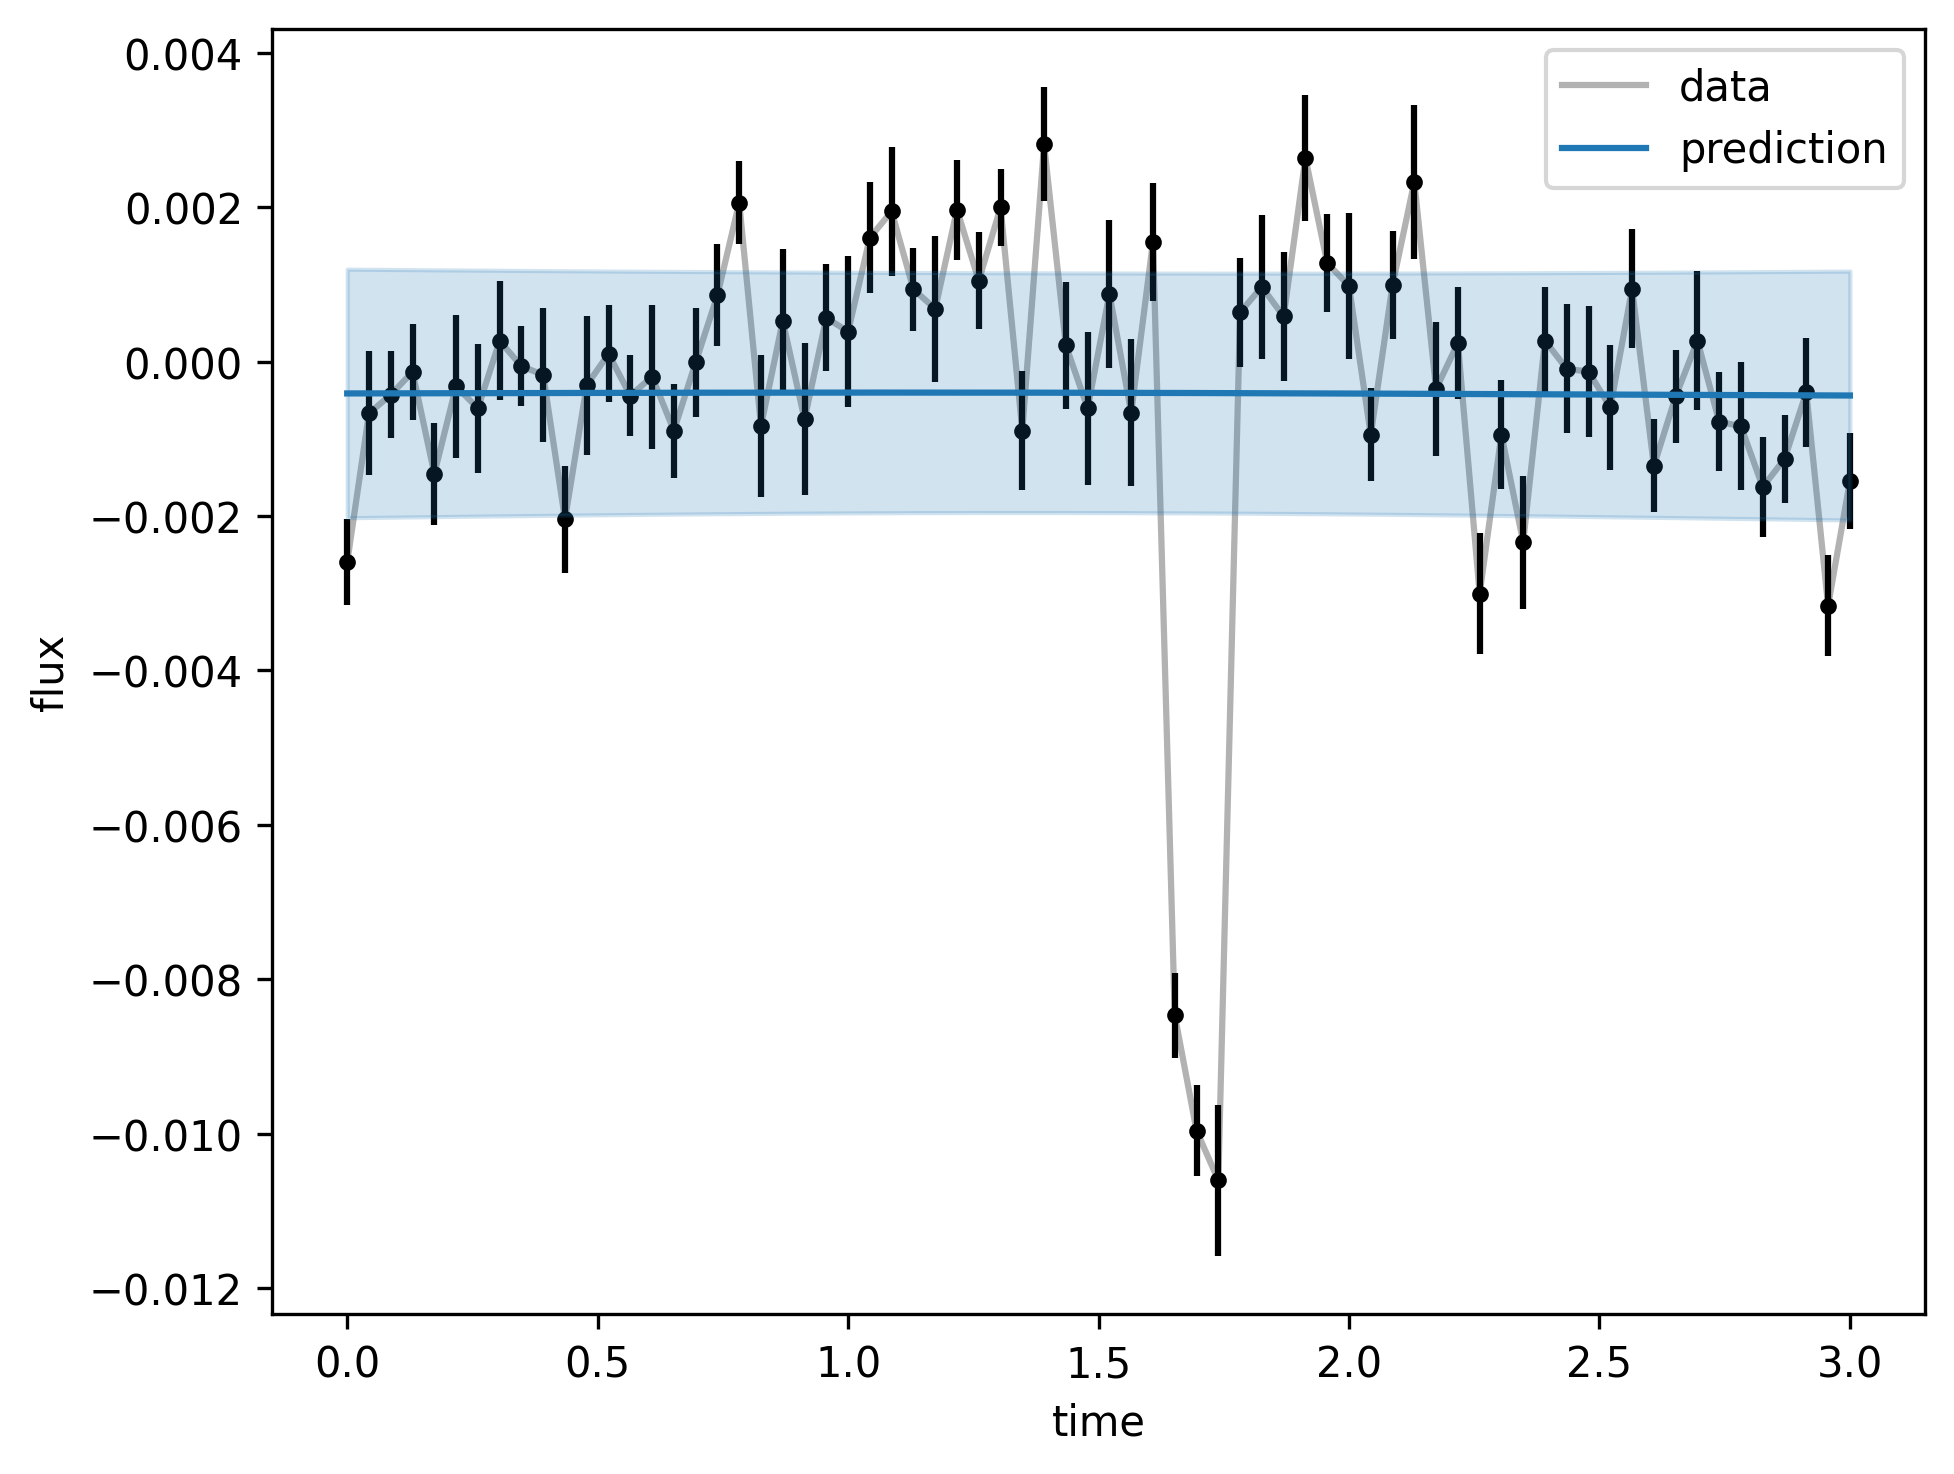

In [56]:
# plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3,label="truth")
gp = p.generate_gp_model_from_params(p.summary['mean'])#new_results)
p.plot_prediction(gp)

In [79]:
# p.plot_model()

Error applying get_model to <chromatic GP model 'periodic', with sho kernel 🌈>: name 'y' is not defined


IndexError: list index out of range